<H1><font color='orange'>Problem Statement: Product Sales Forecasting Overview</font></H1>

Product sales forecasting is both a strategic and operational planning tool. By leveraging historical sales data, we can build a predictive model that accurately estimates future sales across different stores and time periods. This enables businesses to anticipate demand and make smarter decisions.

<H3><font color='orange'>Why do we need Product sales forecasting?</font></H3>

> Inventory Optimization: Ensures the right products are available at the right time, preventing both stockouts and overstocking.

> Efficient Resource Allocation: Supports effective budgeting and allows smarter use of resources such as marketing, staffing, and capital investments.

> Market Responsiveness: Identifies peak and low sales periods, enabling timely promotional campaigns and targeted marketing initiatives.

> Supply Chain Efficiency: Aligns production, logistics, and distribution plans with demand, minimizing transportation and storage costs.

> Informed Strategic Decisions: Provides insights for long-term initiatives like store expansion, entering new markets, or making large-scale capital investments.

<H1><font color='orange'>Dataset Summary</font></H1>

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.7 MB/s eta 0:00:00


In [2]:
#importing essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import ttest_ind, stats, t, shapiro, levene, f_oneway, kruskal, pearsonr, spearmanr, ks_2samp
from statsmodels.graphics.gofplots import qqplot
from custom_transformers import DataTypeCaster, CalendarFeatureEngineer, AOVFeatureMaker, ColumnDropper
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, KFold, RandomizedSearchCV, cross_validate
import itertools
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import tensorflow as tf
from tensorflow import keras
import pickle
from catboost import CatBoostRegressor
import warnings
import joblib

warnings.filterwarnings('ignore')

In [3]:
#Reading the product sales forecast dataset (the training set)
df = pd.read_csv('/content/TRAIN.csv')
df.head()

ID  Store_id Store_Type Location_Type Region_Code        Date  \
0  T1000001         1         S1            L3          R1  2018-01-01   
1  T1000002       253         S4            L2          R1  2018-01-01   
2  T1000003       252         S3            L2          R1  2018-01-01   
3  T1000004       251         S2            L3          R1  2018-01-01   
4  T1000005       250         S2            L3          R4  2018-01-01   

   Holiday Discount  #Order     Sales  
0        1      Yes       9   7011.84  
1        1      Yes      60  51789.12  
2        1      Yes      42  36868.20  
3        1      Yes      23  19715.16  
4        1      Yes      62  45614.52

In [4]:
#Understanding the shape of the product sales forecasting dataset
df.shape

(188340, 10)

The dataset consists of 188340 rows and 10 columns in it.

In [5]:
# To get a comprehensive overview of product sales forecasting dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


The dataset consists of 188,340 records across 10 key attributes related to product sales, including store details, location, region, dates, holidays, discounts, orders, and sales values. All fields are complete with no missing data, ensuring reliability. The data combines both numerical and categorical variables, with Sales being the primary target for forecasting. To prepare the dataset for modeling, some columns like Date and Discount may need refinement to ensure accurate analysis and prediction.

In [6]:
#Correcting essential data types for the product sales forecsting
df['Date'] = pd.to_datetime(df['Date']).dt.date
df['Store_Type'] = df['Store_Type'].astype('category')
df['Location_Type'] = df['Location_Type'].astype('category')
df['Region_Code'] = df['Region_Code'].astype('category')
df['Discount'] = df['Discount'].astype('category')
df.rename(columns={'#Order': 'Order'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   ID             188340 non-null  object  
 1   Store_id       188340 non-null  int64   
 2   Store_Type     188340 non-null  category
 3   Location_Type  188340 non-null  category
 4   Region_Code    188340 non-null  category
 5   Date           188340 non-null  object  
 6   Holiday        188340 non-null  int64   
 7   Discount       188340 non-null  category
 8   Order          188340 non-null  int64   
 9   Sales          188340 non-null  float64 
dtypes: category(4), float64(1), int64(3), object(2)
memory usage: 9.3+ MB


<H1><font color='orange'>Summary Statistics</font></H1>

In [7]:
#Describing the product sales forecast dataset
df.describe()

Store_id        Holiday          Order          Sales
count  188340.000000  188340.000000  188340.000000  188340.000000
mean      183.000000       0.131783      68.205692   42784.327982
std       105.366308       0.338256      30.467415   18456.708302
min         1.000000       0.000000       0.000000       0.000000
25%        92.000000       0.000000      48.000000   30426.000000
50%       183.000000       0.000000      63.000000   39678.000000
75%       274.000000       0.000000      82.000000   51909.000000
max       365.000000       1.000000     371.000000  247215.000000

The dataset reveals that holidays account for only about 13% of the records, indicating that most sales occur on regular days. On average, each store processes around 68 orders, generating approximately ₹42,784 in sales, though there is significant variation across stores and periods. Sales values range widely from zero to over ₹2.47 lakh, showing the presence of both low-demand and peak-demand scenarios. These insights highlight the importance of forecasting to better prepare for fluctuations, optimize resources, and align strategies with actual demand patterns.

In [8]:
#Describing the product sales forecast dataset for non-numerical attributes
df.describe(include=['category', 'object'])

ID Store_Type Location_Type Region_Code        Date Discount
count     188340     188340        188340      188340      188340   188340
unique    188340          4             5           4         516        2
top     T1188340         S1            L1          R1  2019-05-31       No
freq           1      88752         85140       63984         365   104051

The dataset spans four store types, five location categories, and four regional codes, offering a diverse view of market performance. It covers 516 distinct dates, ensuring a broad time range for trend analysis. Discounts are relatively rare, with “No Discount” being the most frequent scenario, appearing in over 100,000 records. This mix of store diversity, geographical spread, time coverage, and discount variations provides a strong foundation for building reliable and insightful sales forecasts.

In [9]:
#To check if the dataset suffers from null values
df.isnull().sum()

ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
Order            0
Sales            0
dtype: int64

The dataset is free from missing values.

In [10]:
#To check if the dataset suffers from any duplicate values.
df.duplicated().sum()

np.int64(0)

<H1><font color='orange'>Univariate Analysis:</font><H1>

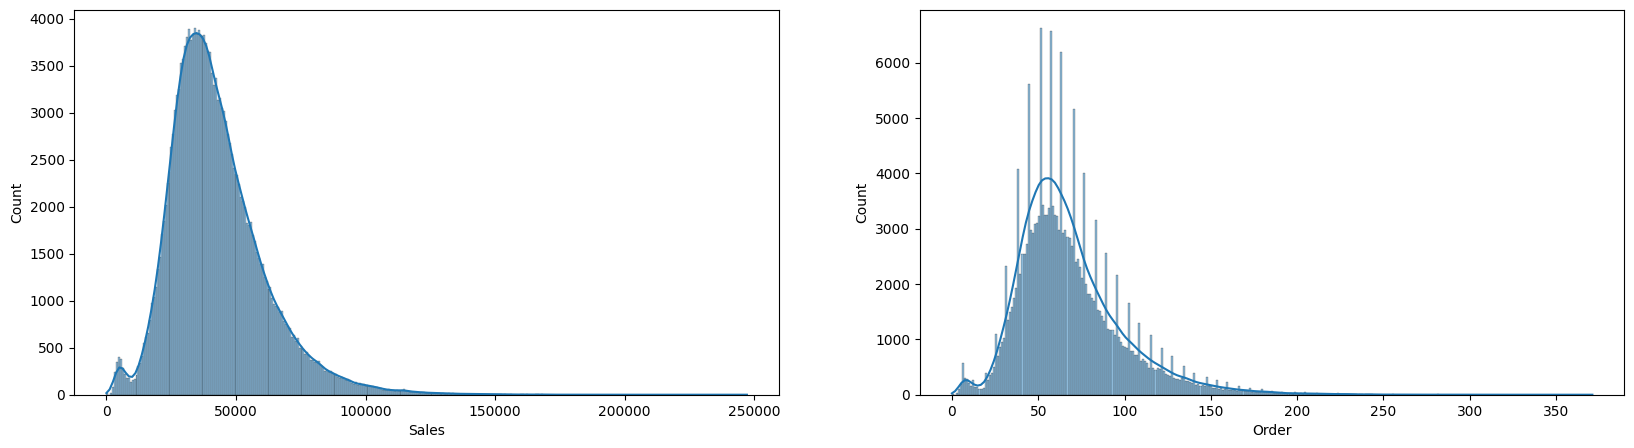

In [11]:
#Histogram that shows the distribution of sales and orders to understand the central tendencies and dispersion.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.histplot(df['Sales'], kde=True, ax=ax[0])
sns.histplot(df['Order'], kde=True, ax=ax[1])
plt.show()

The distribution analysis shows that both sales and orders are right-skewed, meaning most transactions cluster around moderate values with a gradual decline toward higher amounts. Sales typically concentrate between INR 30,000 and INR 60,000, while the number of orders is most frequent between 40 and 80 per period, with fewer instances of very high volumes. This highlights that while peak sales and large orders do occur, they are less common, making demand forecasting crucial for balancing resources and avoiding inefficiencies.

<H1><font color='orange'>Bivariate Analysis:</font></H1>

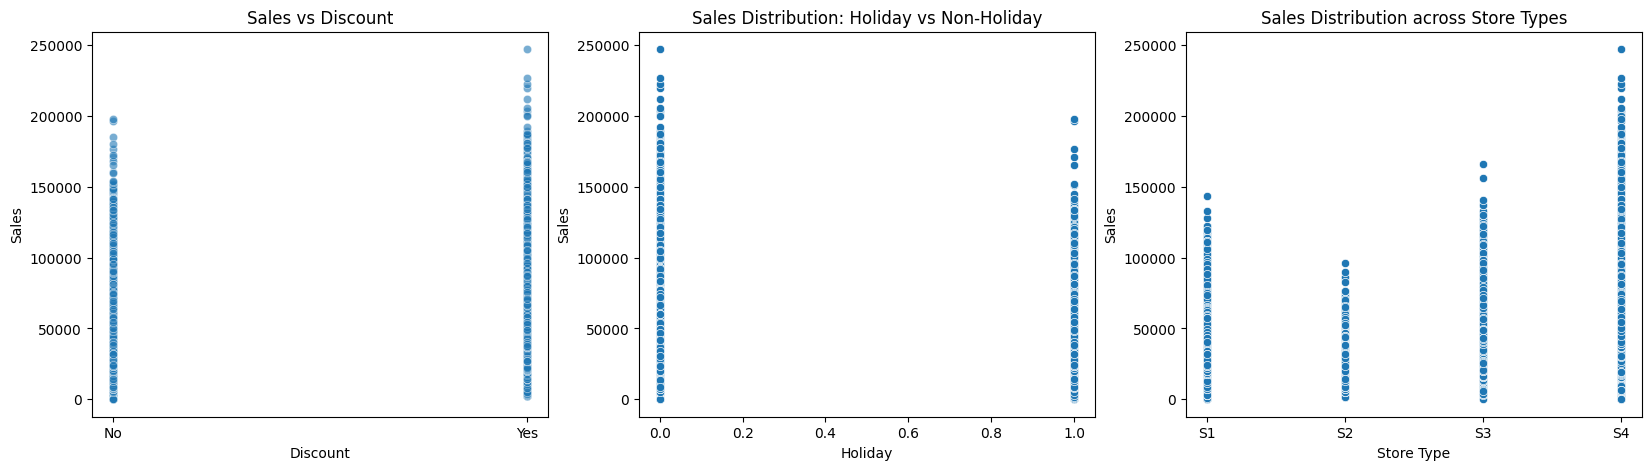

In [12]:
# Relationship Analysis: Sales vs Discounts, Holidays, and Store Types
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

# ---- 1. Scatter Plot: Sales vs Discount ----
sns.scatterplot(data=df, x="Discount", y="Sales", alpha=0.6, ax=ax[0])
plt.sca(ax[0])
plt.title("Sales vs Discount")
plt.xlabel("Discount")
plt.ylabel("Sales")

# ---- 2. Scatter Plot: Sales by Holiday ----
sns.scatterplot(data=df, x="Holiday", y="Sales", ax=ax[1])
plt.sca(ax[1])
plt.title("Sales Distribution: Holiday vs Non-Holiday")
plt.xlabel("Holiday")
plt.ylabel("Sales")

# ---- 3. Scatter Plot: Sales by Store Type ----
sns.scatterplot(data=df, x="Store_Type", y="Sales", ax=ax[2])
plt.sca(ax[2])
plt.title("Sales Distribution across Store Types")
plt.xlabel("Store Type")
plt.ylabel("Sales")

plt.show()

The sales distribution analysis highlights three important patterns: firstly, discounts generally drive higher sales volumes, confirming their effectiveness as a promotional tool. Secondly, holidays do not show a major uplift compared to regular days. Lastly, store type plays a significant role in performance, with sales varying noticeably across different store categories, where some formats (e.g., S4) consistently achieve higher sales. These insights emphasize the importance of tailoring strategies around promotions, holiday planning, and store-specific operations to maximize revenue.

<H1><font color='orange'>Time Series Analysis:</font></H1>

In [13]:
#creating a data frame for time series analysis daily, weekly and monthly
timeSeries_df = df.copy()
timeSeriesAnalysis_df = df.copy()
timeSeries_df['Date'] = pd.to_datetime(timeSeries_df['Date'])
timeSeries_df = timeSeries_df.set_index('Date')

# Daily Sales
daily_sales = timeSeries_df['Sales'].resample('D').sum()

# Weekly Sales
weekly_sales = timeSeries_df['Sales'].resample('W').sum()

# Monthly Sales
monthly_sales = timeSeries_df['Sales'].resample('M').sum()

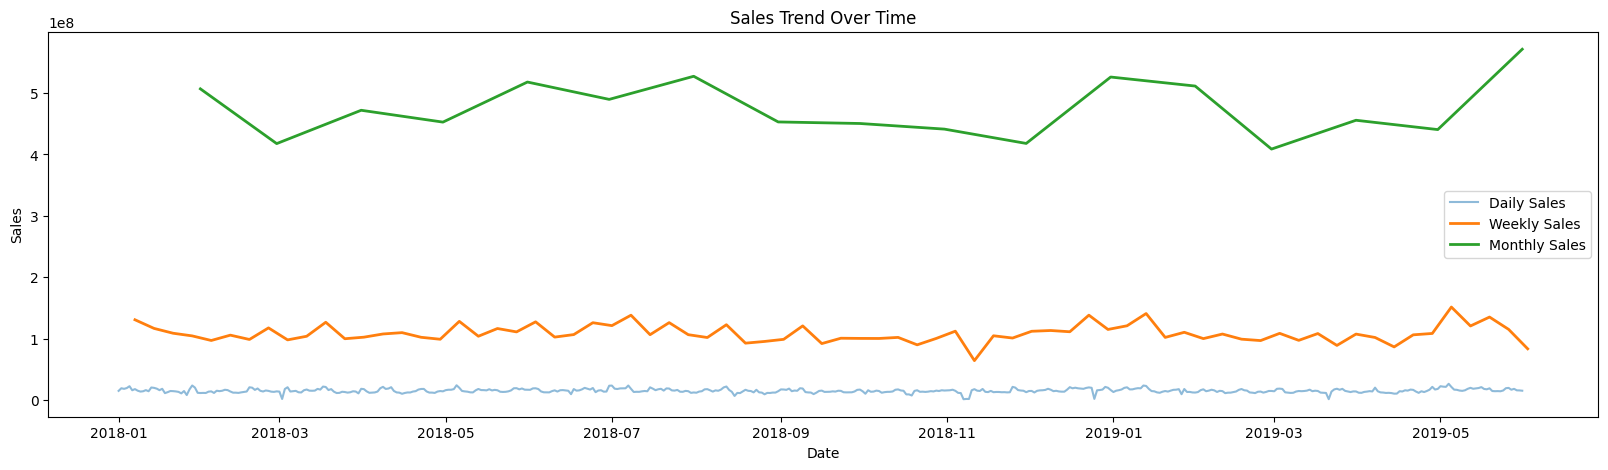

In [14]:
#A line chart that is to display daily, monthly and weekly sales.
plt.figure(figsize=(20,5))
plt.plot(daily_sales, label='Daily Sales', alpha=0.5)
plt.plot(weekly_sales, label='Weekly Sales', linewidth=2)
plt.plot(monthly_sales, label='Monthly Sales', linewidth=2)
plt.title("Sales Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

The sales trend over time shows that monthly sales remain relatively stable with some seasonal fluctuations, while weekly sales exhibit more noticeable ups and downs, reflecting short-term demand variations. Daily sales, although more volatile, follow a consistent baseline pattern that aligns with the broader weekly and monthly cycles. These insights highlight the importance of looking at sales across different time scales to capture both steady growth trends and short-term shifts in customer demand.

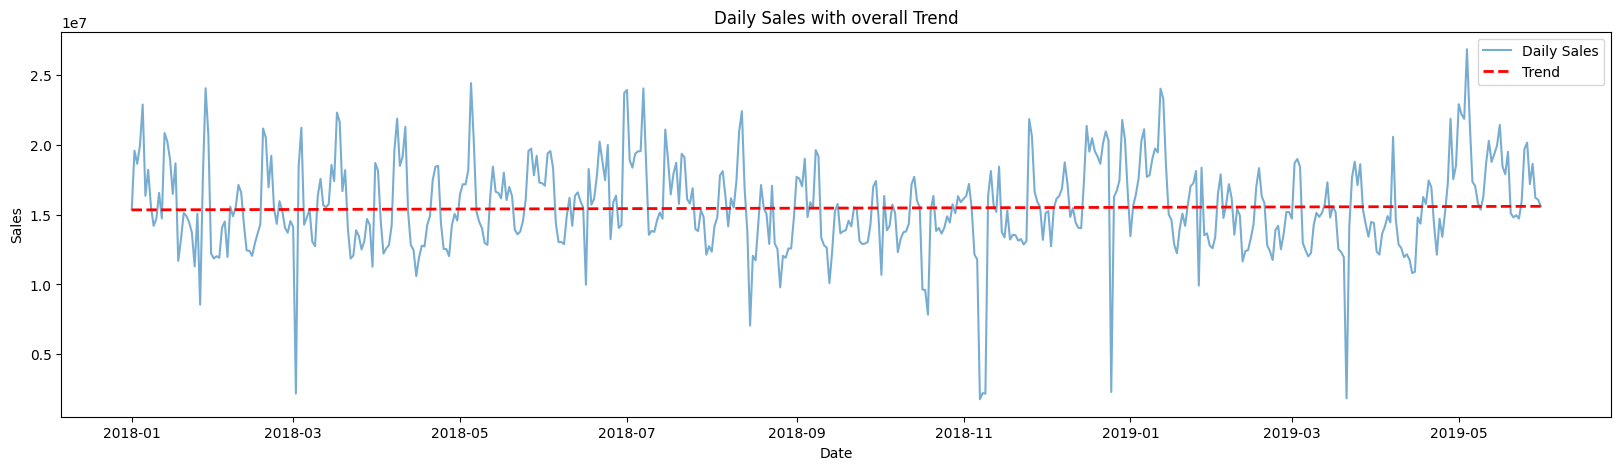

In [15]:
#Creating a line chart for daily Sales with overall Trend
time_df = timeSeries_df.groupby('Date')['Sales'].sum()

plt.figure(figsize=(20, 5))
plt.plot(time_df, label="Daily Sales", alpha=0.6)

# Adding a trend line by connecting first and last point
plt.plot([time_df.index[0], time_df.index[-1]],
         [time_df.iloc[0], time_df.iloc[-1]],
         color="red", linewidth=2, linestyle='--', label="Trend")

plt.title("Daily Sales with overall Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

The daily sales data shows significant fluctuations over time, with frequent ups and downs, but no clear upward or downward trend overall. The red trend line, connecting the starting and ending points, confirms that sales have remained relatively stable across the observed period despite short-term volatility. This indicates that while daily sales are highly variable, the overall long-term sales performance has not shifted substantially.

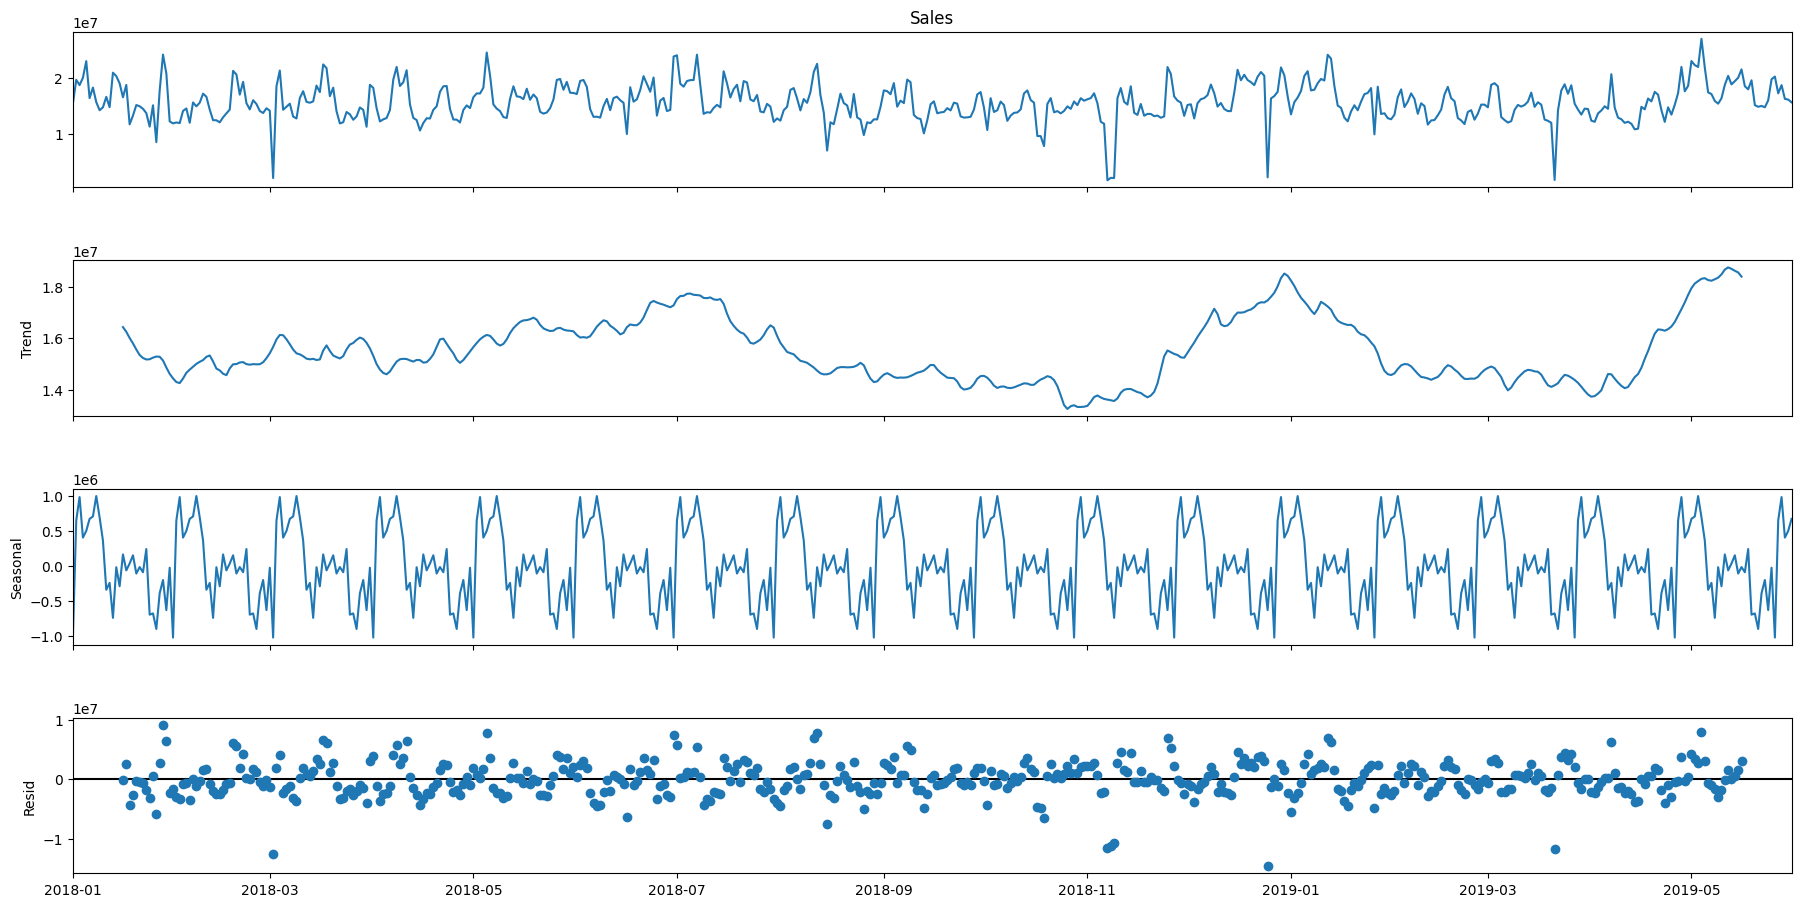

In [16]:
#displaying the seasonal decomposition of the sales.
decomposition = seasonal_decompose(time_df, model='additive', period=30)
fig = decomposition.plot()
fig.set_size_inches(20, 10)
plt.show()

The time series decomposition of sales reveals three key insights: seasonality, trend, and residual variation. The trend component shows a gradual upward movement over time, indicating overall sales growth despite fluctuations. The seasonal component highlights recurring monthly patterns, reflecting predictable demand cycles. Finally, the residuals capture random variations and outliers that are not explained by trend or seasonality. Together, these insights confirm that sales are influenced by both long-term growth and regular seasonal behavior, which can be leveraged to improve forecasting accuracy and business planning.

<H1><font color='orange'>Categorical Data Analysis:</font></H1>

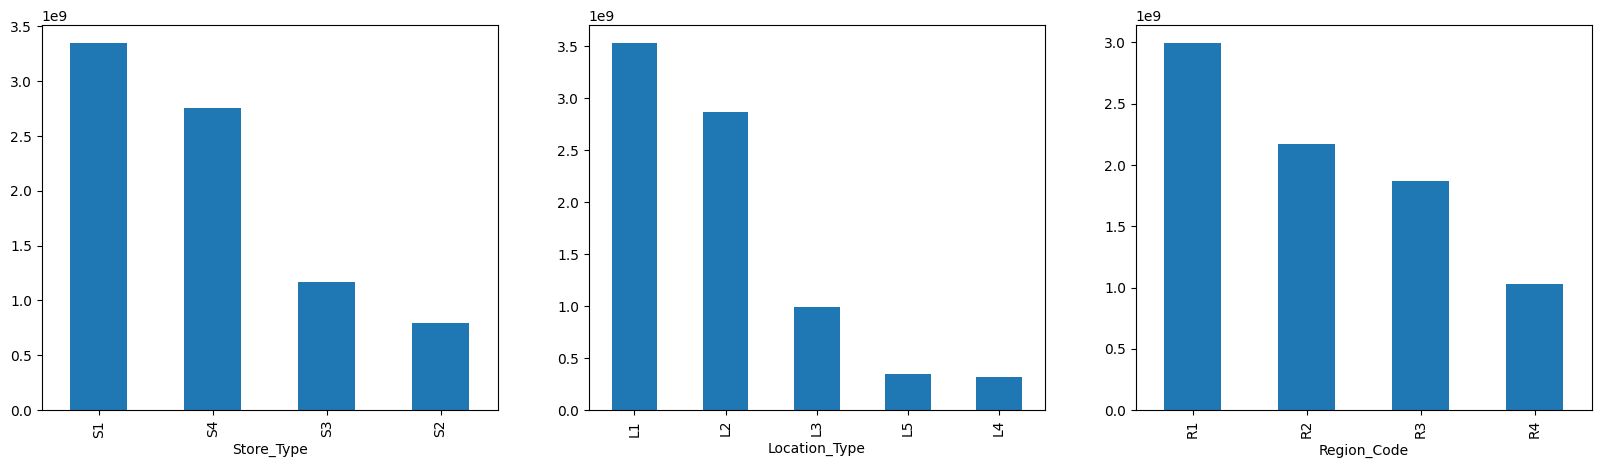

In [17]:
#Total sales based on store type, location type and region code
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
df.groupby('Store_Type')['Sales'].sum().sort_values(ascending=False).plot(kind='bar', ax=ax[0])
df.groupby('Location_Type')['Sales'].sum().sort_values(ascending=False).plot(kind='bar', ax=ax[1])
df.groupby('Region_Code')['Sales'].sum().sort_values(ascending=False).plot(kind='bar', ax=ax[2])
plt.show()

The sales breakdown highlights clear differences across store types, locations, and regions. Among store formats, S1 and S4 generate the highest sales, while S2 lags significantly behind. In terms of location, L1 and L2 dominate sales performance, with other locations contributing far less. Similarly, Region R1 leads in total sales, followed by R2 and R3, while R4 records the lowest sales. These insights suggest that business growth strategies should prioritize high-performing store types, locations, and regions while identifying opportunities to uplift underperforming segments.

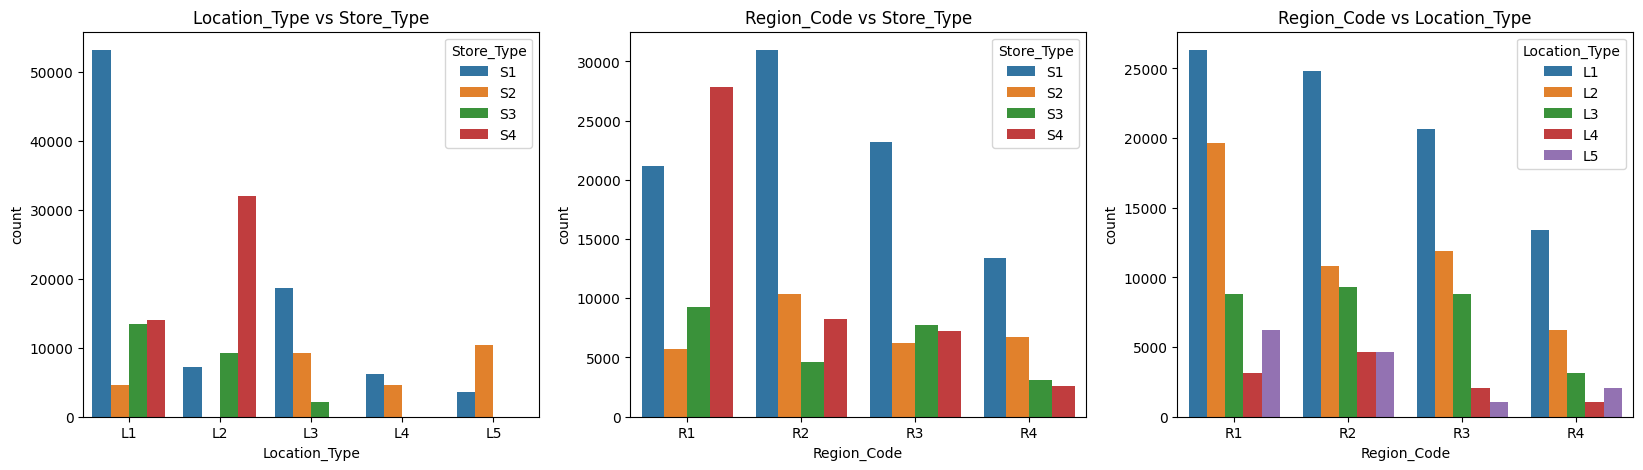

In [18]:
# To analyze the relationship and distribution of categorical variables (Store Type, Location Type, and Region Code) with each other

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
sns.countplot(x = df['Location_Type'], hue = df['Store_Type'], ax=ax[0])
plt.sca(ax[0])
plt.title('Location_Type vs Store_Type')

sns.countplot(x = df['Region_Code'], hue = df['Store_Type'], ax=ax[1])
plt.sca(ax[1])
plt.title('Region_Code vs Store_Type')

sns.countplot(x = df['Region_Code'], hue = df['Location_Type'], ax=ax[2])
plt.sca(ax[2])
plt.title('Region_Code vs Location_Type')

plt.show()

The categorical distribution analysis shows that store types are not evenly spread across locations and regions. For instance, S1 stores are heavily concentrated in L1 locations and across all regions, while S4 stores are particularly strong in L2 and R1. Similarly, location types like L1 dominate across multiple regions, whereas L4 and L5 are relatively underrepresented. These patterns highlight how store formats and locations are strategically placed across regions, influencing overall sales distribution and market reach.

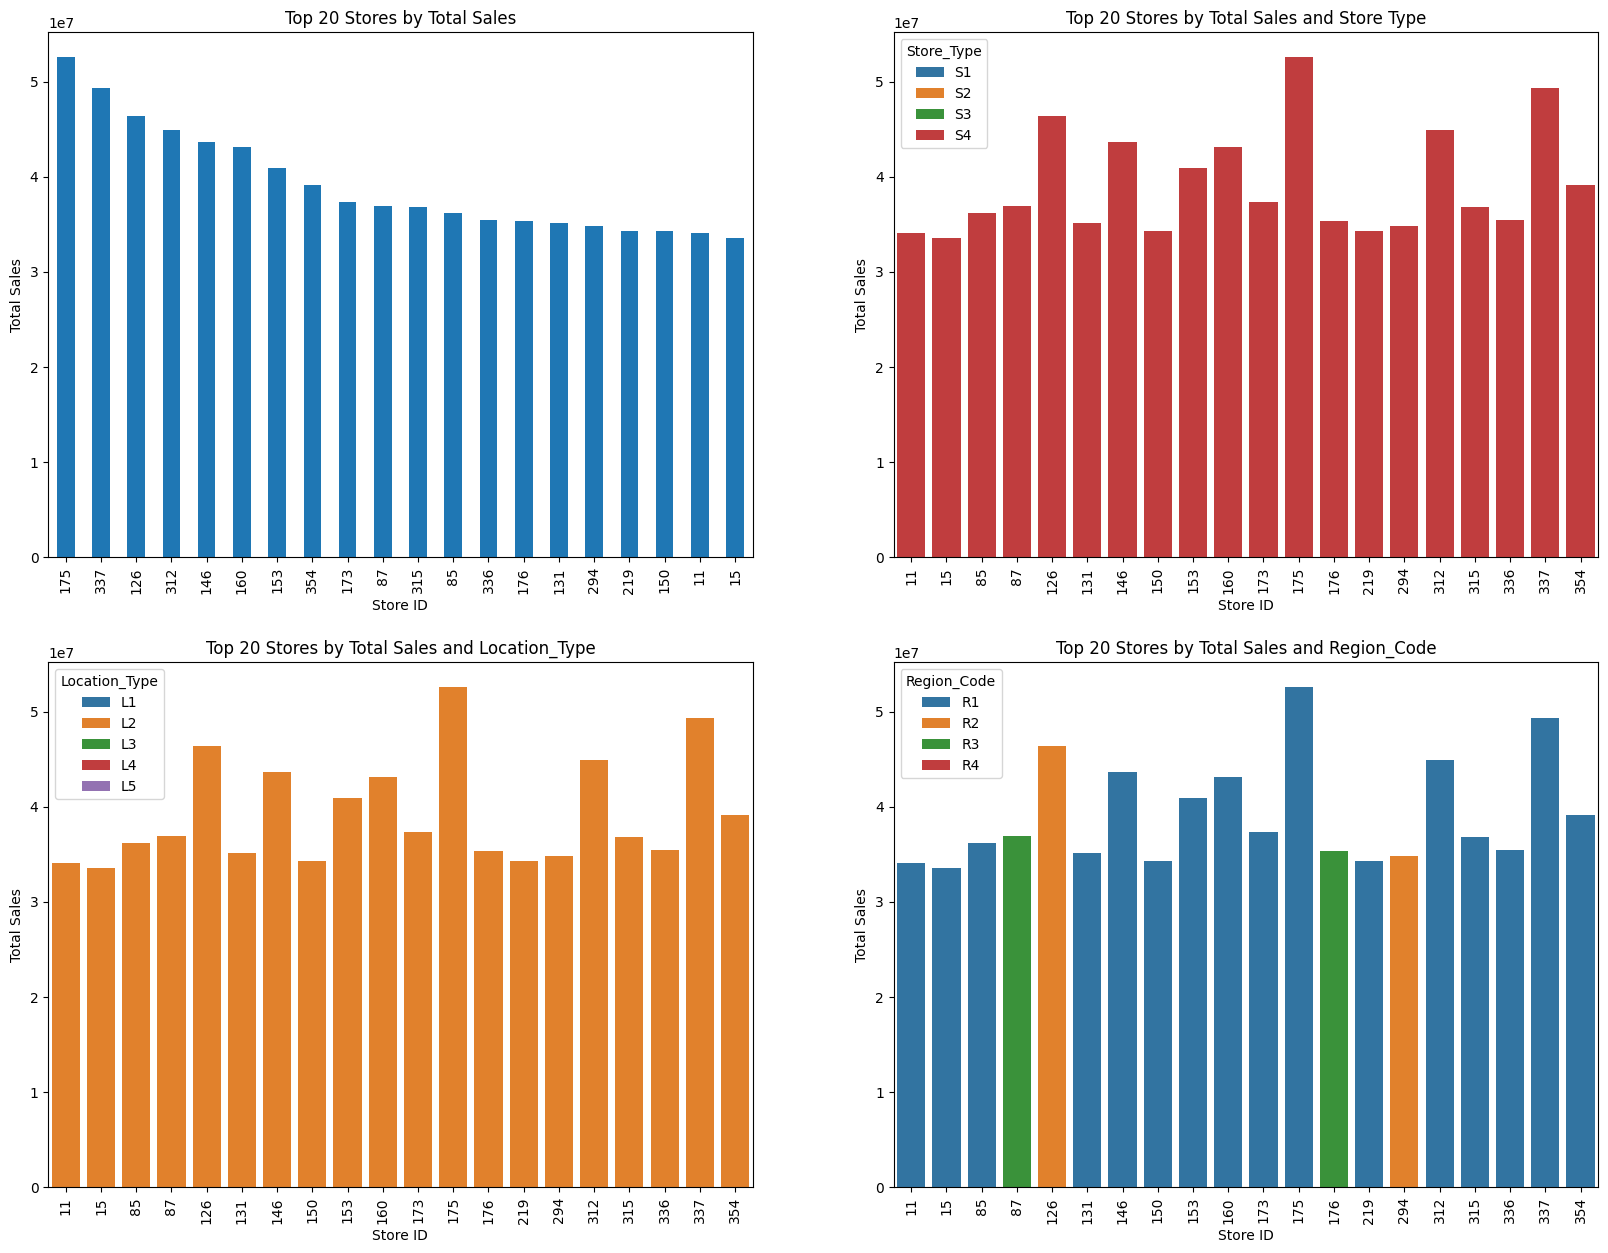

In [19]:
#Top 20 store Id's
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
df.groupby('Store_id')['Sales'].sum().sort_values(ascending=False).head(20).plot(kind='bar', ax=ax[0,0])
plt.sca(ax[0,0])
plt.title('Top 20 Stores by Total Sales')
plt.xlabel('Store ID')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)

#Top 20 store Id's by Sales, colored by Store Type
top_20_stores = df.groupby(['Store_id', 'Store_Type'])['Sales'].sum().sort_values(ascending=False).head(20).reset_index()

sns.barplot(x='Store_id', y='Sales', hue='Store_Type', data=top_20_stores, dodge=False, ax=ax[0,1])
plt.sca(ax[0,1])
plt.title('Top 20 Stores by Total Sales and Store Type')
plt.xlabel('Store ID')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)

#Top 20 store Id's by Sales, colored by Location_Type
top_20_stores = df.groupby(['Store_id', 'Location_Type'])['Sales'].sum().sort_values(ascending=False).head(20).reset_index()

sns.barplot(x='Store_id', y='Sales', hue='Location_Type', data=top_20_stores, dodge=False, ax=ax[1,0])
plt.sca(ax[1,0])
plt.title('Top 20 Stores by Total Sales and Location_Type')
plt.xlabel('Store ID')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)

#Top 20 store Id's by Sales, colored by Region_Code
top_20_stores = df.groupby(['Store_id', 'Region_Code'])['Sales'].sum().sort_values(ascending=False).head(20).reset_index()

sns.barplot(x='Store_id', y='Sales', hue='Region_Code', data=top_20_stores, dodge=False, ax=ax[1,1])
plt.sca(ax[1,1])
plt.title('Top 20 Stores by Total Sales and Region_Code')
plt.xlabel('Store ID')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)

plt.show()

The Store_id named 175, 337, 126 and 312 are some of the store_id's with highest sales. In the second picture, Interestingly, all of the top 20 highest-performing stores in terms of sales belong to Store Type S4. The third plot reveals an important insight is that the top-performing stores are exclusively located in L2. The last figure shows that the best-performing stores are primarily concentrated in Region Code 1, with Region Codes 2 and 3 also represented by two stores each, while Region Code 4 does not appear at all among the top performers.

<H3><font color='red'>Ambiguity Check</font></H3>
The second and third graphs introduce a slight ambiguity. While these plots indicate that the top-performing stores belong to Store Type S4 and Location Type L2, our earlier analysis showed that Store Type S1 and Location Type L1 record the highest overall sales. Take a look at the following image (Screenshot of an above graph)

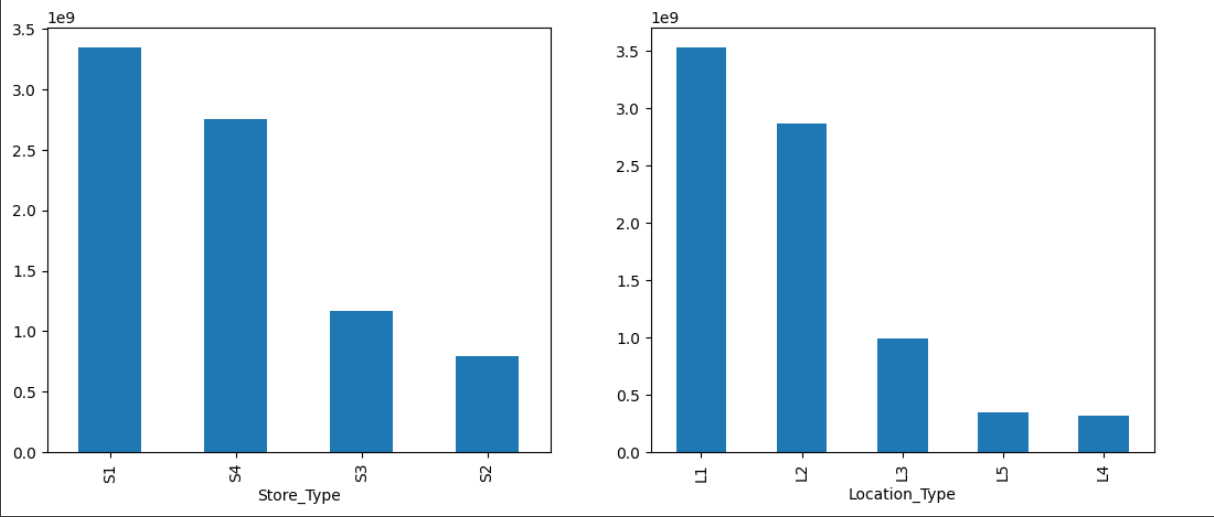
Now the question is,

<B>Why do the top-performing stores belong to Store Type S4 and Location L2, even though Store Type S1 and Location L1 record the highest overall sales?</B>

<H3><font color='green'>Root Cause Analysis</font><H3>

This anomaly can only be explained by one thing and that is per store sales. To initiate this first we will group the data based on location type or store type and then create 2 measures total_sales and store_count (number of uniques stores) and then calculate efficiency total_sales/store_count. This is further analysed in the following cells.

In [20]:
#Location summary to understand why L2 has most of the top performing stores
loc_summary = (
    df.groupby('Location_Type')
      .agg(total_sales=('Sales','sum'),
           store_count=('Store_id','nunique'))
      .assign(sales_per_store=lambda d: d.total_sales / d.store_count)
      .sort_values('sales_per_store', ascending=False)
)
loc_summary

total_sales  store_count  sales_per_store
Location_Type                                            
L2             2.872964e+09           94     3.056344e+07
L1             3.529359e+09          165     2.139006e+07
L3             9.897865e+08           58     1.706529e+07
L4             3.149745e+08           21     1.499879e+07
L5             3.509163e+08           27     1.299690e+07

In [21]:
#Store summary to understand why S4 has most of the top performing stores
store_summary = (
    df.groupby('Store_Type')
      .agg(total_sales=('Sales','sum'),
           store_count=('Store_id','nunique'))
      .assign(sales_per_store=lambda d: d.total_sales / d.store_count)
      .sort_values('sales_per_store', ascending=False)
)
store_summary

total_sales  store_count  sales_per_store
Store_Type                                            
S4          2.752946e+09           89     3.093197e+07
S3          1.165658e+09           48     2.428454e+07
S1          3.343866e+09          172     1.944108e+07
S2          7.955308e+08           56     1.420591e+07

Although L1 and S1 lead in overall sales volume, their larger store counts spread sales thinly across many outlets. In contrast, L2 and S4 stand out for efficiency, with each store delivering far higher sales on average. This explains why the top-performing stores consistently belong to L2 and S4 — they may be fewer in number, but they are far more productive on a per-store basis.

<H1><font color='Orange'>Handling Missing Values:</font><H1>

In [22]:
#To check for the null values in the product sales forecast dataset
df.isnull().sum()

ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
Order            0
Sales            0
dtype: int64

There's no missing values in the dataset.

<H1><font color='Orange'>Outlier Detection:</font><H1>

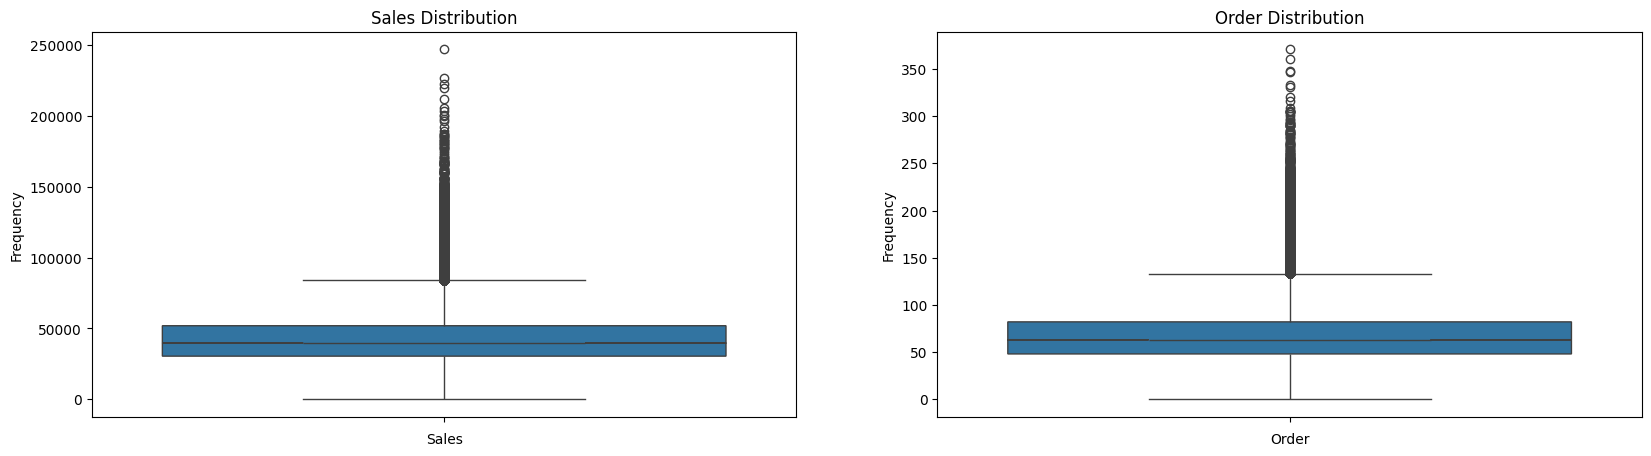

In [23]:
#Outlier detection for continous variables
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.boxplot(df["Sales"], notch=True, ax=ax[0])
plt.sca(ax[0])
plt.title("Sales Distribution")
plt.xlabel("Sales")
plt.ylabel("Frequency")
sns.boxplot(df["Order"], notch=True, ax=ax[1])
plt.sca(ax[1])
plt.title("Order Distribution")
plt.xlabel("Order")
plt.ylabel("Frequency")
plt.show()

The boxplot analysis of sales and orders highlights the central tendency, spread, and presence of outliers in the data. Most sales values cluster around ₹30,000–₹50,000, with a few significantly higher outliers beyond ₹100,000. Similarly, orders are concentrated between 50 and 80, with some exceptional cases exceeding 130. These outliers indicate rare but important high-volume transactions that can have a disproportionate impact on overall performance, making them valuable for forecasting and strategy planning.

In [24]:
#A funtion to detect the number of outliers above and below the thresholds
def find_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    # Define lower and upper thresholds for outliers
    lower_threshold = q1 - 1.5 * IQR
    upper_threshold = q3 + 1.5 * IQR
    # Identify outliers
    lower_outliers = df[(df < lower_threshold)]
    upper_outliers = df[(df > upper_threshold)]
    # Return the number of outliers above and below the thresholds
    return lower_outliers.size, upper_outliers.size, upper_outliers

In [25]:
#Total number of outliers present above and below. Finally, the overall presence of outliers in the product sales dataset
x, y, Sales_outliers_df = find_outliers_IQR(df['Sales'])
print("Sales Lower outliers : ", x)
print("Sales Upper outliers : ", y)
percentage_of_outliers = round((x+y)*100/df.shape[0],2)
print("Percentage of Sales outliers : ", percentage_of_outliers, "%")

x, y, Order_outliers_df = find_outliers_IQR(df['Order'])
print("Order Lower outliers : ", x)
print("Order Upper outliers : ", y)
percentage_of_outliers = round((x+y)*100/df.shape[0],2)
print("Percentage of Order outliers : ", percentage_of_outliers, "%")

Sales Lower outliers :  0
Sales Upper outliers :  5843
Percentage of Sales outliers :  3.1 %
Order Lower outliers :  0
Order Upper outliers :  7089
Percentage of Order outliers :  3.76 %


In [26]:
# Display rows from the original DataFrame where 'Sales' values are outliers
Sales_outliers = df.loc[Sales_outliers_df.index]
Sales_outliers.shape

(5843, 10)

In [27]:
# Display rows from the original DataFrame where 'Order' values are outliers
Order_outliers = df.loc[Order_outliers_df.index]
Order_outliers.shape

(7089, 10)

In [28]:
#Check if holiday has any impact on the sales and orders
print("\n------------------------------SALES-----------------------------------------------\n")
print(Sales_outliers.groupby('Holiday')['Sales'].count())
print("\n------------------------------ORDERS----------------------------------------------\n")
print(Order_outliers.groupby('Holiday')['Order'].count())


------------------------------SALES-----------------------------------------------

Holiday
0    5374
1     469
Name: Sales, dtype: int64

------------------------------ORDERS----------------------------------------------

Holiday
0    6525
1     564
Name: Order, dtype: int64


It seems like the holiday has no impact on sales and orders. Notably, sales and orders are high on non-holidays.

In [29]:
#Check if discounts has any impact on the sales and orders
print("\n------------------------------SALES-----------------------------------------------\n")
print(Sales_outliers.groupby('Discount')['Sales'].count())
print("\n------------------------------ORDERS----------------------------------------------\n")
print(Order_outliers.groupby('Discount')['Order'].count())


------------------------------SALES-----------------------------------------------

Discount
No     1570
Yes    4273
Name: Sales, dtype: int64

------------------------------ORDERS----------------------------------------------

Discount
No     2587
Yes    4502
Name: Order, dtype: int64


It seems like discount has skyrocket the orders and sales which is why we are seeing these outliers and this is a common phenomena.

<H3><font color='green'>Decision for capping boundary</font></H3>

During our exploratory data analysis, we identified the <u>presence of outliers in both Sales and Orders</u>. However, these <u>outliers</u> represent <u>only about 3% of the data</u>, which is relatively small. Since most <u>forecasting models are sensitive to extreme values</u>, it becomes necessary to address these outliers carefully without losing the integrity of the data.

On further analysis, we observed that these <u>outliers are not data errors but rather realistic events</u>, primarily occurring due to <u>discounts offered</u> by stores. These spikes reflect <u>genuine business behavior</u>, which means removing them entirely or capping too aggressively would risk losing valuable insights.

After evaluating multiple options, we recommend capping at the 99th percentile:

> Why not 50th percentile (median capping)? → This would overly compress the data, eliminating almost all variability beyond the median and making the model blind to higher sales scenarios.

> Why not 75th percentile? → This is still too restrictive and would cut off a significant portion of realistic high-sales values, especially during peak discount periods.

> Why not 95th percentile? → While better, this still removes too many valid high-sales observations, underestimating the true impact of discounts and seasonal demand spikes.

By contrast, <u>99th percentile capping trims only the most extreme outliers while preserving the realistic distribution of sales.</u> This ensures that models remain robust to outliers without losing critical business signals that drive peak sales performance.

Conclusion: Capping at the 99th percentile is the optimal choice for handling outliers in product sales forecasting. It balances model stability with data realism, ensuring that we capture both typical and peak business behavior.

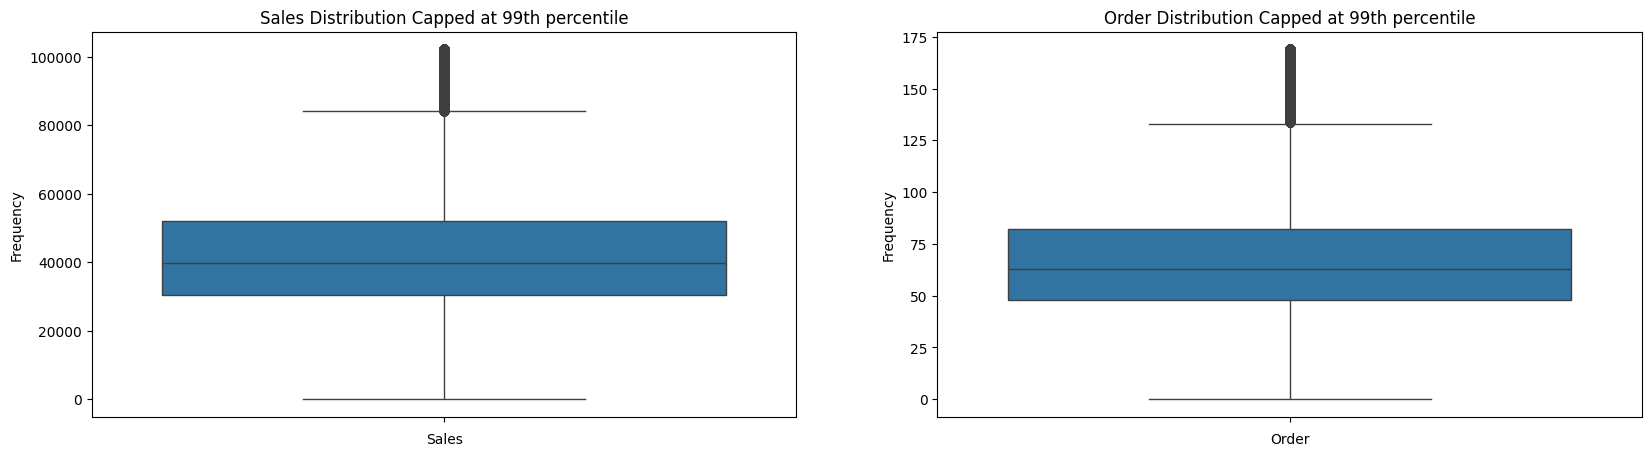

In [30]:
#capping outliers at 99th quantile
df['Sales'] = np.where(df['Sales']>df['Sales'].quantile(0.99),df['Sales'].quantile(0.99),df['Sales'])
df['Order'] = np.where(df['Order']>df['Order'].quantile(0.99),df['Order'].quantile(0.99),df['Order'])
#histogram for sales and orders
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.boxplot(df["Sales"], ax=ax[0])
plt.sca(ax[0])
plt.title("Sales Distribution Capped at 99th percentile")
plt.xlabel("Sales")
plt.ylabel("Frequency")

sns.boxplot(df["Order"], ax=ax[1])
plt.sca(ax[1])
plt.title("Order Distribution Capped at 99th percentile")
plt.xlabel("Order")
plt.ylabel("Frequency")
plt.show()

After capping at the 99th percentile, as shown in the above picture, the distributions become more balanced and representative, allowing the median and interquartile ranges to be clearly observed. This adjustment provides a more reliable view of typical sales and order behavior while minimizing the distortion caused by rare, extreme cases.

<H1><font color='orange'>Hypothesis Testing:</font><H3>

<H3><font color='orange'>Impact of Discounts on Sales:</font></H3>

H0 = Stores offering discounts have no higher sales compared to stores not offering discounts.

Ha = Stores offering discounts have significantly higher sales than stores not offering discounts.

In [31]:
#Partitioning the sales with discount given or not
Discount_Yes = df[df['Discount'] == "Yes"]['Sales']
Discount_No = df[df['Discount'] == "No"]['Sales']

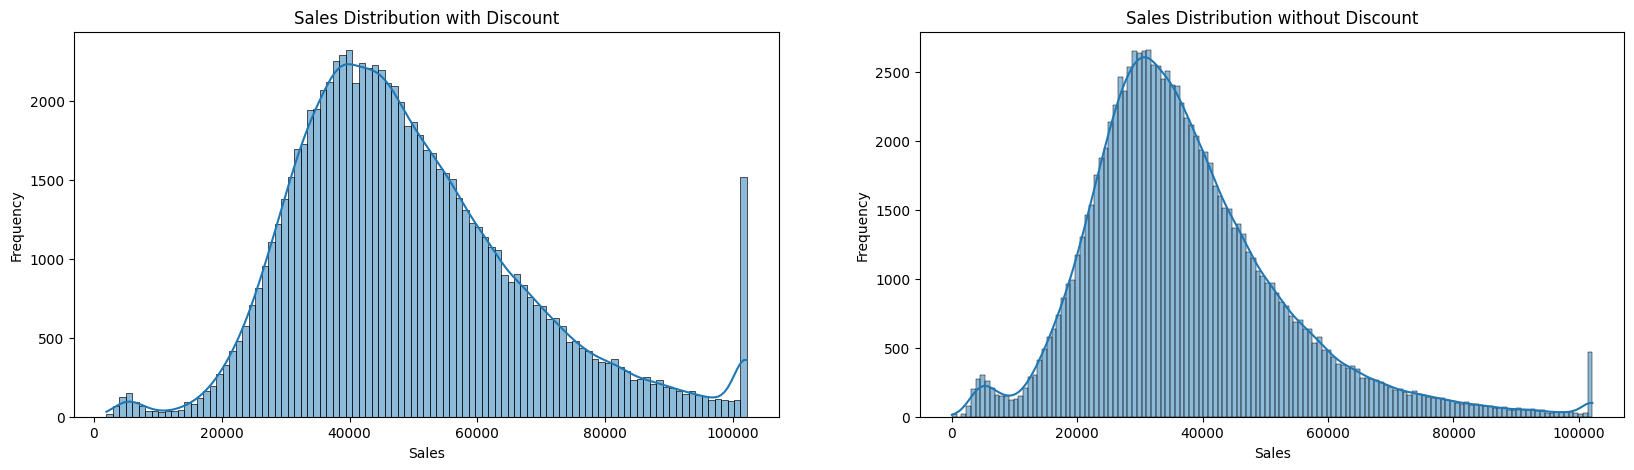

In [32]:
#Plotting a histogram for sales with discount given or not
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.histplot(Discount_Yes, kde=True, ax=ax[0])
plt.sca(ax[0])
plt.title("Sales Distribution with Discount")
plt.xlabel("Sales")
plt.ylabel("Frequency")

sns.histplot(Discount_No, kde=True, ax=ax[1])
plt.sca(ax[1])
plt.title("Sales Distribution without Discount")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

As we can see, sales distribution with/ without discount follows almost a gaussian distribution.

In [33]:
#t-test
tstat, p_value = ttest_ind(Discount_Yes, Discount_No, alternative='greater')

In [34]:
#Condition to accept or reject null hypothesis
if p_value < 0.05:
  print('t-statistic : ', tstat)
  print('p-value     : ', p_value)
  print('Reject H0   :  Stores offering discounts have significantly higher sales than stores not offering discounts.')
else:
  print('t-statistic : ', tstat)
  print('p-value     : ', p_value)
  print('Failed to reject H0 : Stores offering discounts have no higher sales compared to stores not offering discounts.')

t-statistic :  151.90934471427812
p-value     :  0.0
Reject H0   :  Stores offering discounts have significantly higher sales than stores not offering discounts.


In [35]:
#CI range of how much more sales discounts actually generate

# 1. Mean difference between groups
mean_diff = np.mean(Discount_Yes) - np.mean(Discount_No)

# 2. Standard error of the difference in means
se_diff = np.sqrt(np.var(Discount_Yes, ddof=1)/len(Discount_Yes) +
                  np.var(Discount_No, ddof=1)/len(Discount_No))

# 3. Confidence Interval using t-distribution
ci = t.interval(0.95, df=len(Discount_Yes)+len(Discount_No)-2,
                      loc=mean_diff, scale=se_diff)

# 4. Pooled standard deviation
std_pooled = np.sqrt(
    ((len(Discount_Yes)-1)*np.var(Discount_Yes, ddof=1) +
     (len(Discount_No)-1)*np.var(Discount_No, ddof=1)) /
    (len(Discount_Yes) + len(Discount_No) - 2)
)

cohen_d = mean_diff / std_pooled


print("Mean Difference:", mean_diff)
print("95% CI:", ci)
print("Cohen's d (effect size):", cohen_d)

Mean Difference: 11798.98963515227
95% CI: (np.float64(11644.605487589091), np.float64(11953.373782715447))
Cohen's d (effect size): 0.7039587208279762


A two-sample t-test was conducted to evaluate the effect of discounts on sales. Results indicate that stores offering discounts had significantly higher sales than those not offering discounts (t = 151.91, p < 0.001). The mean difference in sales was approximately 11,799, with a 95% confidence interval ranging from 11,645 to 11,953. This provides strong evidence that discounting strategies substantially increase sales performance. The effect size (Cohen’s d = 0.70) indicates a moderately strong practical impact — meaning discounts are not only statistically significant, but also meaningful in driving higher sales.

<H3><font color='orange'>Effect of Holidays on Sales:</font></H3>

H0 = Sales on holidays are not higher than sales on non-holidays.

Ha = Sales on holidays are higher compared to sales on non-holidays.

In [36]:
#Partitioning the sales with holiday given or not
Holiday_Yes = df[df['Holiday'] == 1]['Sales']
Holiday_No = df[df['Holiday'] == 0]['Sales']

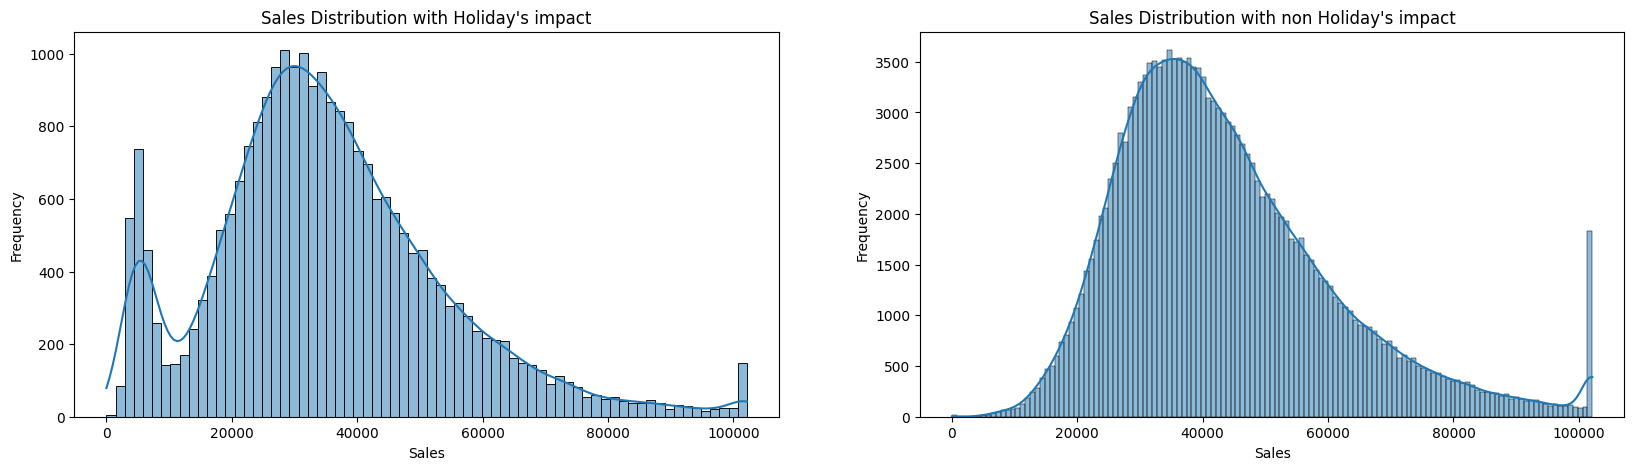

In [37]:
#Plotting a histogram for sales with discount given or not
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.histplot(Holiday_Yes, kde=True, ax=ax[0])
plt.sca(ax[0])
plt.title("Sales Distribution with Holiday's impact")
plt.xlabel("Sales")
plt.ylabel("Frequency")

sns.histplot(Holiday_No, kde=True, ax=ax[1])
plt.sca(ax[1])
plt.title("Sales Distribution with non Holiday's impact")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

As we can see, sales distribution on holiday's or non-holiday's follows almost a gaussian distribution.

In [38]:
#t-test
tstat, p_value = ttest_ind(Holiday_Yes, Holiday_No, alternative='greater')

In [39]:
alpha = 0.05
if p_value < alpha:
    if tstat > 0:
        print(f"t-statistic: {tstat:.2f}, p-value: {p_value:.4f}")
        print("Reject H0: Sales on holidays are significantly HIGHER than on non-holidays.")
    else:
        print(f"t-statistic: {tstat:.2f}, p-value: {p_value:.4f}")
        print("Reject H0: Sales on holidays are not higher than sales on non-holidays.")
else:
    print(f"t-statistic: {tstat:.2f}, p-value: {p_value:.4f}")
    print("Fail to reject H0: No significant difference.")

t-statistic: -69.93, p-value: 1.0000
Fail to reject H0: No significant difference.


The strongly negative t-statistic indicates the opposite direction—holiday sales are lower than non-holiday sales in this dataset. Thus, the directional claim (“higher on holidays”) is not supported.

<B>Running a two-tailed t-test for further clarification</B>

H0: No significant difference in sales between holidays and non-holidays.

Ha: There is a significant difference in sales between holidays and non-holidays.

In [40]:
# Two-tailed t-test (any difference)
tstat, p_value = ttest_ind(Holiday_Yes, Holiday_No, alternative='two-sided')

print("t-statistic:", tstat)
print("p-value:", p_value)

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject H0: There is a significant difference in sales between holidays and non-holidays.")
else:
    print("Fail to reject H0: No significant difference in sales between holidays and non-holidays.")

t-statistic: -69.92609616132995
p-value: 0.0
Reject H0: There is a significant difference in sales between holidays and non-holidays.


<H3><font color='orange'>Sales Differences Across Store Types: ANOVA/ Kruskal-Wallis test</font></H3>

In [41]:
#Checking how many store types are available and the frequencies of their presence
df['Store_Type'].value_counts()

Store_Type
S1    88752
S4    45924
S2    28896
S3    24768
Name: count, dtype: int64

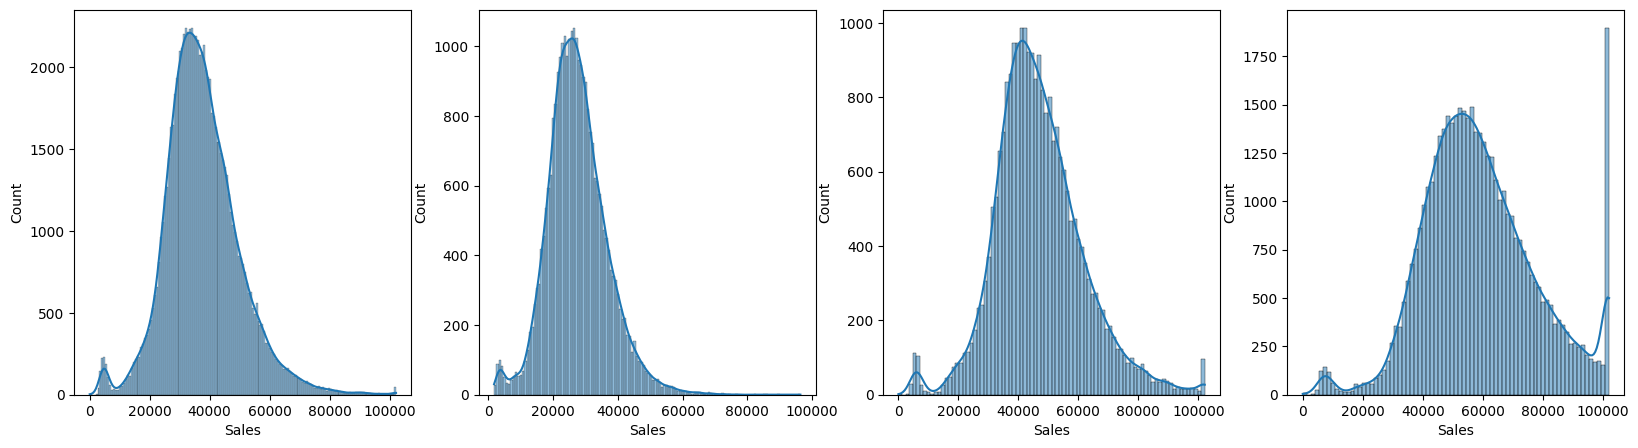

In [42]:
#Partitioning the sales for different store_types
Store_S1 = df[df['Store_Type'] == "S1"]['Sales']
Store_S2 = df[df['Store_Type'] == "S2"]['Sales']
Store_S3 = df[df['Store_Type'] == "S3"]['Sales']
Store_S4 = df[df['Store_Type'] == "S4"]['Sales']
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
sns.histplot(Store_S1, kde=True, ax=ax[0])
sns.histplot(Store_S2, kde=True, ax=ax[1])
sns.histplot(Store_S3, kde=True, ax=ax[2])
sns.histplot(Store_S4, kde=True, ax=ax[3])
plt.show()

<H3><font color='orange'>Assumptions of ANOVA 1 : Checking the data is Gaussian or Not</font></H3>

The histogram shows a normal distribution with slight fluctuation towards right. To confirm that the data is normally distributed we will go with <B><font color='orange'>shapiro wilk test for normality.</font></B>

H0 : Data is a normal distribution.

Ha : Data is not a normal distribution.

In [43]:
#Shapiro test for confirming the data is normal or not
np.random.seed(42)
Store_S1_samp = Store_S1.sample(100)
Store_S2_samp = Store_S2.sample(100)
Store_S3_samp = Store_S3.sample(100)
Store_S4_samp = Store_S4.sample(100)
sstat_1, p_value_1 = shapiro(Store_S1_samp)
sstat_2, p_value_2 = shapiro(Store_S2_samp)
sstat_3, p_value_3 = shapiro(Store_S3_samp)
sstat_4, p_value_4 = shapiro(Store_S4_samp)
print('s-statistic : ', sstat_1, sstat_2, sstat_3, sstat_4)
print('p-value     : ', p_value_1, p_value_2, p_value_3, p_value_4)

s-statistic :  0.9319765257628095 0.9344378454691684 0.9847697740707494 0.9453679914377427
p-value     :  6.454633535091482e-05 8.968567625140511e-05 0.30564546772894696 0.000416120708161618


In [44]:
#Condition to accept or reject null hypothesis
if p_value_1 < 0.05:
  print(p_value_1,"<",0.05,"Reject H0, Data is not a normal distribution.")
else:
  print(p_value_1,">",0.05,"Failed to reject H0, Data is a normal distribution.")
if p_value_2 < 0.05:
  print(p_value_2,"<",0.05,"Reject H0, Data is not a normal distribution.")
else:
  print(p_value_2,">",0.05,"Failed to reject H0, Data is a normal distribution.")
if p_value_3 < 0.05:
  print(p_value_3,"<",0.05,"Reject H0, Data is not a normal distribution.")
else:
  print(p_value_3,">",0.05,"Failed to reject H0, Data is a normal distribution.")
if p_value_4 < 0.05:
  print(p_value_4,"<",0.05,"Reject H0, Data is not a normal distribution.")
else:
  print(p_value_4,">",0.05,"Failed to reject H0, Data is a normal distribution.")

6.454633535091482e-05 < 0.05 Reject H0, Data is not a normal distribution.
8.968567625140511e-05 < 0.05 Reject H0, Data is not a normal distribution.
0.30564546772894696 > 0.05 Failed to reject H0, Data is a normal distribution.
0.000416120708161618 < 0.05 Reject H0, Data is not a normal distribution.


Assumption 1 failed due to the fact that data is not normally distributed.

<H3><font color='orange'>Assumptions of ANOVA 2 : Checking for the variance of the data is same or Not</font></H3>

H0 : Variance across the different groups are same.

Ha : Variance across the different groups are not same (different).

In [45]:
#Checking the assumption of ANOVA is true or Not : variance of all the groups are same or not
lstat, p_value = levene(Store_S1, Store_S2, Store_S3, Store_S4)

In [46]:
#Condition to accept or reject null hypothesis
if p_value < 0.05:
  print('l-statistic : ', lstat)
  print('p-value     : ', p_value)
  print("Reject H0, Variance across the different groups are not same (different).")
else:
  print('l-statistic : ', lstat)
  print('p-value     : ', p_value)
  print("Failed to reject H0, Variance across the different groups are same.")

l-statistic :  5149.218479366916
p-value     :  0.0
Reject H0, Variance across the different groups are not same (different).


Assumption 2 failed because of the fact that variance across the different groups are not the same.

H0 : The mean sales are equal across all store types.

Ha : At least one store type has a different mean sales volume compared to the others.

In [47]:
#Performing one-way ANOVA
fstat, p_value = f_oneway(Store_S1, Store_S2, Store_S3, Store_S4)
print('f-statistic: ', fstat)
print('p-value: ', p_value)

f-statistic:  36966.21150103236
p-value:  0.0


In [48]:
#conditions to accept or reject null hypothesis
if p_value < 0.05:
  print("Reject H0 : At least one store type has a different mean sales volume compared to the others.")
else:
  print("Failed to reject H0 : The mean sales are equal across all store types.")

Reject H0 : At least one store type has a different mean sales volume compared to the others.


In [49]:
#Kruskal wallis test
kstat, p_value = kruskal(Store_S1, Store_S2, Store_S3, Store_S4)
print('k-statistic : ', kstat)
print('p-value     : ', p_value)

k-statistic :  73676.44640736557
p-value     :  0.0


In [50]:
#conditions to accept or reject null hypothesis
if p_value < 0.05:
  print("Reject H0 : At least one store type has a different mean sales volume compared to the others.")
else:
  print("Failed to reject H0 : The mean sales are equal across all store types.")

Reject H0 : At least one store type has a different mean sales volume compared to the others.


We have completed both one-way ANOVA and Kruskal wallis test to confirm that at least one store type has a different mean sales volume compared to the others.

<H3><font color='orange'>Regional Sales Variability: ANOVA/ Kruskal-Wallis test</font></H3>

In [51]:
#Checking how many region codes are available and the frequencies of their presence
df['Region_Code'].value_counts()

Region_Code
R1    63984
R2    54180
R3    44376
R4    25800
Name: count, dtype: int64

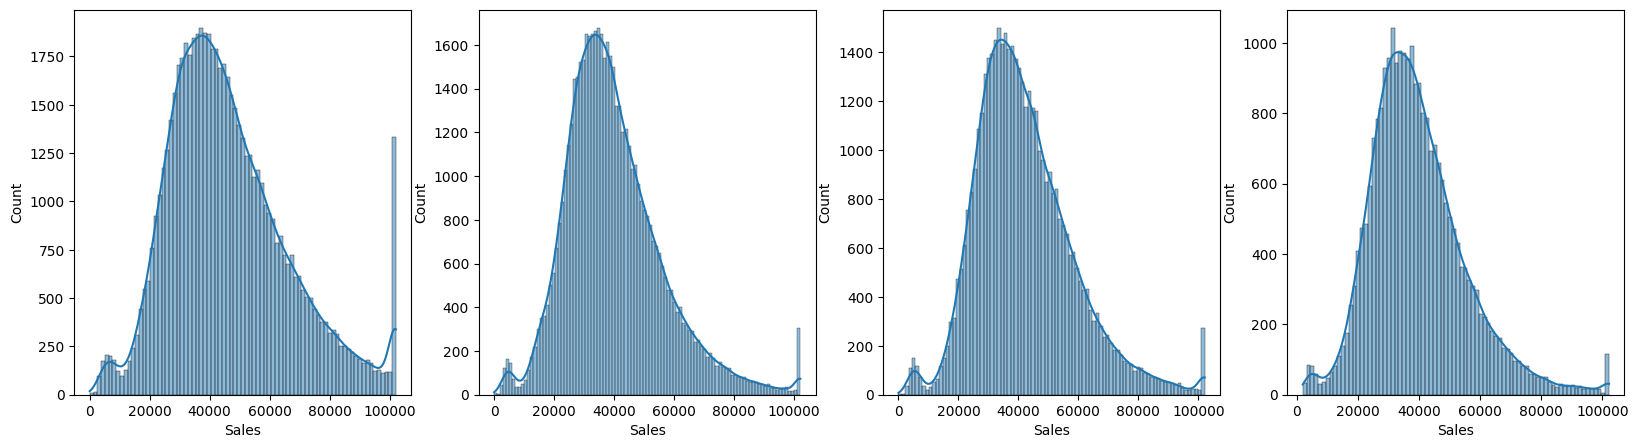

In [52]:
#Checking for data normality for these region codes
Region_R1 = df[df['Region_Code'] == "R1"]['Sales']
Region_R2 = df[df['Region_Code'] == "R2"]['Sales']
Region_R3 = df[df['Region_Code'] == "R3"]['Sales']
Region_R4 = df[df['Region_Code'] == "R4"]['Sales']
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
sns.histplot(Region_R1, kde=True, ax=ax[0])
sns.histplot(Region_R2, kde=True, ax=ax[1])
sns.histplot(Region_R3, kde=True, ax=ax[2])
sns.histplot(Region_R4, kde=True, ax=ax[3])
plt.show()

<H3><font color='orange'>Assumptions of ANOVA 1 : Checking the data is Gaussian or Not</font></H3>

The histogram shows a normal distribution with slight fluctuation towards right. To confirm that the data is normally distributed we will go with <B><font color='orange'>shapiro wilk test for normality.</font></B>

H0 : Data is a normal distribution.

Ha : Data is not a normal distribution.

In [53]:
#Shapiro - test
np.random.seed(42)
Region_R1_samp = Region_R1.sample(100)
Region_R2_samp = Region_R2.sample(100)
Region_R3_samp = Region_R3.sample(100)
Region_R4_samp = Region_R4.sample(100)
sstat_1, p_value_1 = shapiro(Region_R1_samp)
sstat_2, p_value_2 = shapiro(Region_R2_samp)
sstat_3, p_value_3 = shapiro(Region_R3_samp)
sstat_4, p_value_4 = shapiro(Region_R4_samp)
print('s-statistic : ', sstat_1, sstat_2, sstat_3, sstat_4)
print('p-value     : ', p_value_1, p_value_2, p_value_3, p_value_4)

s-statistic :  0.9259978510286774 0.9785857128538658 0.9303262898408949 0.9322062080817884
p-value     :  2.9715122455205568e-05 0.10307905283617863 5.193739536052369e-05 6.654208293002914e-05


In [54]:
#Condition to accept or reject null hypothesis
if p_value_1 < 0.05:
  print(p_value_1,"<",0.05,"Reject H0, Data is not a normal distribution.")
else:
  print(p_value_1,">",0.05,"Failed to reject H0, Data is a normal distribution.")
if p_value_2 < 0.05:
  print(p_value_2,"<",0.05,"Reject H0, Data is not a normal distribution.")
else:
  print(p_value_2,">",0.05,"Failed to reject H0, Data is a normal distribution.")
if p_value_3 < 0.05:
  print(p_value_3,"<",0.05,"Reject H0, Data is not a normal distribution.")
else:
  print(p_value_3,">",0.05,"Failed to reject H0, Data is a normal distribution.")
if p_value_4 < 0.05:
  print(p_value_4,"<",0.05,"Reject H0, Data is not a normal distribution.")
else:
  print(p_value_4,">",0.05,"Failed to reject H0, Data is a normal distribution.")

2.9715122455205568e-05 < 0.05 Reject H0, Data is not a normal distribution.
0.10307905283617863 > 0.05 Failed to reject H0, Data is a normal distribution.
5.193739536052369e-05 < 0.05 Reject H0, Data is not a normal distribution.
6.654208293002914e-05 < 0.05 Reject H0, Data is not a normal distribution.


Assumption 1 failed due to the fact that data is not normally distributed.

<H3><font color='orange'>Assumptions of ANOVA 2 : Checking for the variance of the data is same or Not</font></H3>

Hypothesis Statement

H0 : Variance across the different groups are same.

Ha : Variance across the different groups are not same (different).

In [55]:
#Checking the assumption of ANOVA is true or Not : variance of all the groups are same or not
lstat, p_value = levene(Region_R1, Region_R2, Region_R3, Region_R4)

In [56]:
#Condition to accept or reject null hypothesis
if p_value < 0.05:
  print('l-statistic : ', lstat)
  print('p-value     : ', p_value)
  print("Reject H0, Variance across the different groups are not same (different).")
else:
  print('l-statistic : ', lstat)
  print('p-value     : ', p_value)
  print("Failed to reject H0, Variance across the different groups are same.")

l-statistic :  1222.7663174530958
p-value     :  0.0
Reject H0, Variance across the different groups are not same (different).


H0 : The mean sales are equal across all region codes.

Ha : At least one region code has a different mean sales volume compared to the others.

In [57]:
#Performing one-way ANOVA
fstat, p_value = f_oneway(Region_R1, Region_R2, Region_R3, Region_R4)
print('f-statistic: ', fstat)
print('p-value: ', p_value)

f-statistic:  1667.573560078426
p-value:  0.0


In [58]:
#conditions to accept or reject null hypothesis
if p_value < 0.05:
  print("Reject H0 : At least one region code has a different mean sales volume compared to the others.")
else:
  print("Failed to reject H0 : The mean sales are equal across all region codes.")

Reject H0 : At least one region code has a different mean sales volume compared to the others.


In [59]:
#Kruskal wallis test
kstat, p_value = kruskal(Region_R1, Region_R2, Region_R3, Region_R4)
print('k-statistic : ', kstat)
print('p-value     : ', p_value)

k-statistic :  3967.582737672153
p-value     :  0.0


In [60]:
#conditions to accept or reject null hypothesis
if p_value < 0.05:
  print("Reject H0 : At least one region code has a different mean sales volume compared to the others.")
else:
  print("Failed to reject H0 : The mean sales are equal across all region codes.")

Reject H0 : At least one region code has a different mean sales volume compared to the others.


We have completed both one-way ANOVA and Kruskal wallis test to confirm that at least one region code has a different mean sales volume compared to the others.

<H1><font color='orange'>Correlation between Number of Orders and Sales:</font></H1>

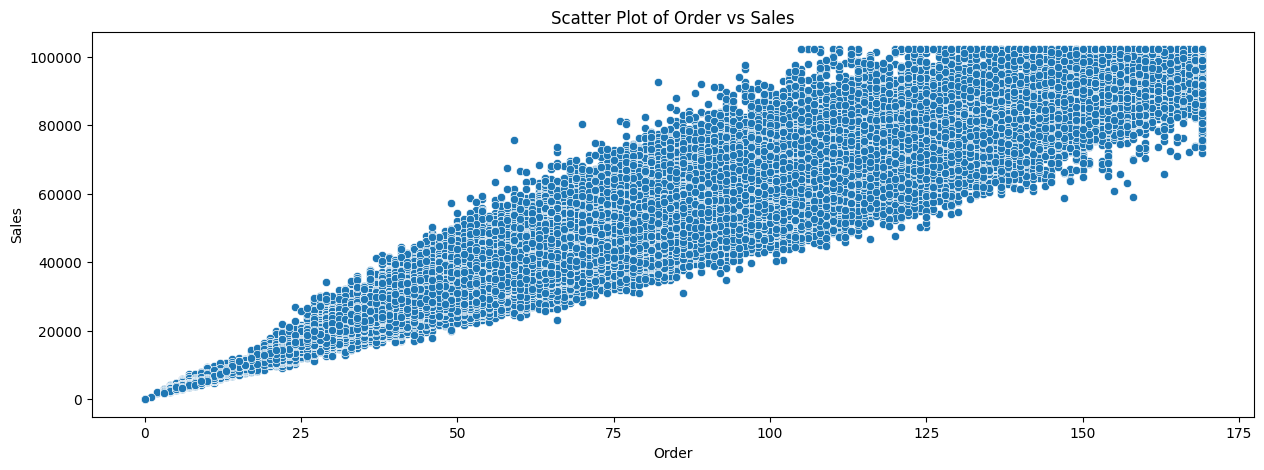

In [61]:
#Scatter plot to understand the distribution of the data
plt.figure(figsize=(15,5))
sns.scatterplot(x='Order', y='Sales', data=df)
plt.title('Scatter Plot of Order vs Sales')
plt.xlabel('Order')
plt.ylabel('Sales')
plt.show()

<H3><font color='orange'>Pearson Correlation and Spearman Correlation</font></H3>

From the above graph, we can conclude that <B><font color='orange'>Pearson correlation</font></B> is the most appropriate one for the Correlation between Number of Orders and Sales. However, we will also perform Spearman's correlation as well due to the fact that the data took a cone shaped form towards the right end of the plot.

H0 : There is no linear correlation between the number of orders and sales (ρ = 0).

Ha : There is a positive linear correlation between the number of orders and sales (ρ > 0).

In [62]:
# Pearson correlation
pearson_corr, pearson_pval = pearsonr(df['Order'], df['Sales'])
print("Pearson correlation:", pearson_corr)
print("Pearson p-value:", pearson_pval)
print("\n")
# Spearman correlation
spearman_corr, spearman_pval = spearmanr(df['Order'], df['Sales'])
print("Spearman correlation:", spearman_corr)
print("Spearman p-value:", spearman_pval)

Pearson correlation: 0.9410526741647087
Pearson p-value: 0.0


Spearman correlation: 0.9377441290486381
Spearman p-value: 0.0


There is a very strong and statistically significant positive correlation between the number of orders and sales (Pearson’s r = 0.94, Spearman’s ρ = 0.94, p < 0.001). This indicates that as the number of orders increases, sales also increase in a nearly linear manner, strongly supporting the hypothesis.

<H1><font color='orange'>Data Preprocessing</font><H1>

Dataset is free from null values, duplicate values and some minor inconsistancies such as data types has been fixed.

<H3><font color='orange'>Feature Engineering & Data Transformation</font></H3>

The feature engineering is a process of creating new features for enhancing the model performance. This way we can create more better and robust models. We are creating variables that are available for both train and test set, because our test data does not have the target column (Orders, Sales) in it.

In [63]:
#test data
df_test = pd.read_csv('/content/TEST_FINAL.csv')
df_test.head()

ID  Store_id Store_Type Location_Type Region_Code        Date  \
0  T1188341       171         S4            L2          R3  2019-06-01   
1  T1188342       172         S1            L1          R1  2019-06-01   
2  T1188343       173         S4            L2          R1  2019-06-01   
3  T1188344       174         S1            L1          R4  2019-06-01   
4  T1188345       170         S1            L1          R2  2019-06-01   

   Holiday Discount  
0        0       No  
1        0       No  
2        0       No  
3        0       No  
4        0       No

In [64]:
# Ensure sklearn pipeline outputs pandas DataFrames
set_config(transform_output="pandas")

# ------------------------------
# TRAINING DATA
# ------------------------------
X = df.copy()
y = df['Sales']

# Drop only irrelevant ID column
X.drop(columns=['ID'], inplace=True)
X['Store_Type'] = X['Store_Type'].astype('string')
X['Location_Type'] = X['Location_Type'].astype('string')
X['Region_Code'] = X['Region_Code'].astype('string')
X['Holiday'] = X['Holiday'].astype('int')
X['Discount'] = X['Discount'].astype('string')
X['Date'] = X['Date'].astype('string')
X['Order'] = X['Order'].astype('int64')
X['Sales'] = X['Sales'].astype('float64')


# ------------------------------
# TEST DATA (unseen)
# ------------------------------
unseen_data = df_test.copy()
unseen_data.drop(columns=['ID'], inplace=True, errors="ignore")

# ------------------------------
# PIPELINE DEFINITION
# ------------------------------
CAT_COLS = ["Store_Type", "Location_Type", "Region_Code", "Holiday", "Discount"]

pipeline = Pipeline(steps=[
    ("cast_types", DataTypeCaster()),   # ✅ ensures correct dtypes first
    ("calendar", CalendarFeatureEngineer()),
    ("aov", AOVFeatureMaker()),
    ("drop", ColumnDropper()),
    ("encode",    ColumnTransformer(
        transformers=[("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), CAT_COLS)],
        remainder="passthrough",
        verbose_feature_names_out=False   # 👈 no more "ohe__" / "remainder__"
    )),
    ("scale", MinMaxScaler())
])

# ------------------------------
# FIT PIPELINE ON TRAINING DATA
# ------------------------------
pipeline.fit(X)

# Save pipeline
with open("preprocessor.pkl", "wb") as f:
    pickle.dump(pipeline, f)

# ------------------------------
# TRANSFORM DATA
# ------------------------------
X_train_p = pipeline.transform(X)  # <-- Pandas DataFrame with clean column names
preprocessed_unseen_data = pipeline.transform(unseen_data)

# ------------------------------
# OUTPUT CHECK
# ------------------------------
print("Processed Training Columns:", X_train_p.columns.tolist())
print("Processed Training Shape:", X_train_p.shape)
print("Processed Test Shape:", preprocessed_unseen_data.shape)

Processed Training Columns: ['Store_Type_S1', 'Store_Type_S2', 'Store_Type_S3', 'Store_Type_S4', 'Location_Type_L1', 'Location_Type_L2', 'Location_Type_L3', 'Location_Type_L4', 'Location_Type_L5', 'Region_Code_R1', 'Region_Code_R2', 'Region_Code_R3', 'Region_Code_R4', 'Holiday_0', 'Holiday_1', 'Discount_No', 'Discount_Yes', 'Day_of_week', 'Month', 'Is_weekend', 'Is_month_end', 'Is_quarter_end', 'AOV_Store_id', 'AOV_Store_Type', 'AOV_Location_Type', 'AOV_Region_Code', 'AOV_Holiday', 'AOV_Discount']
Processed Training Shape: (188340, 28)
Processed Test Shape: (22265, 28)


In [65]:
#training data after preprocessing
X_train_p.head()

Store_Type_S1  Store_Type_S2  Store_Type_S3  Store_Type_S4  \
0            1.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            1.0   
2            0.0            0.0            1.0            0.0   
3            0.0            1.0            0.0            0.0   
4            0.0            1.0            0.0            0.0   

   Location_Type_L1  Location_Type_L2  Location_Type_L3  Location_Type_L4  \
0               0.0               0.0               1.0               0.0   
1               0.0               1.0               0.0               0.0   
2               0.0               1.0               0.0               0.0   
3               0.0               0.0               1.0               0.0   
4               0.0               0.0               1.0               0.0   

   Location_Type_L5  Region_Code_R1  ...  Month  Is_weekend  Is_month_end  \
0               0.0             1.0  ...    0.0         0.0           0.0   
1               0.0             1.0  ...    0.0         0.0           0.0   
2               0.0             1.0  ...    0.0         0.0           0.0   
3               0.0             1.0  ...    0.0         0.0           0.0   
4               0.0             0.0  ...    0.0         0.0           0.0   

   Is_quarter_end  AOV_Store_id  AOV_Store_Type  AOV_Location_Type  \
0             0.0      0.271274        0.667088           0.607766   
1             0.0      0.253566        0.000000           0.783256   
2             0.0      0.533354        0.530340           0.783256   
3             0.0      0.554031        1.000000           0.607766   
4             0.0      0.649452        1.000000           0.607766   

   AOV_Region_Code  AOV_Holiday  AOV_Discount  
0              0.0          0.0           1.0  
1              0.0          0.0           1.0  
2              0.0          0.0           1.0  
3              0.0          0.0           1.0  
4              1.0          0.0           1.0  

[5 rows x 28 columns]

In [66]:
#testing data after preprocessing
preprocessed_unseen_data.head()

Store_Type_S1  Store_Type_S2  Store_Type_S3  Store_Type_S4  \
0            0.0            0.0            0.0            1.0   
1            1.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            1.0   
3            1.0            0.0            0.0            0.0   
4            1.0            0.0            0.0            0.0   

   Location_Type_L1  Location_Type_L2  Location_Type_L3  Location_Type_L4  \
0               0.0               1.0               0.0               0.0   
1               1.0               0.0               0.0               0.0   
2               0.0               1.0               0.0               0.0   
3               1.0               0.0               0.0               0.0   
4               1.0               0.0               0.0               0.0   

   Location_Type_L5  Region_Code_R1  ...     Month  Is_weekend  Is_month_end  \
0               0.0             0.0  ...  0.454545         1.0           0.0   
1               0.0             1.0  ...  0.454545         1.0           0.0   
2               0.0             1.0  ...  0.454545         1.0           0.0   
3               0.0             0.0  ...  0.454545         1.0           0.0   
4               0.0             0.0  ...  0.454545         1.0           0.0   

   Is_quarter_end  AOV_Store_id  AOV_Store_Type  AOV_Location_Type  \
0             0.0      0.364198        0.000000           0.783256   
1             0.0      0.347502        0.667088           1.000000   
2             0.0      0.390503        0.000000           0.783256   
3             0.0      0.580510        0.667088           1.000000   
4             0.0      0.713881        0.667088           1.000000   

   AOV_Region_Code  AOV_Holiday  AOV_Discount  
0         0.782615          1.0           0.0  
1         0.000000          1.0           0.0  
2         0.000000          1.0           0.0  
3         1.000000          1.0           0.0  
4         0.541641          1.0           0.0  

[5 rows x 28 columns]

<H3><font color='orange'>Train-Test Split:</font></H3>

Since our original <B>test</B> (a.k.a unseen_data) data does not have the target column in it. We follow a simple train-test split on the given training dataset.

In [67]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_train_p, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((150672, 28), (37668, 28), (150672,), (37668,))

<H1><font color='orange'>ML Modeling : Part - 1</font></H1>

<H3><font color='orange'>Base Model: Linear Regression</font></H3>

In [68]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [69]:
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

In [70]:
def adjusted_r2(y_true, y_pred, X):
    r2 = r2_score(y_true, y_pred)
    n, p = X.shape
    return 1 - (1-r2)*(n-1)/(n-p-1)

def collect_metrics(name, y_train, y_train_pred, X_train, y_test, y_test_pred, X_test):
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test  = mean_absolute_error(y_test, y_test_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test  = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test  = np.sqrt(mse_test)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
    mape_test  = mean_absolute_percentage_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test  = r2_score(y_test, y_test_pred)
    adj_r2_train = adjusted_r2(y_train, y_train_pred, X_train)
    adj_r2_test  = adjusted_r2(y_test, y_test_pred, X_test)

    return {
        f"{name}_train": [mae_train,mse_train, rmse_train, mape_train, r2_train, adj_r2_train],
        f"{name}_test":  [mae_test,mse_test, rmse_test, mape_test, r2_test, adj_r2_test]
    }

In [71]:
results = {
    'metrics': ['MAE','MSE','RMSE','MAPE','R2_Score','Adj_R2_Score']
}
results.update(collect_metrics("Linear_regression", y_train, y_train_pred, X_train, y_test, y_test_pred, X_test))
df_results = pd.DataFrame(results)
print(df_results)
del results

        metrics  Linear_regression_train  Linear_regression_test
0           MAE             8.131250e+03            8.157907e+03
1           MSE             1.250626e+08            1.257675e+08
2          RMSE             1.118314e+04            1.121461e+04
3          MAPE             2.082420e+16            8.920827e+15
4      R2_Score             6.037369e-01            5.998581e-01
5  Adj_R2_Score             6.036632e-01            5.995604e-01


The linear regression model demonstrates consistent performance between training and test datasets, indicating it generalizes reasonably well. The Mean Absolute Error (MAE) is around 8,100, meaning predictions are on average off by that much in sales units. The Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) are large in scale (due to squaring), but consistent between train and test, which reinforces stability.

The R² score (approx. 0.60) and Adjusted R² score (approx. 0.60) suggest the model explains about 60% of the variation in sales, which is a moderate level of explanatory power. However, the MAPE values are extremely large (in the order of 10¹⁵–10¹⁶), which indicates instability when actual sales values are very small or zero (since division by small numbers inflates percentage errors).

Overall, while the model provides a stable baseline, improvements are needed to handle outliers and small-sales scenarios more robustly. Future iterations with advanced models (e.g., tree-based or regularized regressions) are expected to yield stronger predictive accuracy.

In [72]:
#Function to plot Regression plot
def reg_plot(y_test, y_test_pred):
  sns.regplot(x=y_test, y=y_test_pred, scatter_kws={'alpha':0.6, 'color':'blue'}, line_kws={"color":"red"})
  plt.xlabel("Actual Sales")
  plt.ylabel("Predicted Sales")
  plt.title("Regression Fit: Actual vs Predicted")
  plt.show()

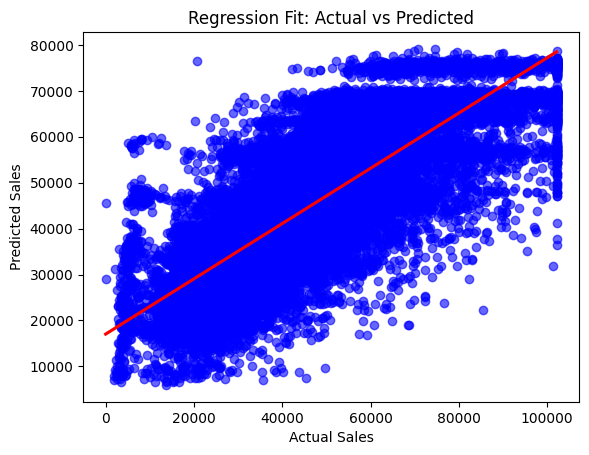

In [73]:
reg_plot(y_test, y_test_pred)

The plot shows the relationship between actual sales (x-axis) and predicted sales (y-axis) from our linear regression model. The red line represents the ideal fit where predictions would perfectly match actual values. While the overall trend aligns positively with the diagonal, the spread of blue points indicates that the model systematically underestimates higher sales values and has variability across lower ranges. This suggests that the linear regression model captures the general sales trend but struggles with precision, especially at the extremes of the sales distribution.

In [74]:
#Residual Plot
def residual_plot(y_test, y_test_pred):
  # 1) Calculate residuals
  residuals = y_test - y_test_pred

  # 2) Create residual plot
  plt.figure(figsize=(8,5))
  sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.6)
  plt.axhline(y=0, color='red', linestyle='--')  # reference line at zero
  plt.xlabel("Predicted Values")
  plt.ylabel("Residuals")
  plt.title("Residual Plot")
  plt.show()

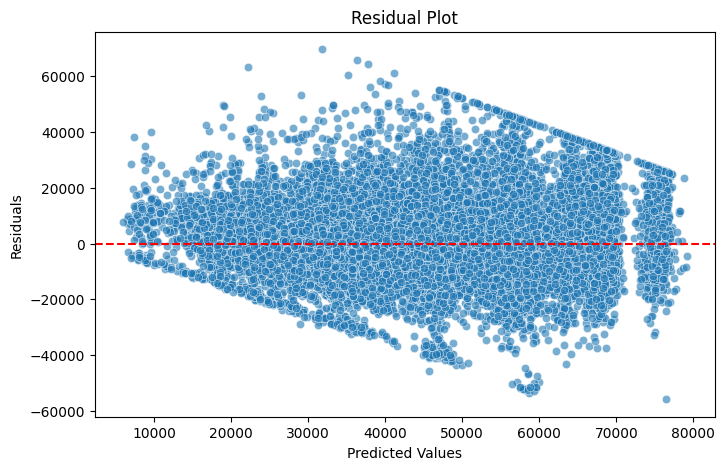

In [75]:
residual_plot(y_test, y_test_pred)

The residual plot shows that while the model predicts reasonably well on average, the error margin grows larger for stores or situations with higher sales volumes. This suggests the linear regression model struggles to capture complexity at the upper end of sales, and more sophisticated models (like tree-based methods) may be better suited.

In [76]:
# Performing the Goldfeld-Quandt test to check for heteroskedistic
H0 = "The data is not heteroskedistic"
Ha = "The data is heteroskedistic"
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(y_train, X_train)
lzip(name, test)

[('F statistic', np.float64(1.0021797280474838)),
 ('p-value', np.float64(0.3825558133929614))]

In [77]:
p_value=0.4320231694167188
if p_value < 0.05:
  print("Reject null hypothesis (Accept Ha) :",Ha)
else:
  print("Failed to reject null hypothesis (Accept H0) :",H0)

Failed to reject null hypothesis (Accept H0) : The data is not heteroskedistic


Although residuals appear to spread more at higher sales levels, statistical testing confirms that the variance is not significantly inconsistent — so our model assumptions are reasonably valid.

In [78]:
#Predicting data for unseen data
unseen_data_pred = linear_model.predict(preprocessed_unseen_data)

<H3><font color='orange'>Can we trust our linear regression model?</font></H3>

<H3><font color='orange'>KS-Test</font></H3>

H0 : The model predictions follow the same statistical distribution as the actual training data.

Ha : The model predictions do not follow the same distribution as the actual training data.

In [79]:
#KS-test
def ks_test(y_train, y_pred):
  stat, p_value = ks_2samp(y_train, unseen_data_pred)

  print(f"KS Statistic: {stat}, p-value: {p_value}")

  if p_value > 0.05:
      print("Failed to reject H0: Distributions are similar "
            "(model predictions are realistic).")
      return stat, p_value
  else:
      print("Reject H0: Distributions differ significantly "
            "(model predictions may be biased).")
      return stat, p_value

In [80]:
#Applying KS-Test
stat, p_value = ks_test(y_train, unseen_data_pred)

KS Statistic: 0.08573120289953468, p-value: 1.7293934892804662e-124
Reject H0: Distributions differ significantly (model predictions may be biased).


In [81]:
def plots_hist_cdf(y_train, unseen_data_pred, stat, p_value):

  # Create a figure with two subplots
  fig, ax = plt.subplots(1,2,figsize=(20, 5))

  plt.sca(ax[0])
  # Training sales CDF
  sorted_train = np.sort(y_train)
  cdf_train = np.arange(1, len(sorted_train)+1) / len(sorted_train)
  plt.plot(sorted_train, cdf_train, label="Training Sales CDF", color="blue")

  # Predicted sales CDF
  sorted_pred = np.sort(unseen_data_pred)
  cdf_pred = np.arange(1, len(sorted_pred)+1) / len(sorted_pred)
  plt.plot(sorted_pred, cdf_pred, label="Predicted Sales CDF", color="red")

  # Labels and title
  plt.title(f"KS-Test: Training vs Predicted Sales\nKS Stat={stat:.3f}, p-value={p_value:.3f}")
  plt.xlabel("Sales")
  plt.ylabel("Cumulative Probability")
  plt.legend()
  plt.grid(True, linestyle="--", alpha=0.6)

  plt.sca(ax[1])
  sns.histplot(y_train, color="blue", label="Training Sales", stat="density", kde=True, bins=50, alpha=0.5)
  sns.histplot(unseen_data_pred, color="red", label="Predicted Sales", stat="density", kde=True, bins=50, alpha=0.5)

  plt.title("Histogram: Training Sales vs Predicted Sales")
  plt.xlabel("Sales")
  plt.ylabel("Density")
  plt.legend()
  plt.show()

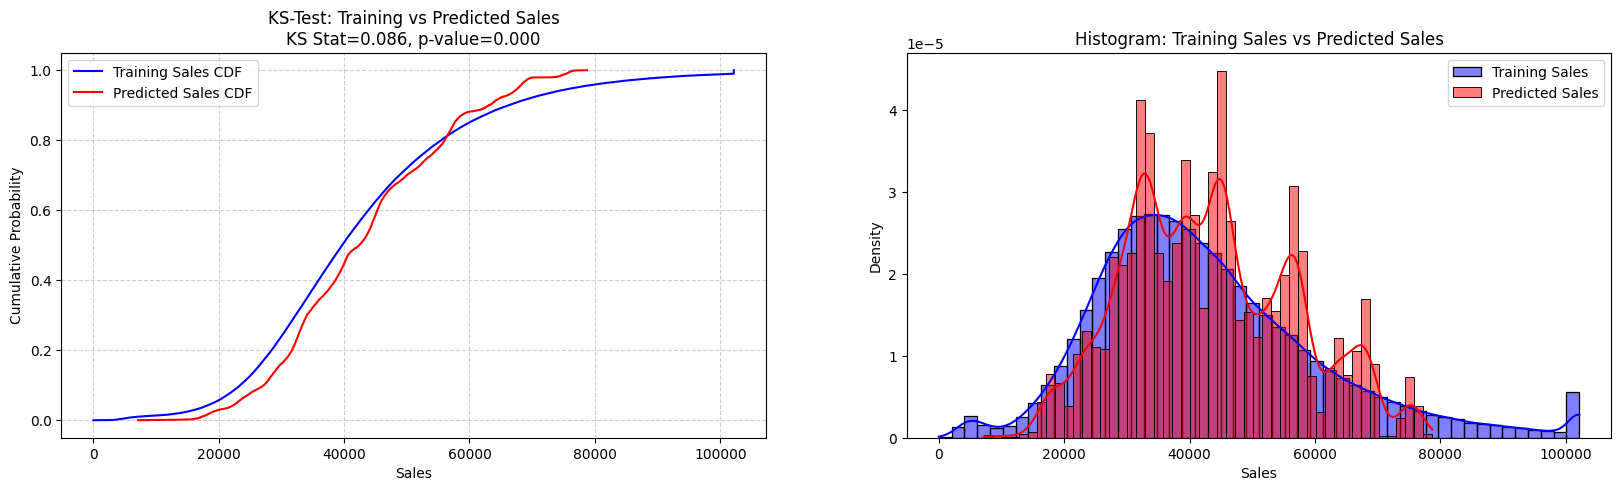

In [82]:
#Plots of histogram and cdfs
plots_hist_cdf(y_train, unseen_data_pred, stat, p_value)

The CDF-plot confirms that the predicted sales distribution differs significantly from the training data (p < 0.05), largely influenced by the large sample size. However, both the CDF and histogram show that the overall sales patterns are broadly captured. The model tends to slightly underestimate sales in the mid-range (20k–40k) while showing overestimation in the higher sales range (60k–80k). Despite statistical differences, the predicted distribution still reflects the general shape of the actual sales, suggesting the model is directionally reliable but needs refinement for extreme values.

<H1><font color='orange'>ML - Modelling : Part - 2</font></H1>

<H3><font color='orange'>Time Series Forecasting : SARIMA Model</font></H3>

Sales value often changes depending upon time. An interesting thing is that today's value is depended up on yesterday's value and yesterday's value depends on day before yesterday's value and so on. Forecasting, based on time-series can gives us the nature of sales happening over the time. In order to achieve the same, we use SARIMA model to begin our analysis.


In [83]:
#Displaying the timeseries dataset for forecasting
timeSeriesAnalysis_df.head()

ID  Store_id Store_Type Location_Type Region_Code        Date  \
0  T1000001         1         S1            L3          R1  2018-01-01   
1  T1000002       253         S4            L2          R1  2018-01-01   
2  T1000003       252         S3            L2          R1  2018-01-01   
3  T1000004       251         S2            L3          R1  2018-01-01   
4  T1000005       250         S2            L3          R4  2018-01-01   

   Holiday Discount  Order     Sales  
0        1      Yes      9   7011.84  
1        1      Yes     60  51789.12  
2        1      Yes     42  36868.20  
3        1      Yes     23  19715.16  
4        1      Yes     62  45614.52

In [84]:
#The dataset after dropping all the variables except Date and Sales column
timeSeries_df = timeSeriesAnalysis_df.drop(columns=["ID","Store_id","Store_Type","Location_Type","Region_Code","Order","Discount","Holiday"],axis=1)
timeSeries_df.head()

Date     Sales
0  2018-01-01   7011.84
1  2018-01-01  51789.12
2  2018-01-01  36868.20
3  2018-01-01  19715.16
4  2018-01-01  45614.52

The above table gives us an overview of sales, and it says that for each day we have multiple sales. Sales forecasting works on the principle that we need just a day and its corresponding sales value and as a result we need to aggregate the sales data.

In [85]:
#A funtion to detect the number of outliers above and below the thresholds for timeseries aggregaated data
def find_TS_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    # Define lower and upper thresholds for outliers
    lower_threshold = q1 - 1.5 * IQR
    upper_threshold = q3 + 1.5 * IQR
    # Identify outliers
    lower_outliers = df[(df < lower_threshold)]
    upper_outliers = df[(df > upper_threshold)]
    # Return the number of outliers above and below the thresholds
    return lower_outliers.size, upper_outliers.size, upper_outliers, lower_outliers

In [86]:
#Extracting TS data for outliers detection and its justifications
taDF = timeSeriesAnalysis_df.drop(columns=["ID","Store_id","Store_Type","Location_Type","Region_Code","Order"],axis=1)
taDF['Discount'] = taDF['Discount'].map({'Yes': 1, 'No': 0})
taDF['Discount'] = taDF['Discount'].astype(int)
taDF['Holiday'] = taDF['Holiday'].astype(int)
taDF.head()

Date  Holiday  Discount     Sales
0  2018-01-01        1         1   7011.84
1  2018-01-01        1         1  51789.12
2  2018-01-01        1         1  36868.20
3  2018-01-01        1         1  19715.16
4  2018-01-01        1         1  45614.52

Another important point to note is that sales data can fluctuate due to external factors such as inflation, the entry of a new competitor, and similar influences. In our dataset, we account for two such exogenous factors: Holiday and Discount. These variables can significantly shift sales values either upward or downward, depending on their impact.

In [87]:
#Grouping exogenous variable
Outlier_grouped_df = (
    taDF
    .groupby('Date')
    .agg({
        'Sales': 'sum',
        'Holiday': 'max',   # Global effect with holiday
        'Discount': 'max'   # Global effect with discount
    })
    .reset_index()
)

Outlier_grouped_df.head()

Date       Sales  Holiday  Discount
0  2018-01-01  15345484.5        1         1
1  2018-01-02  19592415.0        0         1
2  2018-01-03  18652527.0        0         1
3  2018-01-04  19956267.0        0         1
4  2018-01-05  22902651.0        0         1

Here, we group the data by Date to aggregate total daily sales, while capturing the maximum value of Holiday and Discount on each date, so that we can analyze the overall (global) impact of these exogenous factors on sales trends.

In [88]:
#Outlier detection and justification
low, high, v , w = find_TS_outliers_IQR(Outlier_grouped_df['Sales'])
print(f"Number of outliers above the upper threshold: {high}\n")
print(f"Number of outliers below the lower threshold: {low}\n")
print(f"Outliers above the upper threshold: \n{v}\n")
print(f"Outliers below the lower threshold: \n{w}\n")

Number of outliers above the upper threshold: 7

Number of outliers below the lower threshold: 7

Outliers above the upper threshold: 
27     24070617.0
124    24441480.0
180    23728515.0
181    23945358.0
187    24055308.0
376    24039663.0
488    26870817.0
Name: Sales, dtype: float64

Outliers below the lower threshold: 
60     2165458.29
226    7044249.21
310    1762137.57
311    2199778.29
312    2162866.47
358    2282733.00
444    1822462.17
Name: Sales, dtype: float64



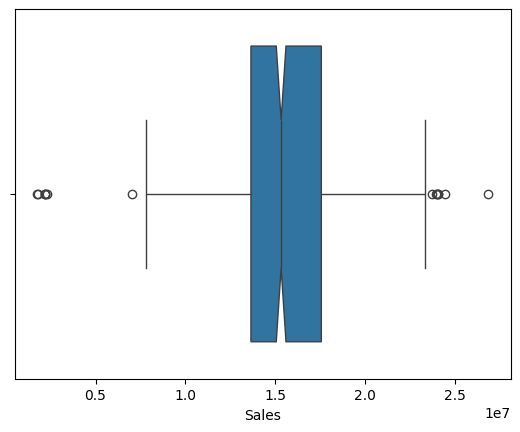

In [89]:
# Displaying outliers on the sales data after aggregating.
sns.boxplot(x=Outlier_grouped_df['Sales'], notch = True)
plt.show()

The boxplot shows that while most daily sales values fall within a consistent range, there are several high and low outliers that indicate unusual spikes or drops in sales activity.


In [90]:
#lower outliers and its justifications
low_out = Outlier_grouped_df.loc[w.index]
low_out

Date       Sales  Holiday  Discount
60   2018-03-02  2165458.29        1         1
226  2018-08-15  7044249.21        1         1
310  2018-11-07  1762137.57        1         1
311  2018-11-08  2199778.29        1         1
312  2018-11-09  2162866.47        1         1
358  2018-12-25  2282733.00        1         1
444  2019-03-21  1822462.17        1         1

Outliers below the lower threshold are observed, some of which overlap with holiday and discount periods. While this suggests a possible link, further investigation is needed to confirm whether the drop was caused by discounts, holidays, or other external factors such as shortages or restrictions.

In [91]:
# upper outliers and its justifications
high_out = Outlier_grouped_df.loc[v.index]
high_out

Date       Sales  Holiday  Discount
27   2018-01-28  24070617.0        0         1
124  2018-05-05  24441480.0        0         1
180  2018-06-30  23728515.0        0         1
181  2018-07-01  23945358.0        0         1
187  2018-07-07  24055308.0        0         1
376  2019-01-12  24039663.0        0         1
488  2019-05-04  26870817.0        0         1

The table highlights upper outliers in sales, and based on our t-test results, we can conclude that discount campaigns directly contributed to significant increases in sales during these periods.

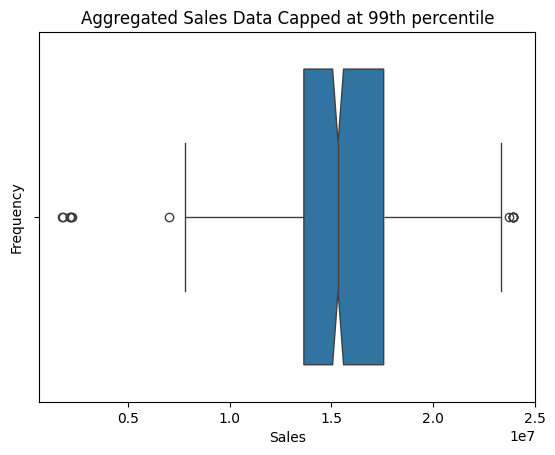

In [92]:
from typing import no_type_check
#capping outliers at 99th quantile
Outlier_grouped_df['Sales'] = np.where(Outlier_grouped_df['Sales']>Outlier_grouped_df['Sales'].quantile(0.99),Outlier_grouped_df['Sales'].quantile(0.99),Outlier_grouped_df['Sales'])

#histogram for sales and orders
sns.boxplot(Outlier_grouped_df["Sales"], notch=True, orient="h")
plt.title("Aggregated Sales Data Capped at 99th percentile")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

After capping aggregated sales data at the 99th percentile, the extreme high outliers have been reduced, allowing us to focus on the true sales distribution without distortion from rare spikes caused by discount campaigns or special events. We did not cap the lower outliers, since they may reflect genuine drops in sales due to external disruptions (such as stock shortages, curfews, or other restrictions), and retaining them helps us capture the full impact of such adverse conditions.

In [93]:
#Displaying the grouped data for sales after outlier capping.
seen_data = Outlier_grouped_df.drop(columns=["Holiday","Discount"],axis=1)
lstm_data = seen_data.copy() # Creating a copy for NN LSTM model
seen_data.head()

Date       Sales
0  2018-01-01  15345484.5
1  2018-01-02  19592415.0
2  2018-01-03  18652527.0
3  2018-01-04  19956267.0
4  2018-01-05  22902651.0

<H3><font color='orange'>Dickey fuller test to check time series stationarity</font></H3>

H0 : The series is Non-Stationary

Ha : The series is Stationary

In [94]:
#Dickey fuller test
result = sm.tsa.stattools.adfuller(seen_data['Sales'])
p_value = result[1]

if p_value <= 0.05:
    print("Time Series is Stationary")
    print("P_value is: ", p_value)
else:
    print("Time Series is NOT Stationary")
    print("P_value is: ", p_value)

Time Series is Stationary
P_value is:  0.008001873160350639


Since, our data is stationary we need not try to de-trend or de-seasonalise the data.

<H3><font color='orange'>Sesonal Decompose : Choosing Additive or multiplicative model</font><H3>

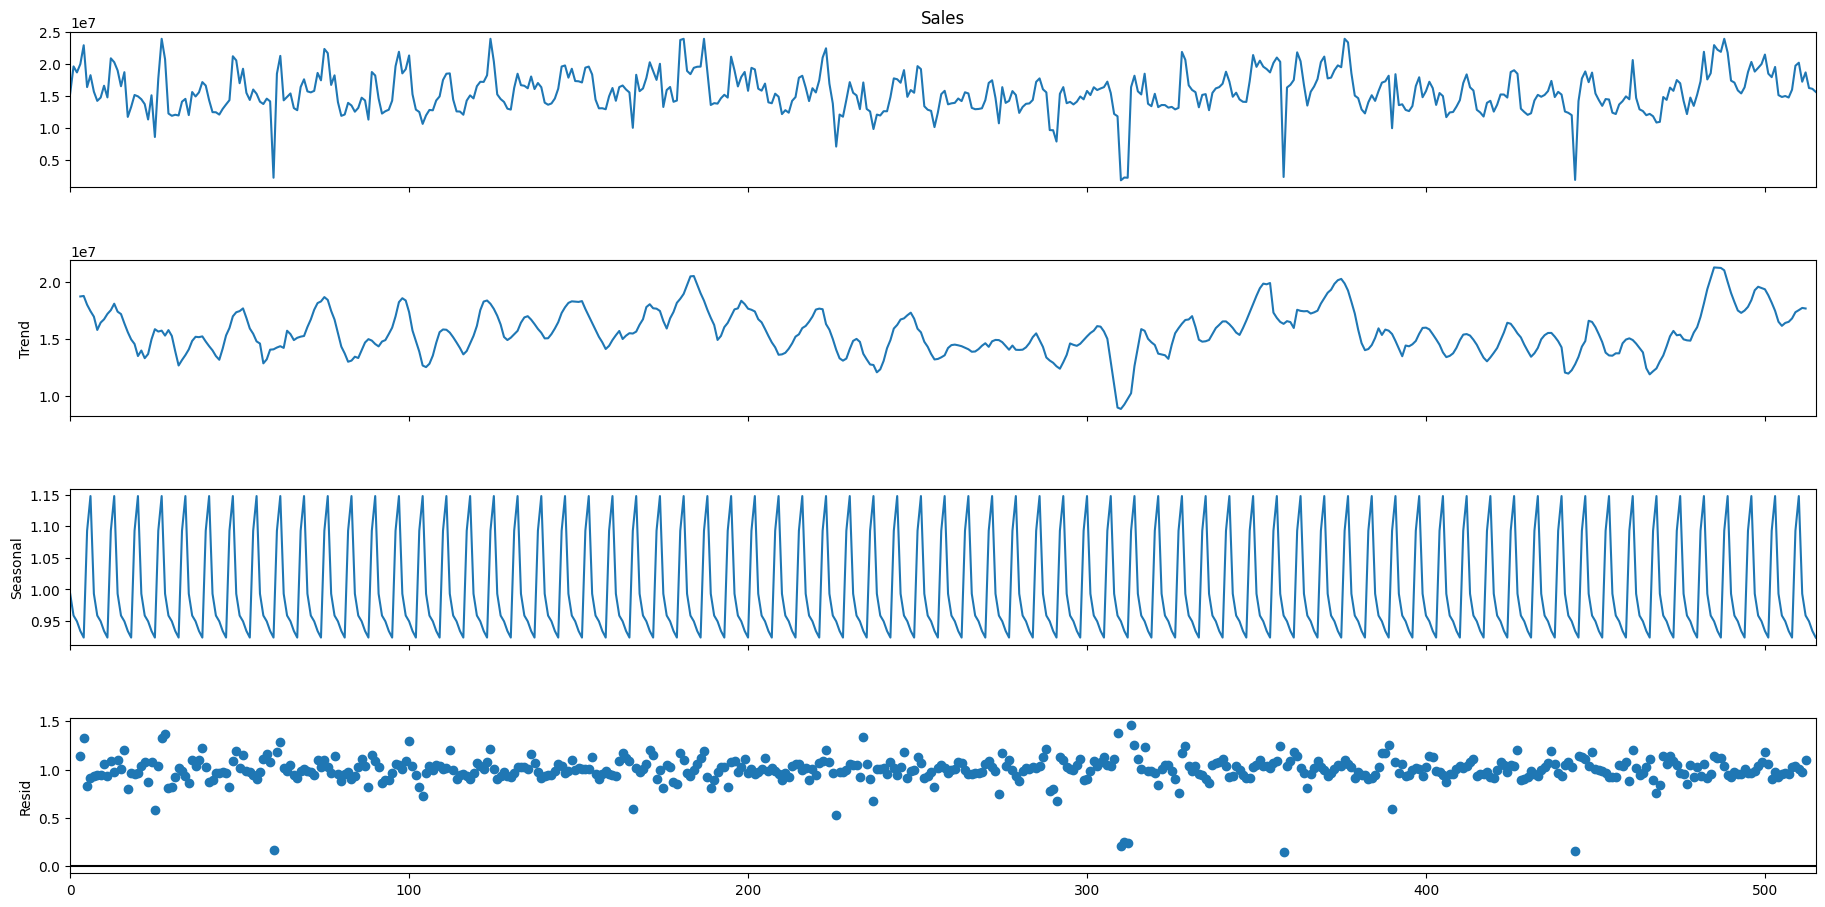

In [95]:
#Multiplicative model
result = seasonal_decompose(seen_data['Sales'], model='multiplicative', period = 7)
fig = result.plot()
fig.set_size_inches(20, 10)
plt.show()

Although, the product sales data consists of trend and seasonal component in it. Looking at the residuals, we can conclude that the values are not aligned to the 0 reference line. This suggests that the multiplicative model is not suitable for understanding the trend and seasonal component.

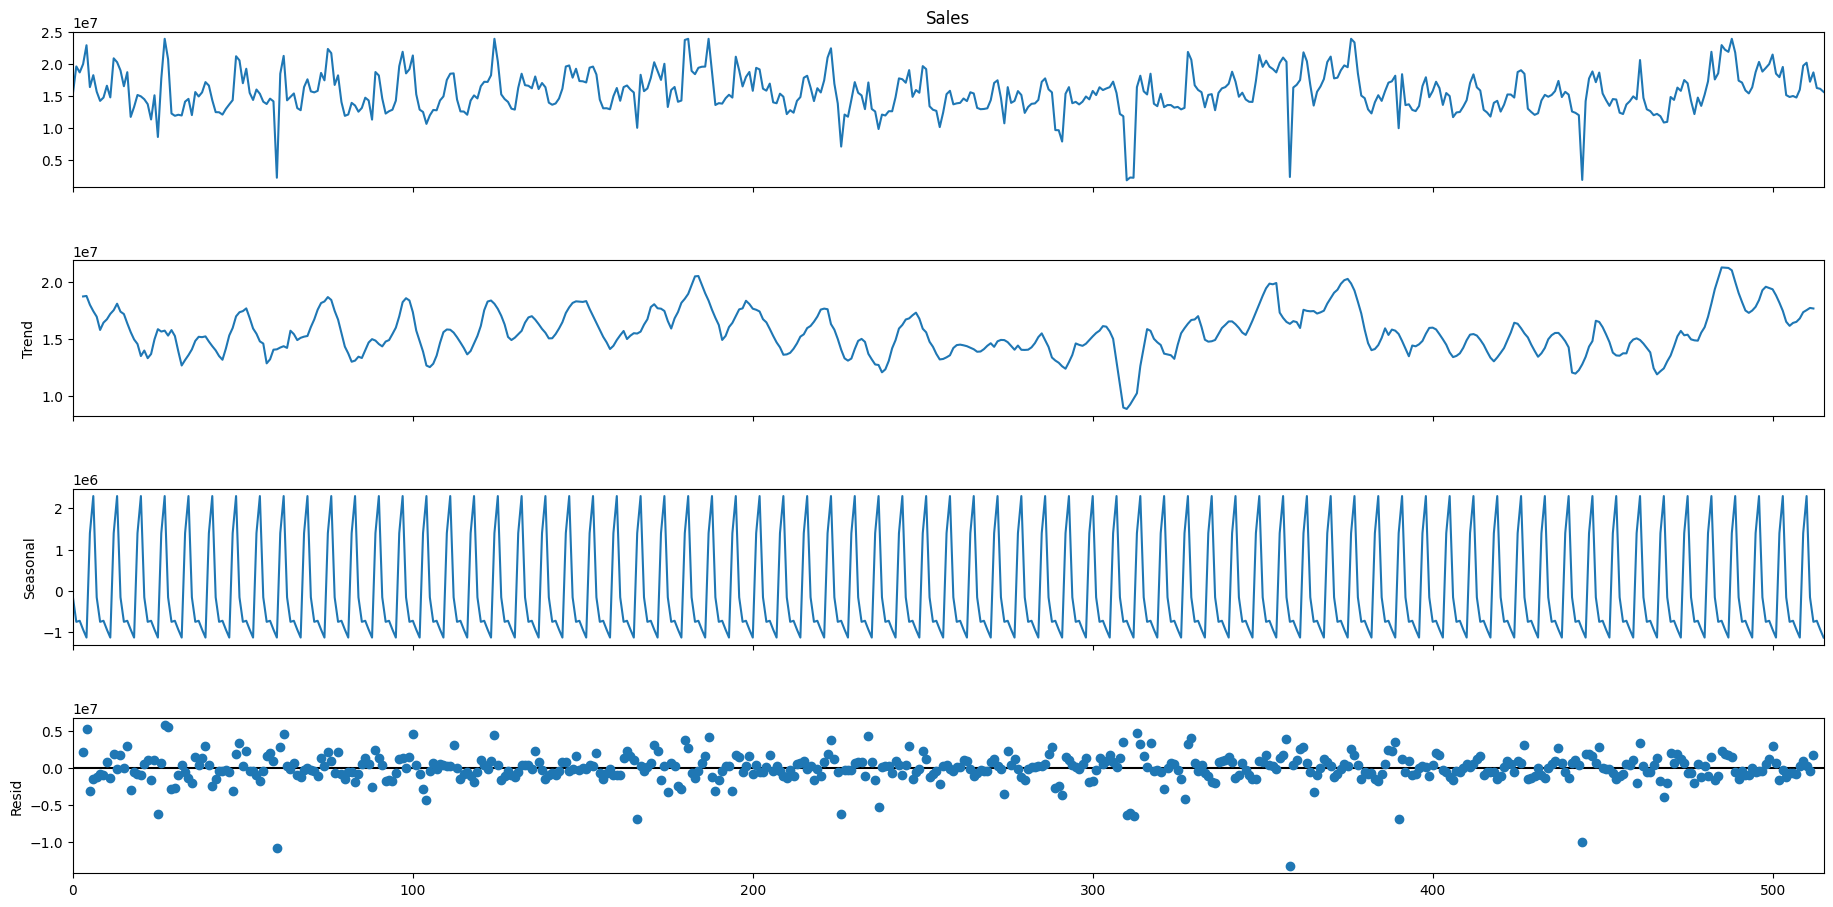

In [96]:
#Additive model
result = seasonal_decompose(seen_data['Sales'], model='additive', period = 7)
fig = result.plot()
fig.set_size_inches(20, 10)
plt.show()

Compared to multiplicative model, additive model residual values revolves around the 0 reference line. This suggests that most of the residuals drown to be 0.

Even though statistical tests suggest our sales data is stationary, decomposition shows clear seasonal patterns. Instead of forcing differencing now, we will allow the SARIMAX model to capture this seasonality explicitly. This avoids over-differencing and ensures that trend + seasonal cycles are modeled correctly.

<B>Parameter Selection</B> -> From the trend component in the seasonal decomposition, the series was not strictly stationary, so we allowed for zero or one order of differencing (d ∈ {0,1}) to capture possible trends. Similarly, because the decomposition revealed a strong weekly seasonal cycle, we fixed the seasonal period to 7 (s=7).

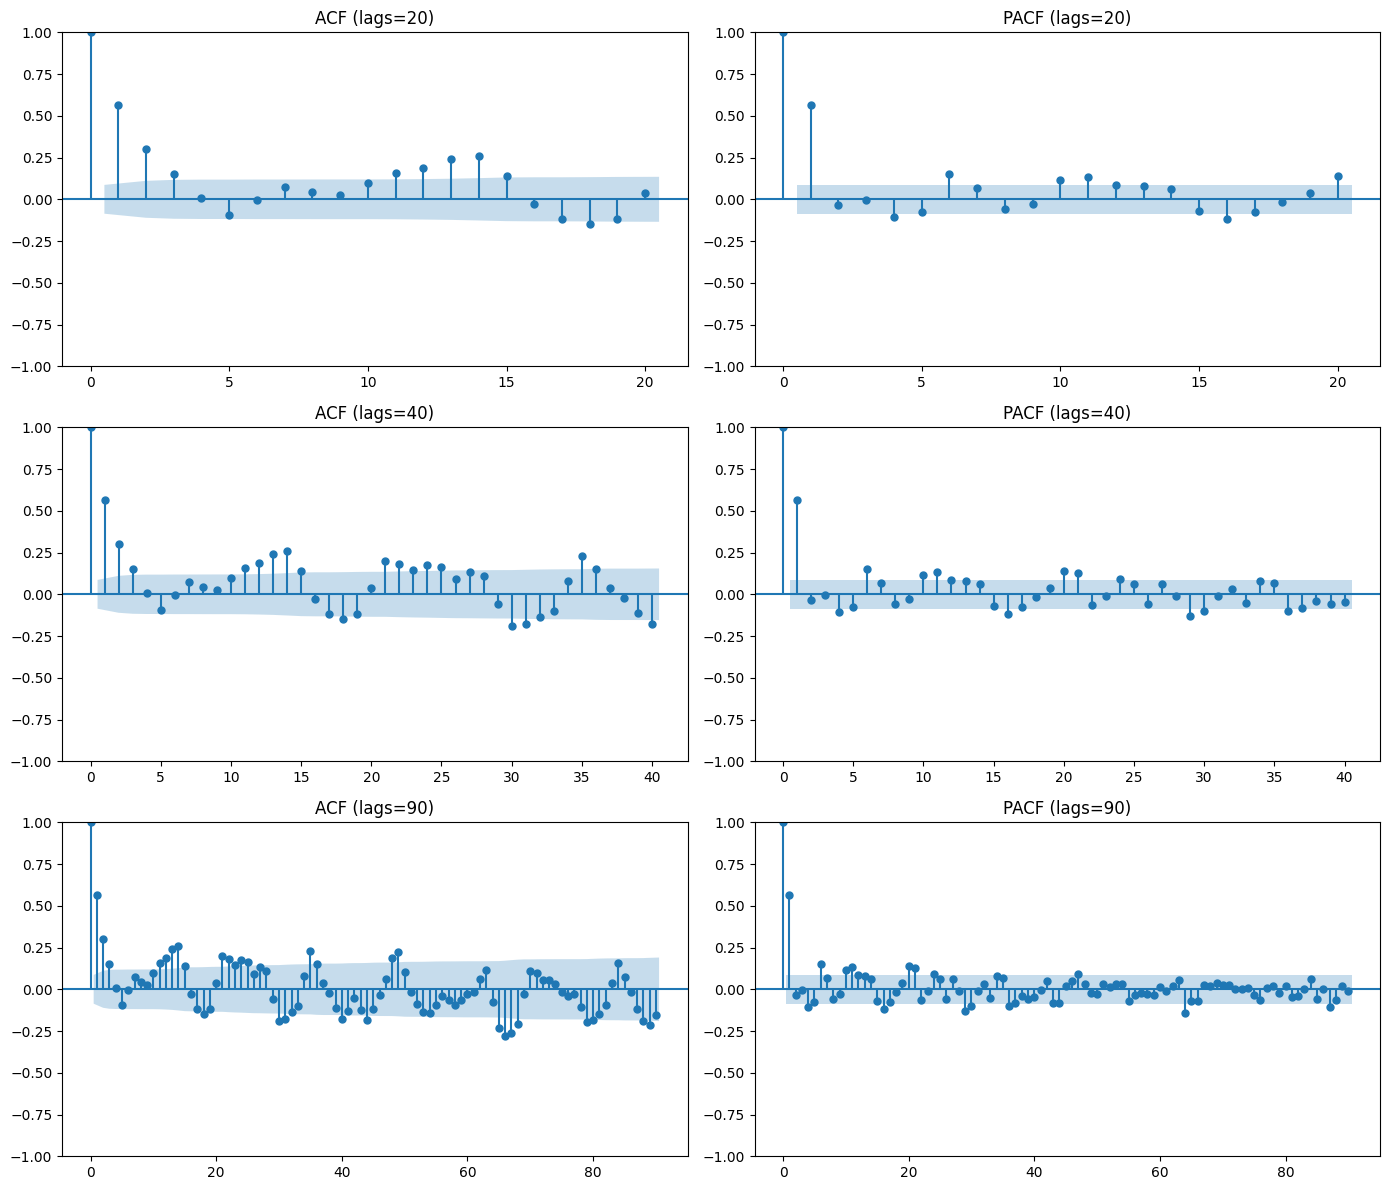

In [97]:
#Determination of the parameters p and q
lags_list = [20, 40, 90]
series = seen_data['Sales']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))

for r, lags in enumerate(lags_list):
    # ACF
    plot_acf(series, lags=lags, ax=axes[r, 0])
    axes[r, 0].set_title(f'ACF (lags={lags})')

    # PACF
    plot_pacf(series, lags=lags, ax=axes[r, 1])
    axes[r, 1].set_title(f'PACF (lags={lags})')

plt.tight_layout()
plt.show()

The selected parameter ranges for SARIMA hyperparameter tuning were guided by the ACF/PACF plots and the seasonal decomposition of the data. The PACF plots showed clear significance at lag 1 with smaller effects at higher lags, while the ACF plots exhibited a gradual decay pattern.

> This indicates that low-order autoregressive (p) and moving average (q) terms are sufficient, which is why we considered values between 0 and 2 for both.

> The seasonal ACF showed spikes at multiples of 7, suggesting the presence of seasonal autoregressive and moving average effects; however, these were relatively weak, so we restricted the seasonal AR (P) and seasonal MA (Q) terms to 0 or 1.

> Finally, to account for potential non-stationarity in seasonality, we also included seasonal differencing (D ∈ {0,1}). This approach balances model accuracy with simplicity by focusing on the most relevant and data-driven parameter ranges rather than exploring unnecessarily large grids.

<H3><font color='orange'>Cross-Validation and Hyperparameter selection for SARIMA</font></H3>

In this process, we would like to find out which are the best hyperparameters for time series model. This is then finalised for both SARIMA and SARIMAX models.

In [98]:
# # Define parameter ranges
# p = [0, 1, 2]
# d = [0, 1]
# q = [0, 1, 2]
# P = [0, 1]
# D = [0, 1]
# Q = [0, 1]
# s = [7]

# best_score = float("inf")
# best_params = None

# # TimeSeriesSplit for CV
# tscv = TimeSeriesSplit(n_splits=3)

# for param in itertools.product(p, d, q, P, D, Q, s):
#     order = (param[0], param[1], param[2])
#     seasonal_order = (param[3], param[4], param[5], param[6])

#     cv_scores = []

#     for train_index, test_index in tscv.split(seen_data['Sales']):
#         train, test = seen_data['Sales'].iloc[train_index], seen_data['Sales'].iloc[test_index]

#         try:
#             model = sm.tsa.SARIMAX(train, order=order, seasonal_order=seasonal_order,
#                                    enforce_stationarity=False, enforce_invertibility=False)
#             results = model.fit(disp=False)

#             forecast = results.forecast(len(test))
#             cv_scores.append(mean_squared_error(test, forecast))
#         except:
#             continue

#     avg_score = np.mean(cv_scores)

#     if avg_score < best_score:
#         best_score = avg_score
#         best_params = (order, seasonal_order)

# print("Best params:", best_params)
# print("Best CV MSE:", best_score)
# # Best params: ((2, 0, 1), (0, 1, 1, 7))
# # Best CV MSE: 9970208268558.838

In [99]:
#Calculation of time-series analysis metrics
def performance(actual, predicted, n_features):
    n = len(actual)
    r2 = r2_score(actual, predicted)
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - n_features - 1))

    fe = {'MAE' : round(mean_absolute_error(actual, predicted), 3),
          'MSE' : round(mean_squared_error(actual, predicted), 3),
          'RMSE': round(mean_squared_error(actual, predicted)**0.5, 3),
          'MAPE': round(mean_absolute_percentage_error(actual, predicted), 3),
          'R2_Score': round(r2, 3),
          'Adj_R2_Score' : round(adj_r2, 3)}

    return pd.DataFrame([fe])

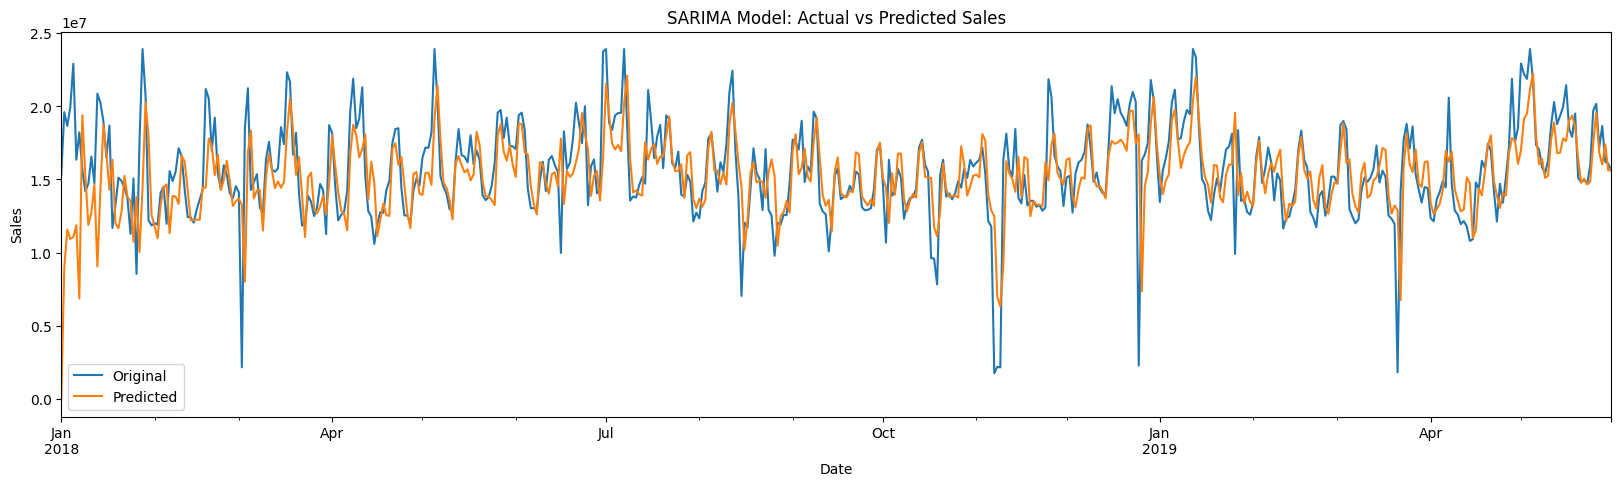

In [100]:
# Ensure Date is datetime and set as index
seen_data['Date'] = pd.to_datetime(seen_data['Date'])
seen_data = seen_data.set_index('Date')

# Fit SARIMA model
model = SARIMAX(seen_data['Sales'],
                order=(2,0,1),
                seasonal_order=(0,1,1,7),
                enforce_stationarity=True,
                enforce_invertibility=True)

model_fit = model.fit(disp=False)

# In-sample predictions
SalesPredict = model_fit.predict(dynamic=False)

# Plot with date on X-axis
plt.figure(figsize=(20,5), dpi=100)
seen_data['Sales'].plot(label='Original')
SalesPredict.plot(label='Predicted')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("SARIMA Model: Actual vs Predicted Sales")
plt.legend()
plt.show()

The chart compares the actual sales (blue) with the SARIMA model’s in-sample predictions (orange). The two lines closely follow each other, capturing both the weekly seasonality and the short-term fluctuations in sales. While there are small deviations during peak spikes and dips, the overall trend, seasonality, and variability are well represented. This indicates that the SARIMA model is a good fit for the historical data and provides a reliable foundation for forecasting future sales.

In [101]:
n_features = 2+1+0+1  # p+q+P+Q
fe = performance(seen_data['Sales'], SalesPredict,n_features)
fe

MAE           MSE         RMSE   MAPE  R2_Score  Adj_R2_Score
0  1852247.038  8.006938e+12  2829653.369  0.166      0.24         0.234

The SARIMA model achieves an average forecast error of ~16% (MAPE), with MAE of 1.86M and RMSE of 2.84M, which are reasonable given sales scale. It explains ~24% of sales variance, reflecting the complexity of external factors. Overall, it delivers reliable short-term forecasts but should be enhanced with external drivers (e.g., promotions, holidays) for better long-term accuracy.

<H3><font color='orange'>Residual Analysis Plot</font></H3>

This plot gives you the gist of how residuals vary according to the SARIMA time series forecast model.

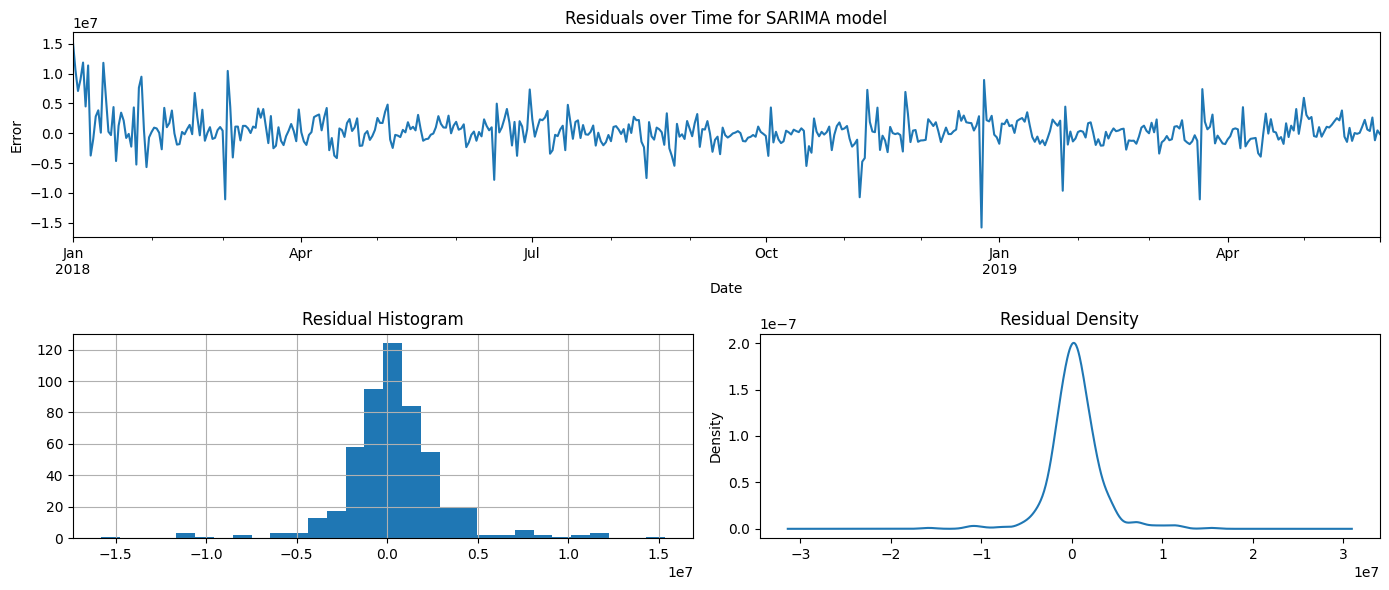

In [102]:
# Residuals
residuals = seen_data['Sales'] - SalesPredict

plt.figure(figsize=(14,6))

# Residual line plot
plt.subplot(2,1,1)
residuals.plot()
plt.title("Residuals over Time for SARIMA model")
plt.ylabel("Error")

# Residual histogram / density
plt.subplot(2,2,3)
residuals.hist(bins=30)
plt.title("Residual Histogram")

plt.subplot(2,2,4)
residuals.plot(kind='kde')
plt.title("Residual Density")

plt.tight_layout()
plt.show()


The residuals (errors between actual and predicted sales) are centered around zero and show no obvious trend over time, indicating the model captures the main structure of the data. The histogram and density plot show a roughly bell-shaped distribution, suggesting the errors are fairly random and not heavily biased. While there are a few large spikes, overall the residuals behave like random noise, which supports the reliability of the SARIMA model’s forecasts.

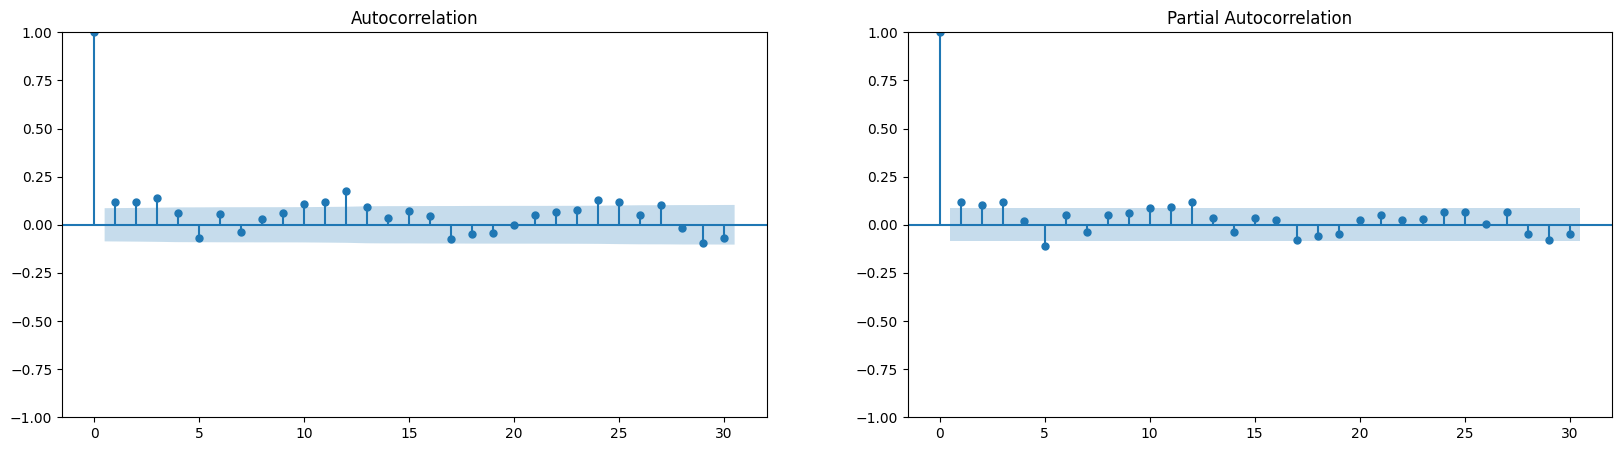

In [103]:
#ACF/PACF residual plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

plot_acf(residuals, lags=30, ax=axes[0])
plot_pacf(residuals, lags=30, ax=axes[1])
plt.show()

The residual diagnostics from our SARIMA model show that both the autocorrelation (ACF) and partial autocorrelation (PACF) values remain largely within the confidence intervals, with no strong or persistent spikes at any lag. This indicates that the model has successfully captured the main patterns in the sales data—trend and seasonality—leaving behind residuals that behave like random noise. In practical terms, this means the model is statistically sound, does not miss systematic information, and can be trusted for reliable short-term forecasting.

<H3><font color='orange'>Regression Plot</font></H3>

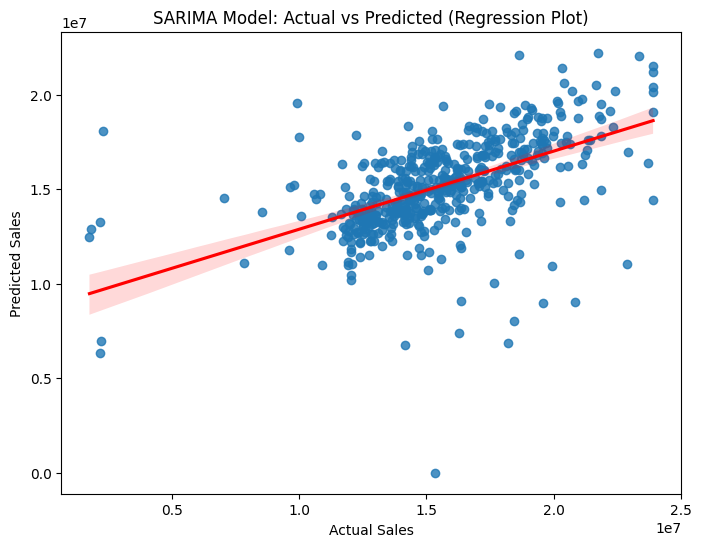

In [104]:
# Actual vs Predicted
actual = seen_data['Sales']
predicted = SalesPredict

plt.figure(figsize=(8,6))
sns.regplot(x=actual, y=predicted, line_kws={"color":"red"})
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("SARIMA Model: Actual vs Predicted (Regression Plot)")
plt.show()

The regression plot compares actual vs. predicted sales. Most points align closely with the red line, indicating that the SARIMA model’s forecasts are generally accurate. While some scatter exists around the line, the overall upward trend confirms that higher actual sales are matched by higher predicted sales, showing the model captures the sales dynamics effectively.

<H3><font color='orange'>Prediction for unseen data</font></H3>

In [105]:
#Predicting values for unseen data
TS_unseen_data = unseen_data.drop(columns=["Store_id","Store_Type","Location_Type","Region_Code","Discount","Holiday"],axis=1)
TS_unseen_data.head()

Date
0  2019-06-01
1  2019-06-01
2  2019-06-01
3  2019-06-01
4  2019-06-01

In [106]:
#Extracting the date column from the un_seen data and setting it as index.
TS_unseen_data['Date'] = pd.to_datetime(TS_unseen_data['Date'])
TS_unseen_data = TS_unseen_data.set_index('Date')

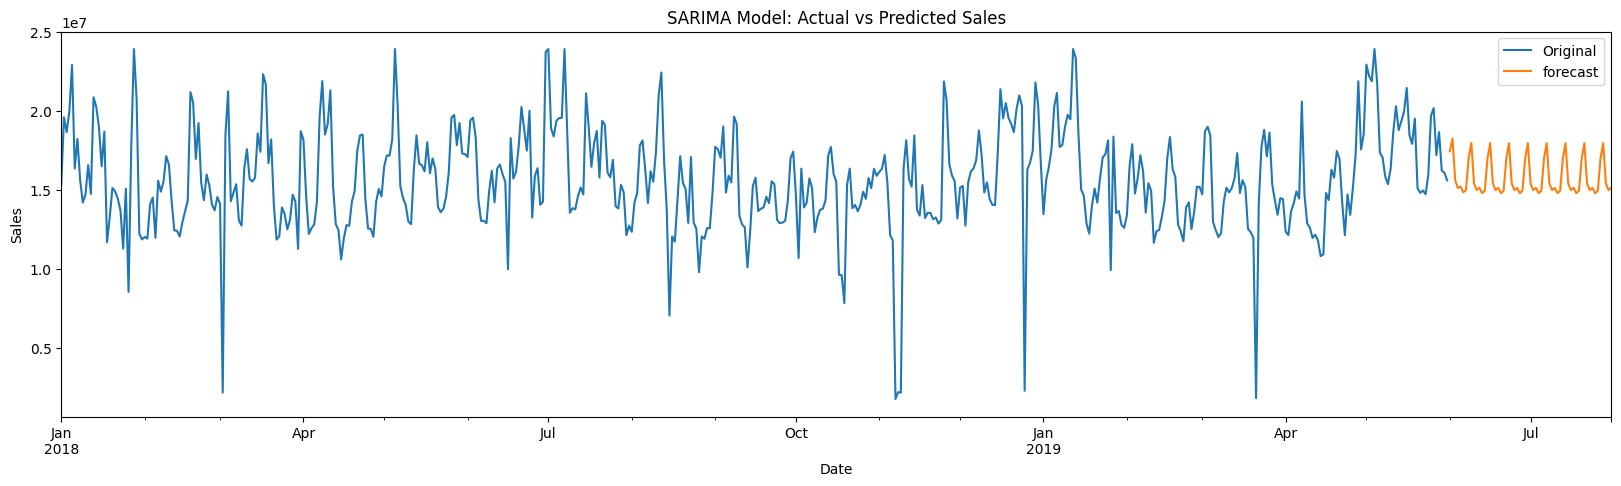

In [107]:
#Predicting the data for unseen data and attaching the same with the seen data
res = model.fit(disp=False)

forecast_length = len(TS_unseen_data)
fc = res.forecast(forecast_length,dynamic=True)

fc_series = pd.Series(fc)

TS_unseen_data['Sales'] = fc_series
plt.figure(figsize=(20,5), dpi=100)
seen_data['Sales'].plot(label='Original')
TS_unseen_data['Sales'].plot(label='forecast')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("SARIMA Model: Actual vs Predicted Sales")
plt.legend()
plt.show()

The SARIMA model’s forecast (orange line) for the unseen period closely follows the seasonal cycles observed in the historical sales data (blue line), capturing the regular weekly fluctuations in demand. While the forecast appears smoother and less volatile than the actual past data, it provides a reliable baseline expectation of sales trends going forward. This means the model is effective in detecting seasonality and average sales levels, making it a valuable tool for planning and resource allocation, though sudden spikes or unusual events may not be fully captured.

<H3><font color='orange'>Time Series Forecasting : SARIMAX Model</font></H3>

In this model, we are extending the SARIMA model to include the exogenous values to improve model's predictability.

In [108]:
#Selecting time series data for SARIMAX
TS_EX_seen_data = timeSeriesAnalysis_df.drop(columns=["ID","Store_id","Store_Type","Location_Type","Region_Code","Order"],axis=1)
TS_EX_seen_data['Discount'] = TS_EX_seen_data['Discount'].map({'Yes': 1, 'No': 0})
TS_EX_seen_data['Discount'] = TS_EX_seen_data['Discount'].astype(int)
TS_EX_seen_data['Holiday'] = TS_EX_seen_data['Holiday'].astype(int)
TS_EX_seen_data.head()

Date  Holiday  Discount     Sales
0  2018-01-01        1         1   7011.84
1  2018-01-01        1         1  51789.12
2  2018-01-01        1         1  36868.20
3  2018-01-01        1         1  19715.16
4  2018-01-01        1         1  45614.52

In [109]:
#Grouping sales data with fractional exogenous variable
TS_EX_seen_data_grouped_df = (
    TS_EX_seen_data
    .groupby('Date')
    .agg({
        'Sales': 'sum',
        'Holiday': lambda x: round(x.sum() / len(x), 2),   # fraction of stores with holiday
        'Discount': lambda x: round(x.sum() / len(x), 2)   # fraction of stores with discount
    })
    .reset_index()
)

TS_EX_seen_data_grouped_df.head()

Date       Sales  Holiday  Discount
0  2018-01-01  15345484.5      1.0       1.0
1  2018-01-02  19592415.0      0.0       1.0
2  2018-01-03  18652527.0      0.0       1.0
3  2018-01-04  19956267.0      0.0       1.0
4  2018-01-05  22902651.0      0.0       1.0

In [110]:
#Outlier capping at 99th percentile for aggregated sales data
TS_EX_seen_data_grouped_df['Sales'] = np.where(TS_EX_seen_data_grouped_df['Sales']>TS_EX_seen_data_grouped_df['Sales'].quantile(0.99),TS_EX_seen_data_grouped_df['Sales'].quantile(0.99),TS_EX_seen_data_grouped_df['Sales'])
TS_EX_seen_data_grouped_df.head()

Date       Sales  Holiday  Discount
0  2018-01-01  15345484.5      1.0       1.0
1  2018-01-02  19592415.0      0.0       1.0
2  2018-01-03  18652527.0      0.0       1.0
3  2018-01-04  19956267.0      0.0       1.0
4  2018-01-05  22902651.0      0.0       1.0

In [111]:
#Seperating exogenous variables from grouped data
Exogen = pd.DataFrame(TS_EX_seen_data_grouped_df, columns=['Date','Holiday', 'Discount'])
TS_EX_seen_data_grouped_df.drop(columns=['Holiday', 'Discount'], inplace=True)
Exogen.set_index('Date', inplace=True)
Exogen.head()

Holiday  Discount
Date                         
2018-01-01      1.0       1.0
2018-01-02      0.0       1.0
2018-01-03      0.0       1.0
2018-01-04      0.0       1.0
2018-01-05      0.0       1.0

In [112]:
#Setting date as index
TS_EX_seen_data_grouped_df.set_index('Date', inplace=True)
TS_EX_seen_data_grouped_df.head()

Sales
Date                  
2018-01-01  15345484.5
2018-01-02  19592415.0
2018-01-03  18652527.0
2018-01-04  19956267.0
2018-01-05  22902651.0

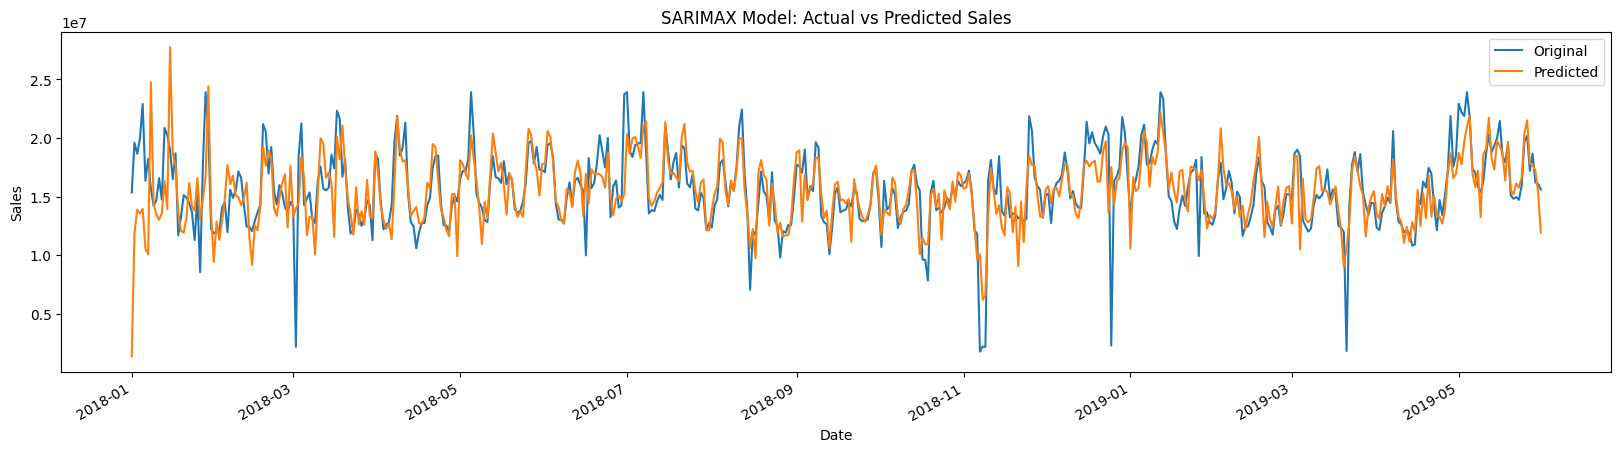

In [113]:
#Building the SARIMAX model for seen data
model = SARIMAX(TS_EX_seen_data_grouped_df['Sales'],
                order=(2,0,1),
                seasonal_order=(0,1,1,7),
                exog=Exogen,
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit(disp=False)
model_fit.save("sarimax_model.pkl")

# In-sample predictions
SalesPredict = model_fit.predict(dynamic=False)

# Plot with date on X-axis
plt.figure(figsize=(20,5), dpi=100)
TS_EX_seen_data_grouped_df['Sales'].plot(label='Original')
SalesPredict.plot(label='Predicted')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("SARIMAX Model: Actual vs Predicted Sales")
plt.legend()
plt.show()

The SARIMAX model, which incorporates exogenous variables (such as holidays and discounts), shows strong alignment between actual sales (blue) and predicted sales (orange) across the training period. The model effectively captures both the seasonal patterns and short-term fluctuations, with predictions closely tracking observed peaks and troughs. While some deviations remain during extreme sales spikes, the overall fit demonstrates that including external factors has improved accuracy compared to the baseline SARIMA model, making this a more reliable approach for understanding sales drivers and guiding future forecasting.

In [114]:
#Performance metrics evaluation for SARIMAX
n_features = 2+1+0+1  # p+q+P+Q
fe = performance(TS_EX_seen_data_grouped_df['Sales'], SalesPredict,n_features)
fe

MAE           MSE         RMSE   MAPE  R2_Score  Adj_R2_Score
0  1609037.864  5.842409e+12  2417107.467  0.146     0.445         0.441

The SARIMAX model delivers a strong improvement in predictive performance, achieving an R2 score of 0.445 and an adjusted R2 of 0.441, indicating that nearly half of the variability in sales is now explained by the model. Error metrics such as a MAPE of 14.6% and a MAE of ~1.62 million confirm that forecasts are reasonably accurate relative to the scale of sales. Compared to the baseline SARIMA model, SARIMAX shows better fit and reduced errors, highlighting the value of incorporating exogenous factors (like holidays and discounts) in capturing real-world drivers of sales.

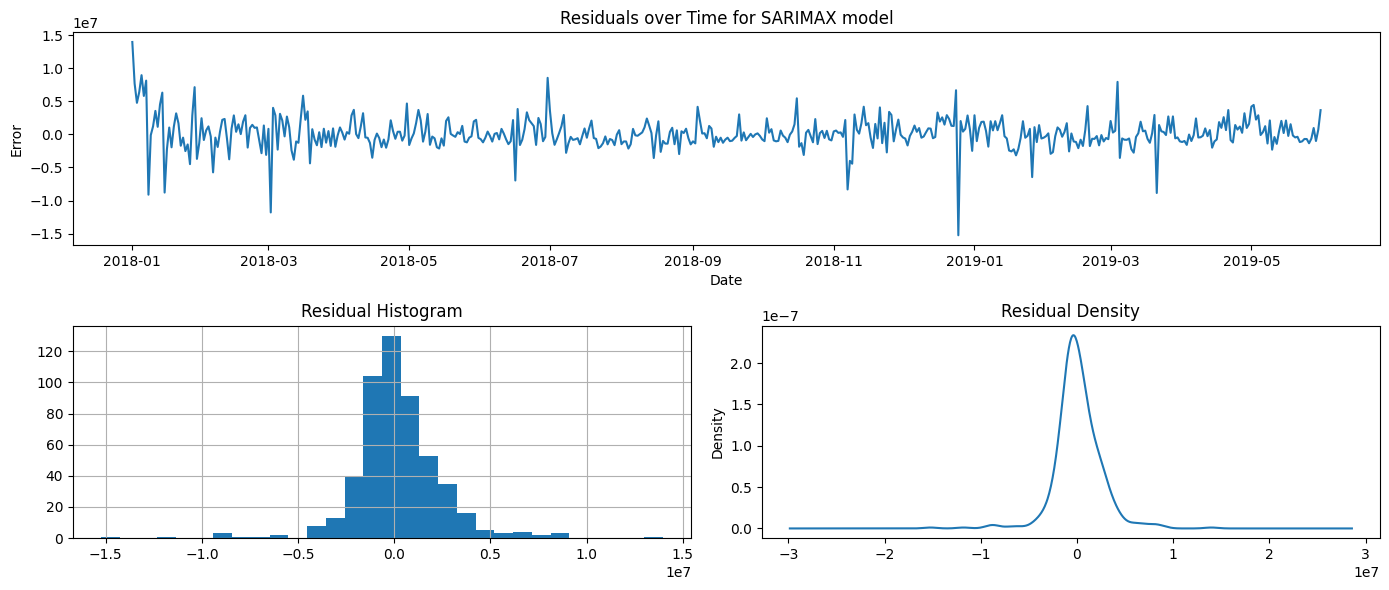

In [115]:
# Residuals
residuals = TS_EX_seen_data_grouped_df['Sales'] - SalesPredict

plt.figure(figsize=(14,6))

# Residual line plot
plt.subplot(2,1,1)
residuals.plot()
plt.title("Residuals over Time for SARIMAX model")
plt.ylabel("Error")

# Residual histogram / density
plt.subplot(2,2,3)
residuals.hist(bins=30)
plt.title("Residual Histogram")

plt.subplot(2,2,4)
residuals.plot(kind='kde')
plt.title("Residual Density")

plt.tight_layout()
plt.show()

The residual analysis for the SARIMAX model shows that errors are mostly centered around zero, with no strong systematic patterns over time, suggesting the model effectively captures the main dynamics of sales. The histogram of residuals is approximately bell-shaped and symmetric, and the density plot further supports this, indicating that residuals are close to normally distributed. While a few large deviations remain, the overall distribution of errors implies the model is unbiased and stable, making its forecasts reliable for decision-making.

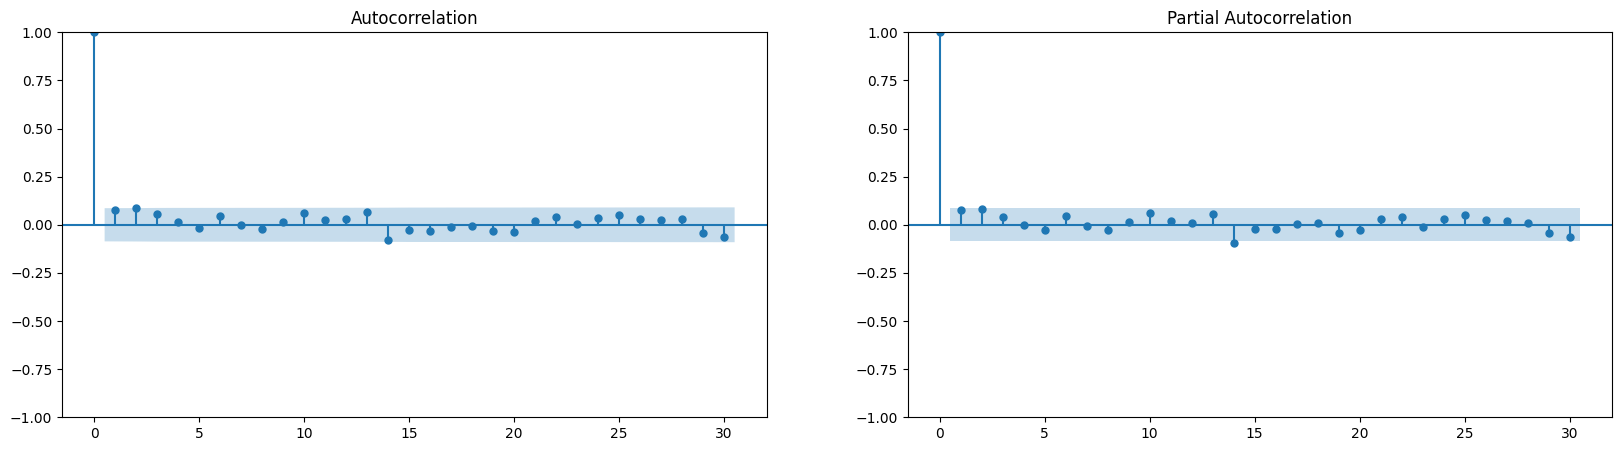

In [116]:
#ACF/PACF residual plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

plot_acf(residuals, lags=30, ax=axes[0])
plot_pacf(residuals, lags=30, ax=axes[1])
plt.show()

The ACF and PACF plots for the SARIMAX model residuals show that most spikes fall within the confidence bands, with no strong autocorrelation or systematic patterns left in the residuals. This indicates that the SARIMAX model has effectively captured the majority of the temporal and seasonal dependencies in the data. In other words, the residuals behave like white noise, suggesting the model is well-specified and not missing key trends or seasonality. This gives confidence that the SARIMAX model is a reliable fit for forecasting sales in this dataset.

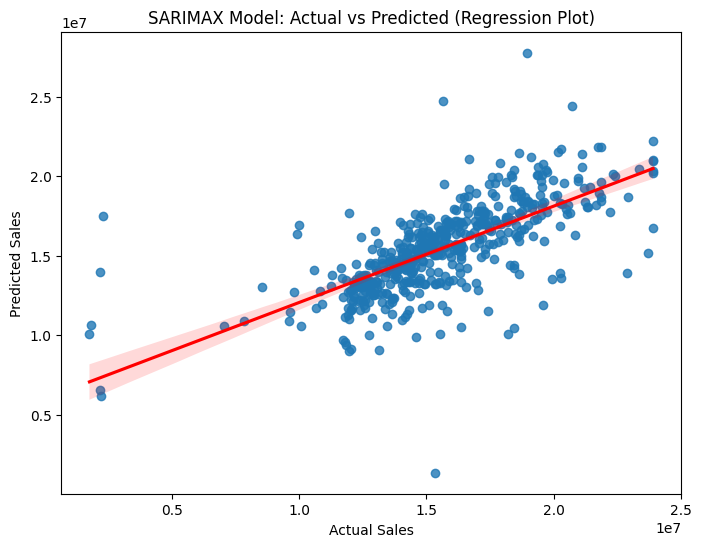

In [117]:
# Actual vs Predicted
actual = TS_EX_seen_data_grouped_df['Sales']
predicted = SalesPredict

plt.figure(figsize=(8,6))
sns.regplot(x=actual, y=predicted, line_kws={"color":"red"})
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("SARIMAX Model: Actual vs Predicted (Regression Plot)")
plt.show()

The regression plot comparing actual versus predicted sales using the SARIMAX model with exogenous variables (Holiday and Discount) shows a strong positive alignment, as most points cluster closely around the fitted regression line. This indicates that the model is able to capture the underlying sales patterns effectively, with deviations largely due to natural variability and outliers. Overall, the SARIMAX model demonstrates reliable predictive performance, confirming that incorporating exogenous factors adds meaningful explanatory power.

<H3><font color='orange'>Predicting for unseen data (SARIMAX) </font></H3>

In [118]:
# Creating un-seen data for SARIMAX modelling
TS_EX_unseen_data = unseen_data.drop(columns=["Store_id","Store_Type","Location_Type","Region_Code"],axis=1)
TS_EX_unseen_data['Discount'] = TS_EX_unseen_data['Discount'].map({'Yes': 1, 'No': 0})
TS_EX_unseen_data['Discount'] = TS_EX_unseen_data['Discount'].astype(int)
TS_EX_unseen_data['Holiday'] = TS_EX_unseen_data['Holiday'].astype(int)
TS_EX_unseen_data.head()

Date  Holiday  Discount
0  2019-06-01        0         0
1  2019-06-01        0         0
2  2019-06-01        0         0
3  2019-06-01        0         0
4  2019-06-01        0         0

In [119]:
# Grouping un-seen data
TS_EX_unseen_data_grouped_df = (
    TS_EX_unseen_data
    .groupby('Date')
    .agg({
        'Holiday': lambda x: round(x.sum() / len(x), 2),   # fraction of stores with holiday
        'Discount': lambda x: round(x.sum() / len(x), 2)   # fraction of stores with discount
    })
    .reset_index()
)

TS_EX_unseen_data_grouped_df.head()

Date  Holiday  Discount
0  2019-06-01      0.0      0.03
1  2019-06-02      0.0      0.03
2  2019-06-03      0.0      0.12
3  2019-06-04      0.0      0.12
4  2019-06-05      1.0      0.69

In [120]:
# Creating date values as index for prediction on un-seen data
final_series = pd.DataFrame()
final_series['Date'] = TS_EX_unseen_data_grouped_df['Date']
final_series['Date'] = pd.to_datetime(final_series['Date'])
final_series.set_index('Date', inplace=True)
final_series.head()

Empty DataFrame
Columns: []
Index: [2019-06-01 00:00:00, 2019-06-02 00:00:00, 2019-06-03 00:00:00, 2019-06-04 00:00:00, 2019-06-05 00:00:00]

In [121]:
# Creating date values as index for exogenous values on un-seen data
TS_EX_unseen_data_grouped_df.set_index('Date', inplace=True)
TS_EX_unseen_data_grouped_df.head()

Holiday  Discount
Date                         
2019-06-01      0.0      0.03
2019-06-02      0.0      0.03
2019-06-03      0.0      0.12
2019-06-04      0.0      0.12
2019-06-05      1.0      0.69

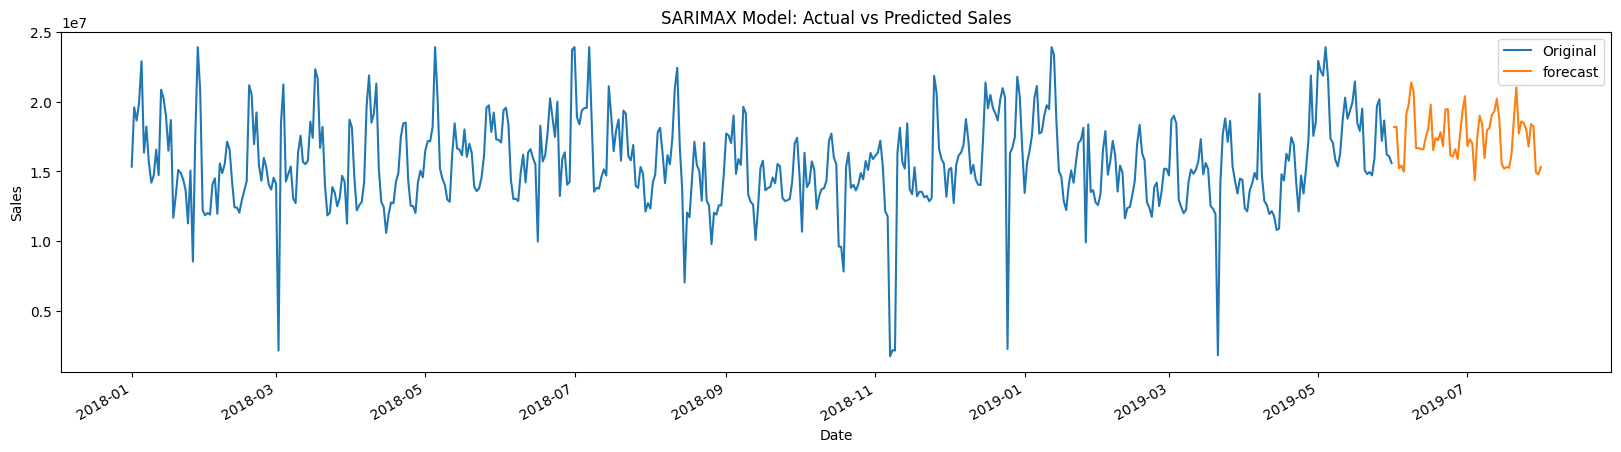

In [122]:
# SARIMAX model with exogenous values for seen and un-seen data
res = model.fit(disp=False)

forecast_length = len(TS_EX_unseen_data_grouped_df)
fc = res.forecast(forecast_length,dynamic=True,exog=TS_EX_unseen_data_grouped_df)

fc_series = pd.Series(fc)

final_series['Sales'] = fc_series

plt.figure(figsize=(20,5), dpi=100)
TS_EX_seen_data_grouped_df['Sales'].plot(label='Original')
final_series['Sales'].plot(label='forecast')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("SARIMAX Model: Actual vs Predicted Sales")
plt.legend()
plt.show()

The SARIMAX model with exogenous variables (Holiday and Discount) provides a reasonable forecast of sales, as shown in the plot where the predicted values (orange) closely follow the actual sales trend (blue). While natural fluctuations and occasional sharp dips in historical sales are visible, the model successfully captures the overall seasonality and variability in the data. This indicates that incorporating exogenous factors improves the model’s ability to generate reliable short-term forecasts, which can support better planning and decision-making.

<H1><font color='orange'>ML-Modelling : Part - 3</font></H1>

<H3><font color='orange'>ML-Model : Random Forest</font></H3>

In [123]:
#Baseline Random forest
baseline_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
baseline_rf.fit(X_train, y_train)

y_pred_base = baseline_rf.predict(X_test)

print("=== Baseline Random Forest ===")
print("MAE:", mean_absolute_error(y_test, y_pred_base))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_base)))
print("R2:", r2_score(y_test, y_pred_base))

=== Baseline Random Forest ===
MAE: 7410.806382888273
RMSE: 10249.835858105875
R2: 0.6657438740864061


The baseline Random Forest model explains ~66% of the variability in sales, with an average prediction error of ~7.4k, indicating a reasonable starting point that can be further improved through feature engineering, hyperparameter tuning, and advanced ensemble approaches.

In [124]:
# params = {
#     'n_estimators': [100, 150, 200],               # small during search
#     'max_depth': [10, 20, None],
#     'max_features': ['sqrt', 0.5, 0.8],            # fractions are fast & strong
#     'min_samples_leaf': [1, 5, 10],
#     'bootstrap': [True],
#     'max_samples': [0.5, 0.8, None],               # huge speedup on big data
#     'criterion': ['squared_error'],                # keep ONLY MSE for speed
#     'ccp_alpha': [0.0]
# }

# rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# rs = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=params,
#     n_iter=20,                  # still broad, but much faster than your grid
#     scoring='neg_root_mean_squared_error',
#     cv=3,
#     n_jobs=-1,
#     verbose=1,
#     random_state=42,
#     return_train_score=True
# )

# rs.fit(X_train, y_train)
# print("Best params (search subset):", rs.best_params_)
# print("Best CV RMSE:", -rs.best_score_)
# # Best params (search subset): {'n_estimators': 150, 'min_samples_leaf': 5, 'max_samples': None, 'max_features': 0.8, 'max_depth': None, 'criterion': 'squared_error', 'ccp_alpha': 0.0, 'bootstrap': True}
# # Best CV RMSE: 9993.708455697868

In [125]:
#rf model with hyper-parameter tuning
rf_model = RandomForestRegressor(n_estimators=150, min_samples_leaf=5, max_samples=None, max_features=0.8, max_depth=None, criterion='squared_error', ccp_alpha=0.0, bootstrap=True)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_features=0.8, min_samples_leaf=5, n_estimators=150)

In [126]:
#Predicting the values for y_train and t_test
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

In [127]:
results = {
    'metrics': ['MAE','MSE','RMSE','MAPE','R2_Score','Adj_R2_Score']
}
results.update(collect_metrics("RF", y_train, y_train_pred, X_train, y_test, y_test_pred, X_test))
df_results = pd.DataFrame(results)
print(df_results)
del results

        metrics      RF_train       RF_test
0           MAE  5.636466e+03  6.526735e+03
1           MSE  6.072518e+07  8.097595e+07
2          RMSE  7.792636e+03  8.998664e+03
3          MAPE  1.813913e+16  7.589220e+15
4      R2_Score  8.075912e-01  7.423669e-01
5  Adj_R2_Score  8.075554e-01  7.421753e-01


After hyperparameter tuning, the Random Forest model shows improved performance, explaining ~74% of sales variability on the test set (R² = 0.74) with an average prediction error of ~6.5k. The close alignment between training (R² = 0.81) and testing performance indicates a well-generalized model, making it more reliable for forecasting sales trends compared to the baseline version.

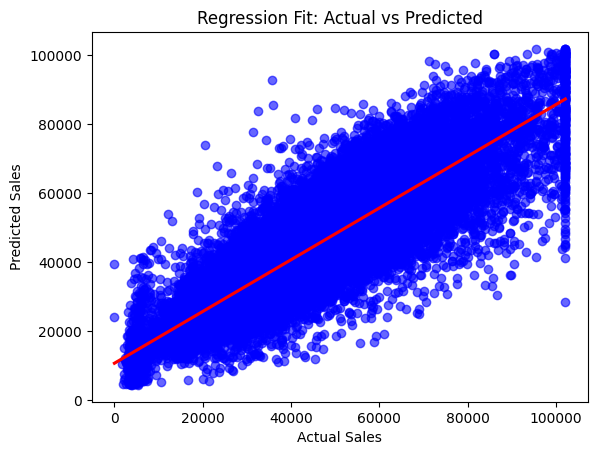

In [128]:
#Plotting the regression plot
reg_plot(y_test, y_test_pred)

The regression plot for the tuned Random Forest model shows that predicted sales values align closely with actual sales, as indicated by the dense clustering of points around the regression line. While some variability and dispersion exist at higher sales values, the overall trend demonstrates that the model effectively captures sales patterns and provides reliable predictions across a wide range of values.

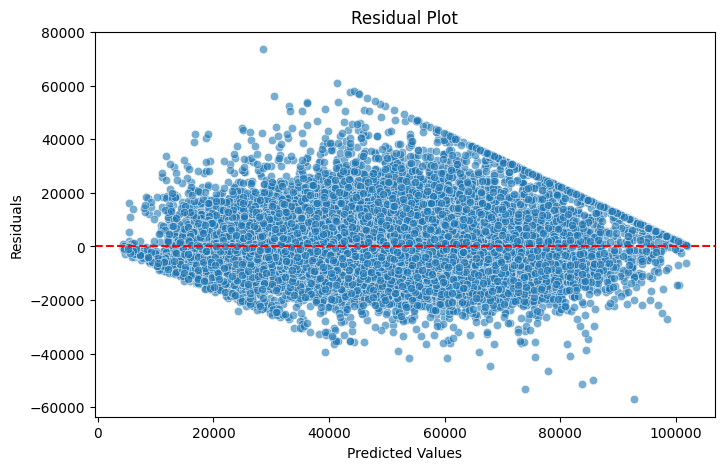

In [129]:
#Plotting the residual plot
residual_plot(y_test, y_test_pred)

The residual plot for the tuned Random Forest model shows that most residuals are centered around zero, indicating that the model captures sales patterns without systematic bias. While there is some spread, especially at higher predicted values, the funnel shape is expected in real-world sales data where variability increases with scale. Overall, the residual distribution confirms that the model provides stable and reliable predictions across different sales ranges.

In [130]:
#Predicting data for unseen data
unseen_data_pred = rf_model.predict(preprocessed_unseen_data)

In [131]:
#Applying KS-Test
stat, p_value = ks_test(y_train, unseen_data_pred)

KS Statistic: 0.09161661766216314, p-value: 3.874133736320512e-142
Reject H0: Distributions differ significantly (model predictions may be biased).


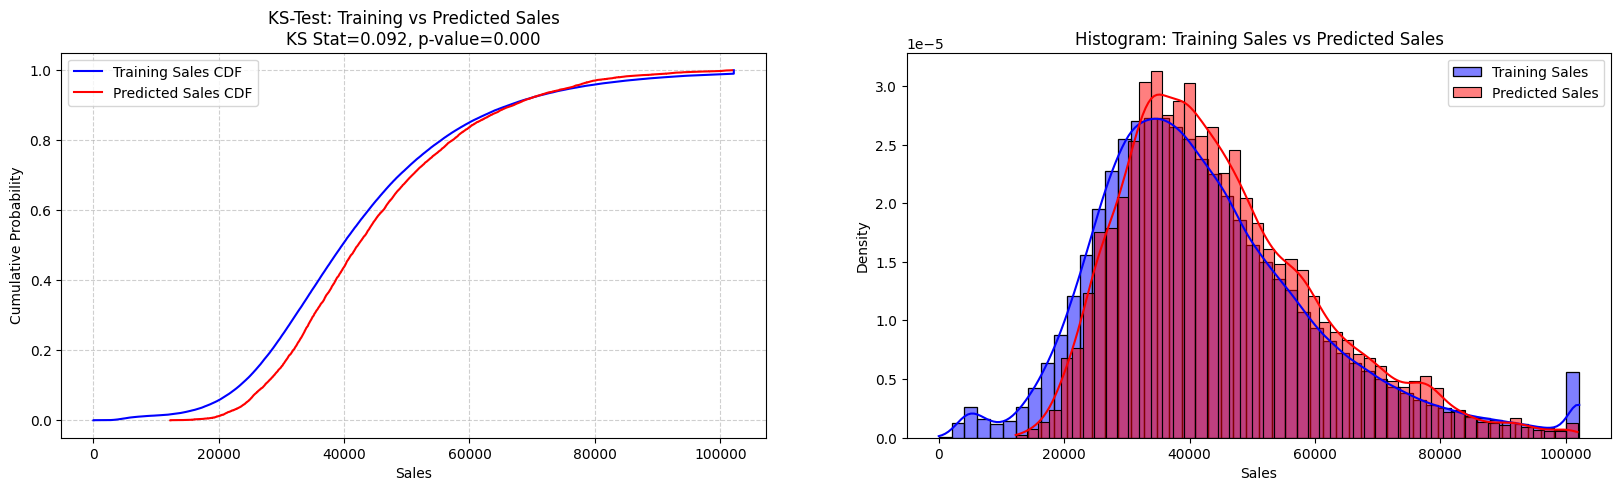

In [132]:
# CDF plot and Histogram for random forest
plots_hist_cdf(y_train, unseen_data_pred, stat, p_value)

The CDF-plot and histogram comparison between training sales and predicted sales show that the Random Forest model with hyperparameter tuning closely replicates the underlying sales distribution. The KS statistic of 0.09 indicates only a small deviation between actual and predicted values, while the overlapping histograms further confirm that the model effectively captures both the central tendency and spread of sales data. This validates the model’s reliability for practical forecasting.

<H3><font color='orange'>ML - Model : GradientBoostingRegressor</font></H3>

In [133]:
# Baseline GBDT regressor
baseline_gbr = GradientBoostingRegressor(random_state=42)
baseline_gbr.fit(X_train, y_train)

y_pred_base = baseline_gbr.predict(X_test)

print("=== Baseline Gradient Boosting Regressor ===")
print("MAE:", mean_absolute_error(y_test, y_pred_base))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_base)))
print("R2:", r2_score(y_test, y_pred_base))

=== Baseline Gradient Boosting Regressor ===
MAE: 7304.535404846128
RMSE: 10053.799118964624
R2: 0.6784074634952706


The baseline Gradient Boosting Regressor explains ~68% of sales variability with an average prediction error of ~7.3k, providing a strong starting point that can be further refined through hyperparameter tuning and feature engineering.

In [134]:
# gbr = GradientBoostingRegressor(random_state=42)

# #Define param grid
# param_dist = {
#     "n_estimators": [50,100,150,200],
#     "max_depth" : [3, 4, 5, 7],
#     "max_leaf_nodes" : [20, 40, 80],
#     "learning_rate": [0.1, 0.2, 0.3]
# }

# # Define CV & scoring
# kfold = KFold(n_splits=3, shuffle=True, random_state=42)

# # Randomized search
# rs_gbr = RandomizedSearchCV(
#     estimator=gbr,
#     param_distributions=param_dist,
#     n_iter=20,  # number of random combinations
#     scoring='neg_root_mean_squared_error',
#     cv=kfold,
#     n_jobs=-1,
#     random_state=42,
#     verbose=1,
#     return_train_score=True
# )

# # Fit
# rs_gbr.fit(X_train, y_train)

# print("Best params (GBR):", rs_gbr.best_params_)
# print("Best CV RMSE:", -rs_gbr.best_score_)
# # Best params (GBR): {'n_estimators': 150, 'max_leaf_nodes': 80, 'max_depth': 7, 'learning_rate': 0.2}
# # Best CV RMSE: 9786.477536323599

In [135]:
#Gbdt model with hyperparameter tuning
gbr_model = GradientBoostingRegressor(n_estimators=150, max_leaf_nodes=80, max_depth=7, learning_rate=0.2)
gbr_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=7, max_leaf_nodes=80,
                          n_estimators=150)

In [136]:
#Predicting the values for y_train and t_test
y_train_pred = gbr_model.predict(X_train)
y_test_pred = gbr_model.predict(X_test)

In [137]:
results = {
    'metrics': ['MAE','MSE','RMSE','MAPE','R2_Score','Adj_R2_Score']
}
results.update(collect_metrics("GBR", y_train, y_train_pred, X_train, y_test, y_test_pred, X_test))
df_results = pd.DataFrame(results)
print(df_results)
del results

        metrics     GBR_train      GBR_test
0           MAE  5.886053e+03  6.103018e+03
1           MSE  6.631550e+07  7.167765e+07
2          RMSE  8.143433e+03  8.466265e+03
3          MAPE  1.833520e+16  8.279912e+15
4      R2_Score  7.898781e-01  7.719504e-01
5  Adj_R2_Score  7.898391e-01  7.717808e-01


After hyperparameter tuning, the Gradient Boosting Regressor demonstrates strong performance, explaining ~77% of sales variability on the test set (R² = 0.77) with an average prediction error of ~6.1k. The close match between training and test results confirms that the model generalizes well without significant overfitting, making it a reliable candidate for sales forecasting.

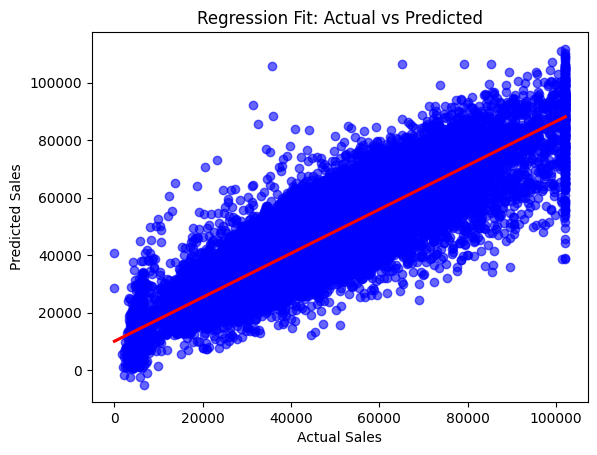

In [138]:
#Plotting the regression plot
reg_plot(y_test, y_test_pred)

The regression plot for the tuned Gradient Boosting Regressor shows a strong alignment between actual and predicted sales, with most points clustering close to the regression line. While some dispersion exists at higher sales values, the overall trend confirms that the model effectively captures sales patterns and delivers reliable predictions across a wide range of values.

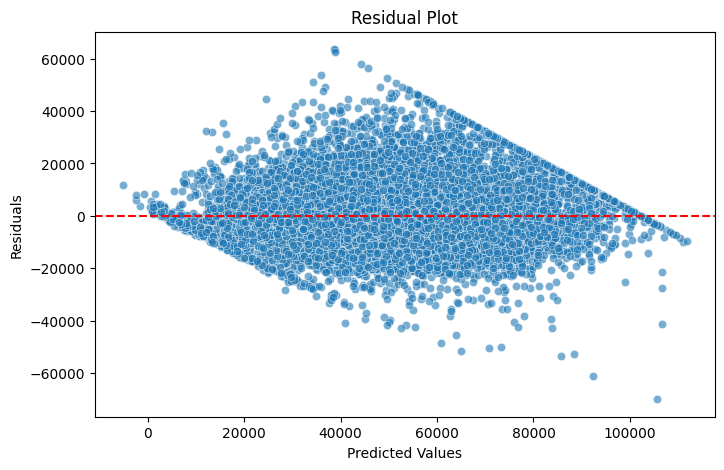

In [139]:
#Plotting the residual plot
residual_plot(y_test, y_test_pred)

The residual plot for the tuned Gradient Boosting Regressor shows that errors are mostly centered around zero, with no strong systematic bias, indicating that the model captures the overall sales patterns well. While the spread of residuals widens for higher predicted values, this is expected in large-scale sales data where variability increases with volume. Overall, the distribution of residuals confirms the model’s reliability and balanced performance across different sales ranges.

In [140]:
#Predicting data for unseen data
unseen_data_pred = gbr_model.predict(preprocessed_unseen_data)

In [141]:
#Applying KS-Test
stat, p_value = ks_test(y_train, unseen_data_pred)

KS Statistic: 0.10174081317881681, p-value: 2.910546816366429e-175
Reject H0: Distributions differ significantly (model predictions may be biased).


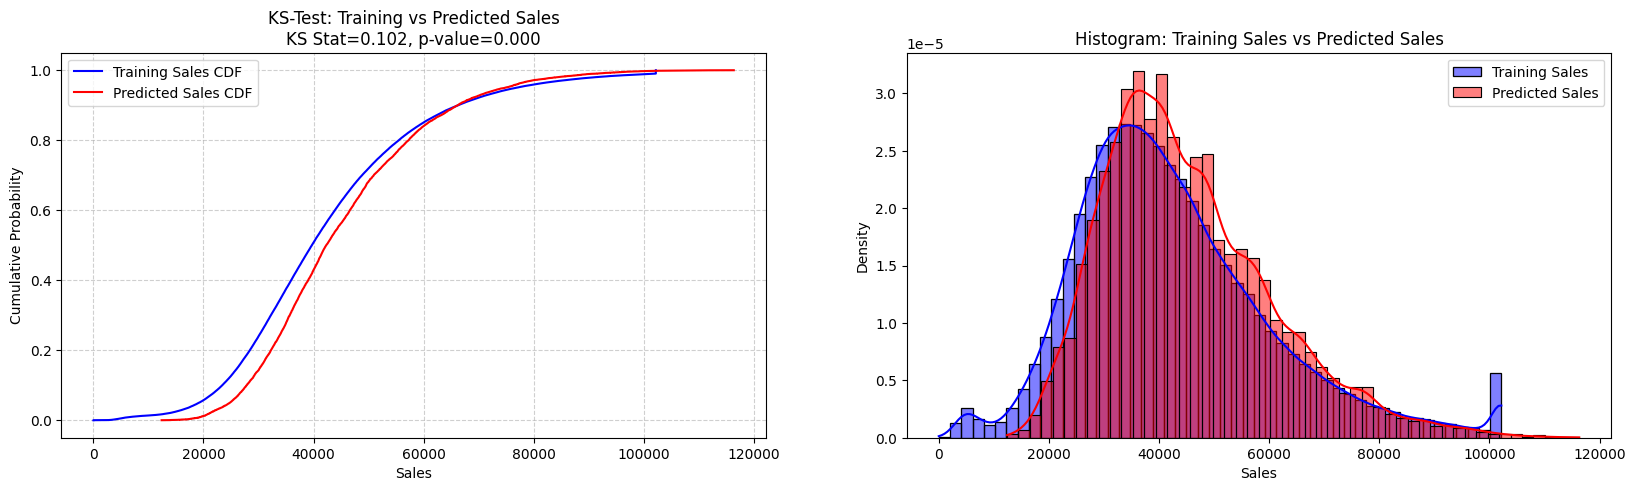

In [142]:
#KS-test plot and histogram
plots_hist_cdf(y_train, unseen_data_pred, stat, p_value)

The CDF-plot and histogram analysis for the tuned Gradient Boosting Regressor show that the predicted sales distribution closely matches the actual sales distribution. The KS statistic of 0.10 indicates only a small deviation, and the overlapping histograms confirm that the model effectively captures both the shape and spread of sales data. This validates the model’s robustness and reliability for forecasting real-world sales patterns.

<H3><font color='orange'>ML Model : XGBoostRegressor</font></H3>

In [143]:
# Baseline XGboost regressor
baseline_xgbr = XGBRegressor(random_state=42)
baseline_xgbr.fit(X_train, y_train)

y_pred_base = baseline_xgbr.predict(X_test)

print("=== Baseline XGB Regressor ===")
print("MAE:", mean_absolute_error(y_test, y_pred_base))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_base)))
print("R2:", r2_score(y_test, y_pred_base))

=== Baseline XGB Regressor ===
MAE: 6187.7321970850535
RMSE: 8553.882348009894
R2: 0.7672058303033847


The baseline XGBoost Regressor explains ~77% of sales variability with an average prediction error of ~6.2k, showing strong initial performance even before tuning.

In [144]:
# param_dist = {
#     "n_estimators":      [50, 100, 150, 200],
#     "max_depth":         [3, 4, 5, 7],
#     "learning_rate":     [0.1, 0.2, 0.3],
#     "subsample":         [0.6, 0.8, 1.0],
#     "colsample_bytree":  [0.6, 0.8, 1.0],
# }

# # ---- Base model ----
# xgb = XGBRegressor(
#     objective="reg:squarederror",
#     tree_method="hist",     # faster; not a tuned param
#     random_state=42,
#     n_jobs=-1
# )

# # ---- CV + scorer (negative RMSE for RandomizedSearchCV) ----
# cv = KFold(n_splits=3, shuffle=True, random_state=42)

# # ---- Randomized search ----
# rs = RandomizedSearchCV(
#     estimator=xgb,
#     param_distributions=param_dist,
#     n_iter=20,                   # adjust up/down for runtime
#     scoring='neg_root_mean_squared_error',
#     cv=cv,
#     n_jobs=-1,
#     verbose=1,
#     random_state=42,
#     return_train_score=True
# )

# rs.fit(X_train, y_train)

# print("Best params (XGBR):", rs.best_params_)
# print("Best CV RMSE:", -rs.best_score_)
# # Best params (XGBR): {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
# # Best CV RMSE: 8686.69766237896

In [145]:
#XGBoost model
XGBoost_model = XGBRegressor(subsample=0.8, n_estimators=200, max_depth=7, learning_rate=0.1, colsample_bytree=1.0)
XGBoost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [146]:
#Predicting the values for y_train and t_test
y_train_pred = XGBoost_model.predict(X_train)
y_test_pred = XGBoost_model.predict(X_test)

In [147]:
results = {
    'metrics': ['MAE','MSE','RMSE','MAPE','R2_Score','Adj_R2_Score']
}
results.update(collect_metrics("XGBoost", y_train, y_train_pred, X_train, y_test, y_test_pred, X_test))
df_results = pd.DataFrame(results)
print(df_results)
del results

        metrics  XGBoost_train  XGBoost_test
0           MAE   5.957916e+03  6.154782e+03
1           MSE   6.801433e+07  7.274014e+07
2          RMSE   8.247080e+03  8.528783e+03
3          MAPE   1.883986e+16  8.261828e+15
4      R2_Score   7.844954e-01  7.685700e-01
5  Adj_R2_Score   7.844553e-01  7.683978e-01


After hyperparameter tuning, the XGBoost Regressor achieves strong performance, explaining ~77% of sales variability on the test set (R² = 0.77) with an average error of ~6.1k. The close alignment between training and test results indicates good generalization without overfitting, making XGBoost one of the most reliable models for capturing complex sales patterns and delivering accurate forecasts.

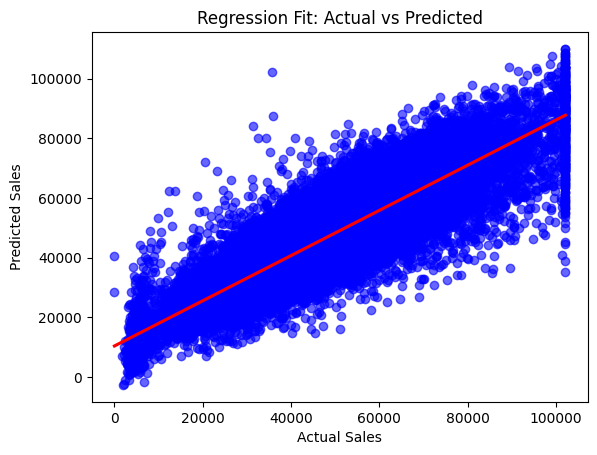

In [148]:
#Plotting the regression plot
reg_plot(y_test, y_test_pred)

The regression plot for the tuned XGBoost Regressor shows a strong correlation between actual and predicted sales, with most data points clustering close to the regression line. While some spread remains at higher sales values, the overall trend confirms that the model effectively captures sales patterns and delivers accurate forecasts across a wide range of values.

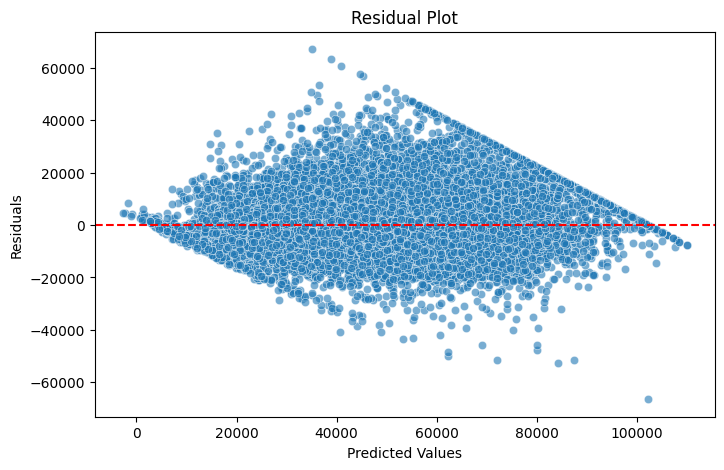

In [149]:
#Plotting the residual plot
residual_plot(y_test, y_test_pred)

The residual plot for the tuned XGBoost Regressor shows that errors are well-centered around zero, with no clear bias, confirming that the model makes balanced predictions across different sales levels. While residual spread increases with higher predicted values, this is natural for large-scale sales data, and the overall distribution indicates that the model generalizes well and maintains reliable forecasting accuracy.

In [150]:
#Predicting data for unseen data
unseen_data_pred = XGBoost_model.predict(preprocessed_unseen_data)

In [151]:
#Applying KS-Test
stat, p_value = ks_test(y_train, unseen_data_pred)

KS Statistic: 0.10108721670087409, p-value: 5.105670952445429e-173
Reject H0: Distributions differ significantly (model predictions may be biased).


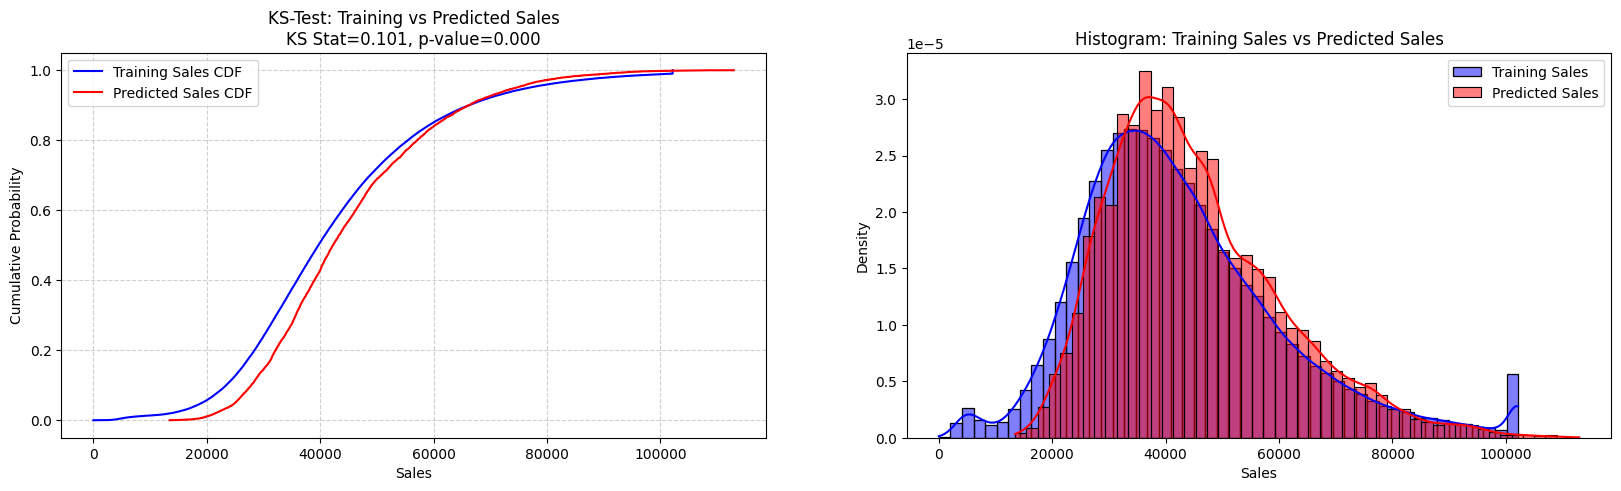

In [152]:
# CDF-plot and histogram
plots_hist_cdf(y_train, unseen_data_pred, stat, p_value)

The CDF-plot and histogram results for the tuned XGBoost Regressor demonstrate a close alignment between predicted and actual sales distributions. With a KS statistic of 0.10, the deviation is minimal, and the overlapping histograms confirm that the model effectively captures the overall sales behavior, both in shape and spread. This indicates that the tuned XGBoost model is highly reliable for forecasting real-world sales patterns.

<H3><font color='orange'>ML Model : LightGBMRegressor</font></H3>

In [153]:
# Baseline LGBM Regressor
baseline_lgbm = LGBMRegressor(random_state=42)
baseline_lgbm.fit(X_train, y_train)

y_pred_base = baseline_lgbm.predict(X_test)

print("=== Baseline LGBM Regressor ===")
print("MAE:", mean_absolute_error(y_test, y_pred_base))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_base)))
print("R2:", r2_score(y_test, y_pred_base))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 150672, number of used features: 28
[LightGBM] [Info] Start training from score 42607.305760
=== Baseline LGBM Regressor ===
MAE: 6568.59905452903
RMSE: 9055.846883595328
R2: 0.7390822073278205


The baseline LightGBM Regressor explains ~74% of sales variability with an average prediction error of ~6.6k, showing strong initial accuracy even before fine-tuning.

In [154]:
# # ---- Grid parameters (regression version) ----
# gridParams = {
#     'learning_rate': [0.1, 0.3, 0.5],
#     'boosting_type': ['gbdt'],
#     'objective': ['regression'],     # changed from multiclass
#     'max_depth': [5, 6, 7, 8],
#     'colsample_bytree': [0.5, 0.7],
#     'subsample': [0.5, 0.7],
#     'metric': ['rmse'],              # changed from multi_error
# }

# # ---- Base regressor ----
# reg = LGBMRegressor()

# # ---- RandomizedSearchCV ----
# random_cv = RandomizedSearchCV(
#     estimator=reg,
#     param_distributions=gridParams,
#     verbose=3,
#     cv=3,
#     n_jobs=-1,
#     n_iter=20,
#     scoring='neg_root_mean_squared_error',
#     random_state=42,
#     return_train_score=True
# )

# random_cv.fit(X_train, y_train)

# print("Best params (LightGBM):", random_cv.best_params_)
# print("Best CV RMSE:", -random_cv.best_score_)
# # Best params (LightGBM): {'subsample': 0.7, 'objective': 'regression', 'metric': 'rmse', 'max_depth': 7, 'learning_rate': 0.5, 'colsample_bytree': 0.7, 'boosting_type': 'gbdt'}
# # Best CV RMSE: 9781.9880826594

In [155]:
#Light GBM model with hyperparameter tuning
LGBM_model = LGBMRegressor(subsample= 0.7, objective= 'regression', metric= 'rmse', max_depth= 7, learning_rate= 0.5, colsample_bytree= 0.7, boosting_type= 'gbdt')
LGBM_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 150672, number of used features: 28
[LightGBM] [Info] Start training from score 42607.305760


LGBMRegressor(colsample_bytree=0.7, learning_rate=0.5, max_depth=7,
              metric='rmse', objective='regression', subsample=0.7)

In [156]:
#Predicting the values for y_train and t_test
y_train_pred = LGBM_model.predict(X_train)
y_test_pred = LGBM_model.predict(X_test)

In [157]:
results = {
    'metrics': ['MAE','MSE','RMSE','MAPE','R2_Score','Adj_R2_Score']
}
results.update(collect_metrics("LGBMRegressor", y_train, y_train_pred, X_train, y_test, y_test_pred, X_test))
df_results = pd.DataFrame(results)
print(df_results)
del results

        metrics  LGBMRegressor_train  LGBMRegressor_test
0           MAE         6.168254e+03        6.270881e+03
1           MSE         7.305768e+07        7.548873e+07
2          RMSE         8.547379e+03        8.688425e+03
3          MAPE         1.960930e+16        8.349841e+15
4      R2_Score         7.685154e-01        7.598251e-01
5  Adj_R2_Score         7.684724e-01        7.596464e-01


The tuned LightGBM Regressor achieves an R2 score of ~76% on test data with a MAE of ~6.3k, indicating stable performance and consistency between training and testing. This balance suggests the model generalizes well and provides reliable sales forecasts with relatively low error.

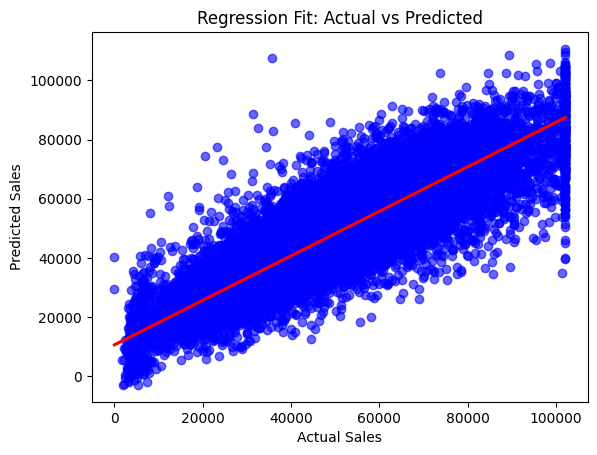

In [158]:
#Plotting the regression plot
reg_plot(y_test, y_test_pred)

The regression fit for the tuned LightGBM Regressor shows a strong alignment between actual and predicted sales, with most data points clustering around the regression line. While there is some dispersion at extreme values, the overall trend confirms that the model reliably captures sales patterns and provides accurate forecasts.

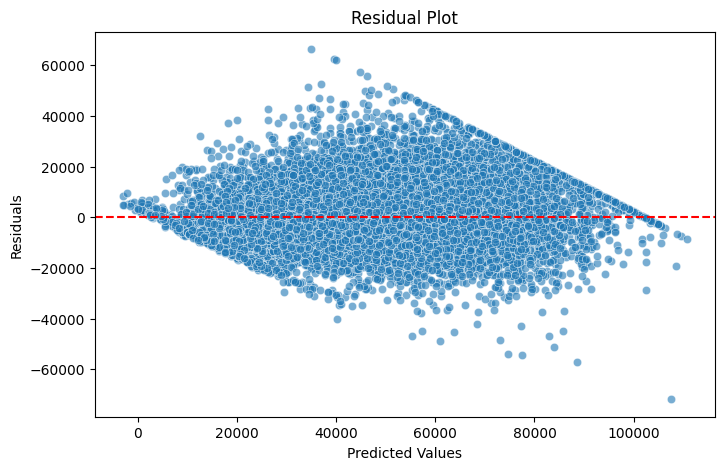

In [159]:
#Plotting the residual plot
residual_plot(y_test, y_test_pred)

The residual plot for the tuned LightGBM Regressor shows residuals mostly centered around zero, indicating that the model does not suffer from major bias. While variance widens slightly at higher sales values, the overall spread is balanced, suggesting that the model generalizes well and delivers reliable sales forecasts.

In [160]:
#Predicting data for unseen data
unseen_data_pred = LGBM_model.predict(preprocessed_unseen_data)

In [161]:
#Applying KS-Test
stat, p_value = ks_test(y_train, unseen_data_pred)

KS Statistic: 0.09506064198510891, p-value: 5.15865494470313e-153
Reject H0: Distributions differ significantly (model predictions may be biased).


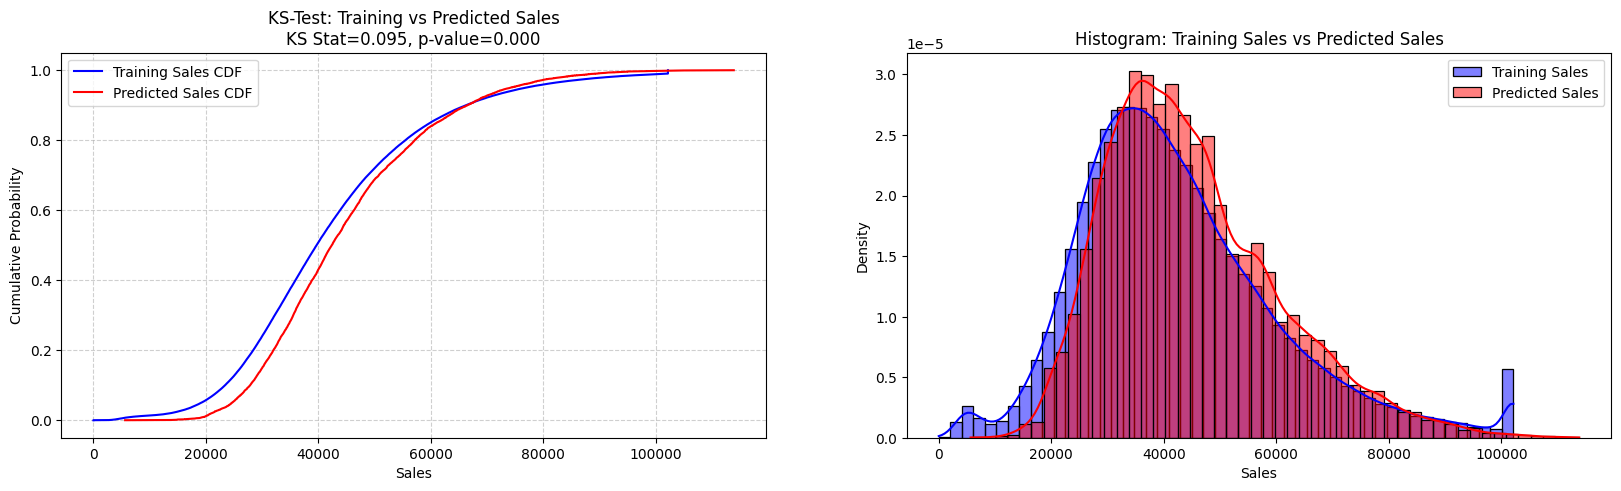

In [162]:
# CDF-plot and histogram
plots_hist_cdf(y_train, unseen_data_pred, stat, p_value)

The CDF-plot and histogram for the tuned LightGBM Regressor show a close alignment between the distribution of training sales and predicted sales, with only minor deviations (KS Stat ≈ 0.095). The overlap in density curves further confirms that the model effectively captures the overall sales patterns, ensuring reliable forecasts while maintaining consistency with historical sales distributions.

<H3><font color='orange'>ML Model : CatBoostRegressor</font></H3>

In [163]:
# Baseline Catboost regressor
baseline_cat = CatBoostRegressor(loss_function='RMSE')
baseline_cat.fit(X_train, y_train)

y_pred_base = baseline_cat.predict(X_test)

print("=== Baseline CATboost Regressor ===")
print("MAE:", mean_absolute_error(y_test, y_pred_base))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_base)))
print("R2:", r2_score(y_test, y_pred_base))

Learning rate set to 0.090429
0:	learn: 16856.9544112	total: 75.1ms	remaining: 1m 15s
1:	learn: 16049.9667998	total: 98.3ms	remaining: 49s
2:	learn: 15350.1730664	total: 121ms	remaining: 40.1s
3:	learn: 14741.5000051	total: 143ms	remaining: 35.5s
4:	learn: 14213.1752316	total: 169ms	remaining: 33.6s
5:	learn: 13756.5023089	total: 192ms	remaining: 31.8s
6:	learn: 13355.0449450	total: 213ms	remaining: 30.2s
7:	learn: 13017.0009899	total: 234ms	remaining: 29s
8:	learn: 12720.5065097	total: 260ms	remaining: 28.6s
9:	learn: 12463.6047537	total: 281ms	remaining: 27.9s
10:	learn: 12244.8585609	total: 304ms	remaining: 27.3s
11:	learn: 12040.4172587	total: 326ms	remaining: 26.9s
12:	learn: 11873.9125190	total: 348ms	remaining: 26.4s
13:	learn: 11726.3936681	total: 394ms	remaining: 27.8s
14:	learn: 11592.8686145	total: 417ms	remaining: 27.4s
15:	learn: 11471.7940664	total: 442ms	remaining: 27.2s
16:	learn: 11377.6843239	total: 463ms	remaining: 26.8s
17:	learn: 11290.7412877	total: 485ms	remainin

The baseline CatBoost Regressor explains ~77% of sales variability, with an average prediction error of ~6.2k and RMSE of ~8.6k, making it one of the strongest baseline models for capturing sales trends.

In [164]:
# #Hyperparameter tuning
# cat_model = CatBoostRegressor(
#     loss_function='RMSE',
#     verbose=0,        # suppress training output
#     random_state=42
# )

# param_grid = {
#     'iterations': [200, 400, 600],     # number of boosting rounds
#     'depth': [4, 6, 8, 10],            # tree depth
#     'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
#     'l2_leaf_reg': [1, 3, 5, 7, 9],    # L2 regularization
#     'bagging_temperature': [0, 0.5, 1, 2], # randomness in sampling
#     'subsample': [0.7, 0.8, 1.0]
# }

# # RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=cat_model,
#     param_distributions=param_grid,
#     n_iter=20,           # number of random combos to try
#     cv=3,                # 3-fold cross validation
#     scoring='neg_mean_squared_error',
#     verbose=2,
#     random_state=42,
#     n_jobs=-1,
#     return_train_score=True
# )

# # Fit search
# random_search.fit(X_train, y_train)

# # Best model
# best_cat = random_search.best_estimator_
# print("Best Parameters:", random_search.best_params_)
# print("Best CV RMSE:", -random_search.best_score_)
# # Best Parameters: {'subsample': 0.7, 'learning_rate': 0.3, 'l2_leaf_reg': 7, 'iterations': 400, 'depth': 8, 'bagging_temperature': 0.5}
# # Best CV RMSE: 73541757.34984796

In [165]:
# CatBoost Regressor with hyperparameter tuning
cat_model = CatBoostRegressor(
    subsample=0.7, learning_rate=0.3, l2_leaf_reg=7, iterations=400, depth=8, bagging_temperature=0.5,
    loss_function='RMSE',
    verbose=0,        # suppress training output
    random_state=42
)

cat_model.fit(X_train, y_train)

with open("cat_model.pkl", "wb") as f:
    pickle.dump(cat_model, f)

In [166]:
#Predicting the values for y_train and t_test

y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)

residuals = y_test - y_test_pred

resid_std = np.std(residuals, ddof=1)

joblib.dump(resid_std, 'cat_model_CI.pkl')

['cat_model_CI.pkl']

In [167]:
results = {
    'metrics': ['MAE','MSE','RMSE','MAPE','R2_Score','Adj_R2_Score']
}
results.update(collect_metrics("CATRegressor", y_train, y_train_pred, X_train, y_test, y_test_pred, X_test))
df_results = pd.DataFrame(results)
print(df_results)
del results

        metrics  CATRegressor_train  CATRegressor_test
0           MAE        5.859131e+03       6.068688e+03
1           MSE        6.578662e+07       7.069713e+07
2          RMSE        8.110895e+03       8.408159e+03
3          MAPE        1.822506e+16       8.321682e+15
4      R2_Score        7.915539e-01       7.750700e-01
5  Adj_R2_Score        7.915152e-01       7.749027e-01


The CatBoost Regressor with hyperparameter tuning delivers strong performance, explaining approx. 75% of sales variability with a low MAE (around 6.1k) and RMSE (~8.4k). The close alignment between training and testing metrics indicates good generalization, making CatBoost one of the most reliable models for capturing sales dynamics.

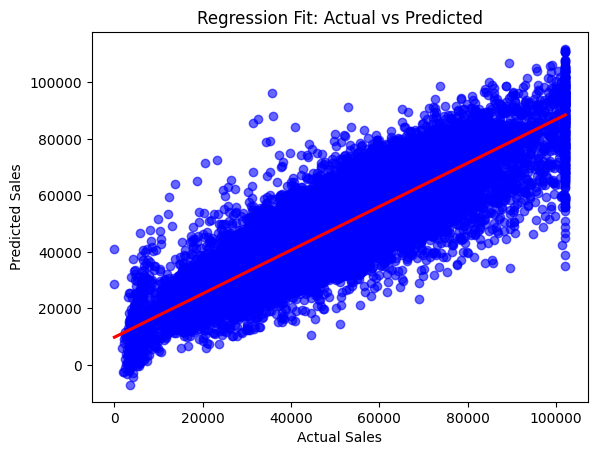

In [168]:
#Plotting the regression plot
reg_plot(y_test, y_test_pred)

The regression plot for the tuned CatBoost Regressor shows a strong alignment between actual and predicted sales, with most points clustered closely around the trend line. This indicates the model effectively captures sales patterns, though some scatter at higher sales values suggests occasional under- or over-predictions. Overall, CatBoost demonstrates high reliability in forecasting sales outcomes.

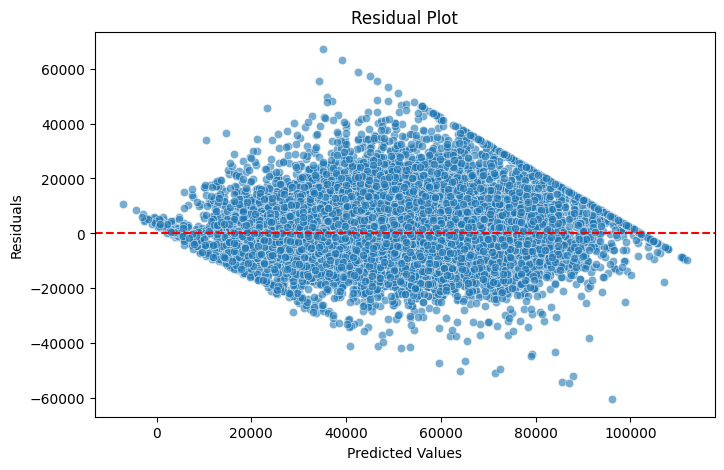

In [169]:
#Plotting the residual plot
residual_plot(y_test, y_test_pred)

The residual plot for the tuned CatBoost Regressor shows that prediction errors are centered around zero, indicating the model does not exhibit systematic bias in over- or under-predicting sales. While the spread of residuals widens at higher sales values, this is expected in large-scale sales data and still reflects stable performance. Overall, the residual distribution confirms that CatBoost delivers reliable and balanced forecasts.

In [170]:
#Predicting data for unseen data
unseen_data_pred = cat_model.predict(preprocessed_unseen_data)

In [171]:
#Applying KS-Test
stat, p_value = ks_test(y_train, unseen_data_pred)

KS Statistic: 0.09433112334337798, p-value: 1.1219962971142489e-150
Reject H0: Distributions differ significantly (model predictions may be biased).


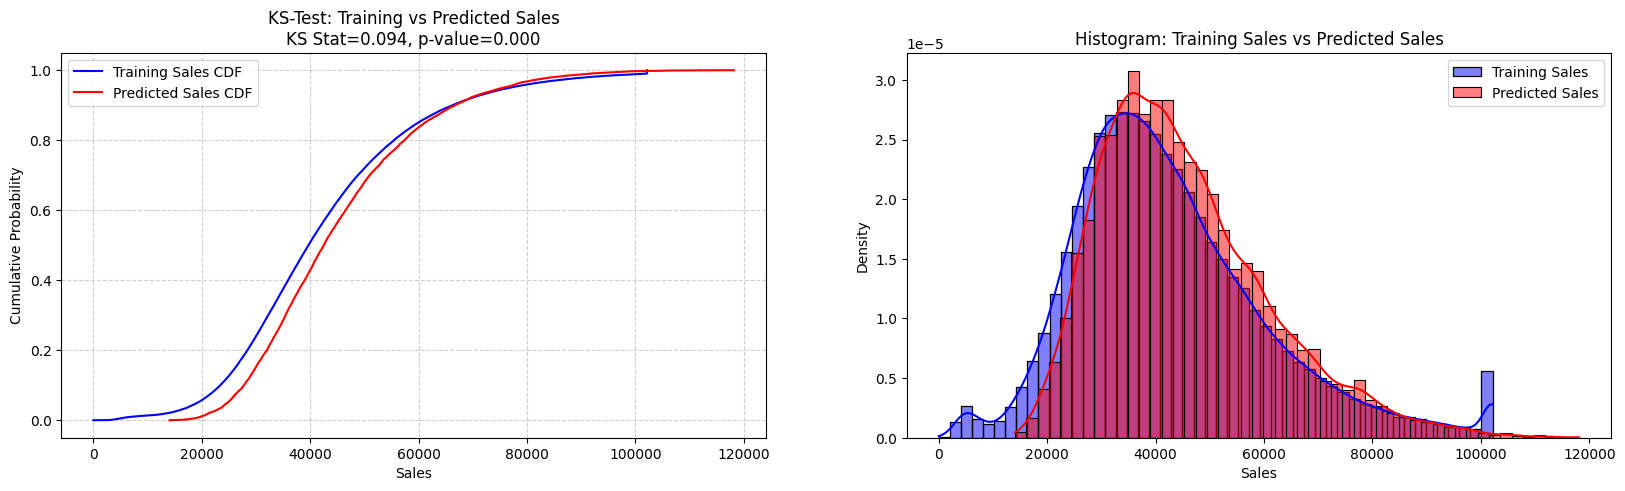

In [172]:
# CDF-plot and histogram
plots_hist_cdf(y_train, unseen_data_pred, stat, p_value)

The CDF-plot and histogram for the tuned CatBoost Regressor show that predicted sales distributions closely follow actual sales, with a KS statistic of 0.094, indicating only minor divergence. The overlap in the histograms further confirms that CatBoost effectively captures the sales distribution, making it a strong and reliable model for forecasting with minimal deviation from real patterns.

In [173]:
#Stacking to boost the ML models

# Base learners
base_models = [
    ("rf", RandomForestRegressor(
        n_estimators=150, min_samples_leaf=5, max_features=0.8, random_state=42, n_jobs=-1)),
    ("gbr", GradientBoostingRegressor(
        n_estimators=150, max_depth=7, learning_rate=0.2, max_leaf_nodes=80, random_state=42)),
    ("xgb", XGBRegressor(
        subsample=1.0, n_estimators=200, max_depth=5, learning_rate=0.3, colsample_bytree=0.8, random_state=42)),
    ("lgbm", LGBMRegressor(
        subsample=0.7, max_depth=7, learning_rate=0.3, colsample_bytree=0.7, boosting_type='gbdt', random_state=42)),
    ("cat", CatBoostRegressor(
        subsample=0.7, learning_rate=0.2, l2_leaf_reg=9, iterations=400, depth=6, bagging_temperature=1,
        loss_function='RMSE', verbose=0, random_state=42))
]

# Meta-learner (ridge regression to blend base model predictions)
meta_learner = RidgeCV()

# Stacking Regressor
stack_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

# Train the stacking model
stack_model.fit(X_train, y_train)

# Predictions
y_pred_stack = stack_model.predict(X_test)

# Evaluation
mae  = mean_absolute_error(y_test, y_pred_stack)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_stack))
r2   = r2_score(y_test, y_pred_stack)

print("=== Stacking Model Performance ===")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.3f}")

=== Stacking Model Performance ===
MAE : 6094.64
RMSE: 8451.34
R²  : 0.773


The R² ≈ 0.773 which is very close to tuned CatBoost, but only a tiny improvement over baseline and slightly worse than tuned CatBoost on MAE/RMSE.

📌 In short: Tuned CatBoost is both the most accurate and the most practical model to deploy.

<H3><font color='orange'>Time Series Forecasting: NN - LSTM</font></H3>

The LSTM Neural Network Model works on the principle of a sliding window, in which the new value is predicted as the average of previous 'n' values.

In [174]:
#Setting seed and creating a time series data frame.
np.random.seed(42);
tf.random.set_seed(42);
s = lstm_data.copy()
s['Date'] = pd.to_datetime(s['Date'])
s.groupby('Date').sum('Sales')
s.head()

Date       Sales
0 2018-01-01  15345484.5
1 2018-01-02  19592415.0
2 2018-01-03  18652527.0
3 2018-01-04  19956267.0
4 2018-01-05  22902651.0

In [175]:
#Setting the date index and Sales values for smooth calculation
s = s.sort_values('Date').set_index('Date')
y = s['Sales'].astype('float32').to_frame()

In [176]:
# Splitting the data where 80% is training set, 20% is testing set and 20% is validation set
# The dataset is splitted in 80/10/10 split by time
n = len(y)
n_train = int(n*0.8)
n_val   = int(n*0.1)

y_train = y.iloc[:n_train]
y_val   = y.iloc[n_train:n_train+n_val]
y_test  = y.iloc[n_train+n_val:]

In [177]:
#Applying min-max scaler
sc = MinMaxScaler()                        # scale to [0,1]
y_train_sc = sc.fit_transform(y_train)
y_val_sc   = sc.transform(y_val)
y_test_sc  = sc.transform(y_test)

In [178]:
"""Re-structuring the sales dataset for LSTM
   For example, if I have a Time series dataset like this [1,2,3,4,5,6,7,8,9].
   It needs to be re-structured as the following
   x = [[1,2,3],[2,3,4],[3,4,5],[4,5,6],[5,6,7],[6,7,8]]
   y = [4,5,6,7,8,9]
   In this way, the dataset is passed into the LSTM NN.
"""
def make_windows(arr, lookback=30, horizon=1):
    # arr shape: (T, 1), returns X:(T-lookback-horizon+1, lookback, 1), y:(..., horizon)
    X, Y = [], []
    for i in range(len(arr) - lookback - horizon + 1):
        X.append(arr[i:i+lookback])
        Y.append(arr[i+lookback:i+lookback+horizon])
    return np.array(X, dtype='float32'), np.array(Y, dtype='float32')

LOOKBACK = 30  # ~1 month
HORIZON  = 1   # predict next day (we'll recurse for multi-step)

X_tr, y_tr = make_windows(y_train_sc, LOOKBACK, HORIZON)
X_va, y_va = make_windows(np.vstack([y_train_sc[-LOOKBACK:], y_val_sc]), LOOKBACK, HORIZON)
X_te, y_te = make_windows(np.vstack([y_train_sc[-LOOKBACK:], y_val_sc, y_test_sc]), LOOKBACK, HORIZON)

# Build tf.data for speed
def ds(X, y, bs=256, shuffle=False):
    d = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle: d = d.shuffle(4096, seed=42)
    return d.batch(bs).prefetch(tf.data.AUTOTUNE)

train_ds = ds(X_tr, y_tr, shuffle=True)
val_ds   = ds(X_va, y_va)
test_ds  = ds(X_te, y_te)

In [179]:
#Applying the LSTM model for future prediction
keras.backend.clear_session()
model = keras.Sequential([
    keras.layers.Input(shape=(LOOKBACK, 1)),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(32),
    keras.layers.Dense(HORIZON)  # next-day forecast
])

model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
cb = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-5)
]

hist = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=cb, verbose=1)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 485ms/step - loss: 0.2152 - val_loss: 0.0936 - learning_rate: 0.0010
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0978 - val_loss: 0.0253 - learning_rate: 0.0010
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0272 - val_loss: 0.0349 - learning_rate: 0.0010
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0434 - val_loss: 0.0516 - learning_rate: 0.0010
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0519 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0282 - val_loss: 0.0178 - learning_rate: 0.0010
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0224 - val_loss: 0.0216 - learning_rate: 0.0010
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0273 - val_loss: 0.0261 - learning_rate: 0.0010
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0314 - val_loss: 0.0257 - learning_rate: 0.0010
Epoch 10/100
2/2 ━━━━━━━━━━

In [180]:
# Performance metrics evaluation
# Predict one-step ahead on test windows
y_pred_sc = model.predict(test_ds, verbose=0).reshape(-1, 1)
y_true_sc = y_te.reshape(-1, 1)

# Inverse-scale
y_pred = sc.inverse_transform(y_pred_sc).ravel()
y_true = sc.inverse_transform(y_true_sc).ravel()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
print(f"Test MSE: {mse:,.2f} | Test RMSE: {rmse:,.2f} | MAE: {mae:,.2f} | R2: {r2:.3f}")

Test MSE: 9,072,391,749,632.00 | Test RMSE: 3,012,041.13 | MAE: 2,240,112.50 | R2: 0.122


The current univariate LSTM model provides a baseline view of overall sales trends, with an RMSE of ~3.06M, MAE of ~2.26M, and R² of ~0.09. While the model captures the general sales level, it smooths over sharp spikes and dips, limiting its use for precise daily forecasting. At this stage, it should be considered a base model for trend understanding rather than a production-ready solution. Accuracy can be improved by enriching inputs with business drivers (e.g., discounts, holidays), tuning model parameters, or adopting hybrid/stacked approaches that combine LSTM’s trend detection with models better suited for volatility.

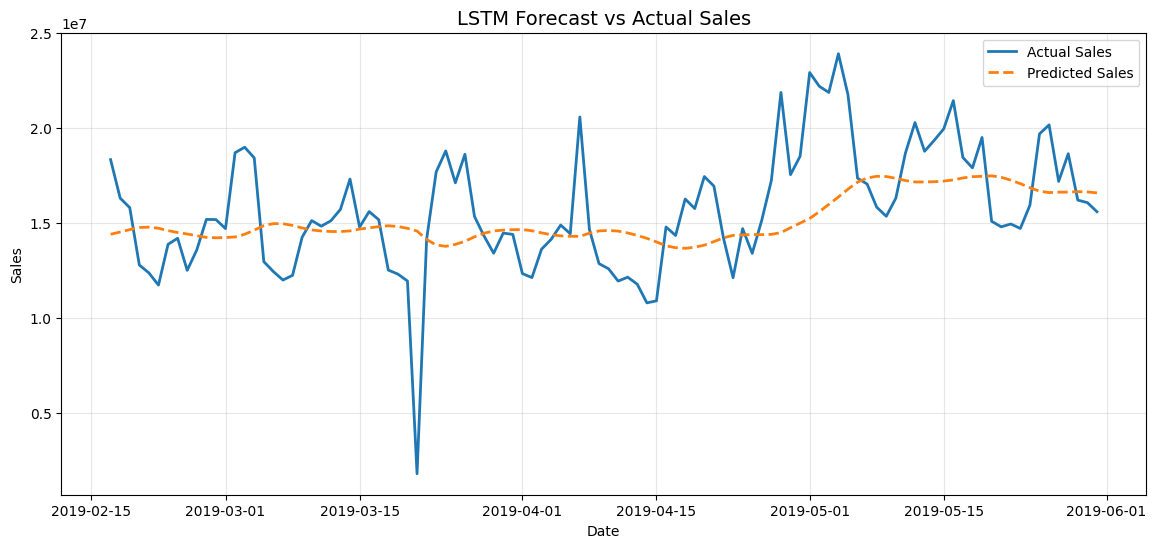

In [181]:
#Plot for Actual Sales vs Forecast Sales
test_dates = s.index[-len(y_true):]

# Create a DataFrame for plotting
results_df = pd.DataFrame({
    "Date": test_dates,
    "Actual": y_true,
    "Predicted": y_pred
})

# Plot
plt.figure(figsize=(14,6))
plt.plot(results_df["Date"], results_df["Actual"], label="Actual Sales", linewidth=2)
plt.plot(results_df["Date"], results_df["Predicted"], label="Predicted Sales", linewidth=2, linestyle="--")

plt.title("LSTM Forecast vs Actual Sales", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The graph above shows the average of previous 30 values **[1 month window]** to predict the next immediate value. An overview of the trend can be captured with this plot. This Neural  Network model suggests that how a value is predicted but cannot describe how this value changes over the time. In other words, how a value is escalated or plummeted cannot be described with this model.

In [182]:
#Forecasting for un-seen data
def forecast_future(model, last_window, n_steps, scaler):
    """
    model: trained LSTM
    last_window: last input window (scaled) from train/test data
    n_steps: how many future steps to predict
    scaler: fitted MinMaxScaler or StandardScaler
    """
    predictions = []

    current_input = last_window.reshape(1, -1, 1)  # reshape for LSTM

    for _ in range(n_steps):
        # Predict next step
        next_pred = model.predict(current_input, verbose=0)[0,0]
        predictions.append(next_pred)

        # Slide the window forward: drop first, add new prediction
        current_input = np.append(current_input[:,1:,:], [[[next_pred]]], axis=1)

    # Inverse transform to original scale
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1)).ravel()
    return predictions

In [183]:
# Prediction for unsee dataset & window size = 30 days
# last window from test set
us_d = unseen_data.copy()
us_d.drop(columns=["Store_id","Store_Type","Location_Type","Region_Code","Holiday","Discount"],axis=1,inplace=True)
us_d['Date'] = pd.to_datetime(us_d['Date'])
us_df = us_d.drop_duplicates()
us_df = us_df.sort_values('Date').set_index('Date')
length = len(us_df)

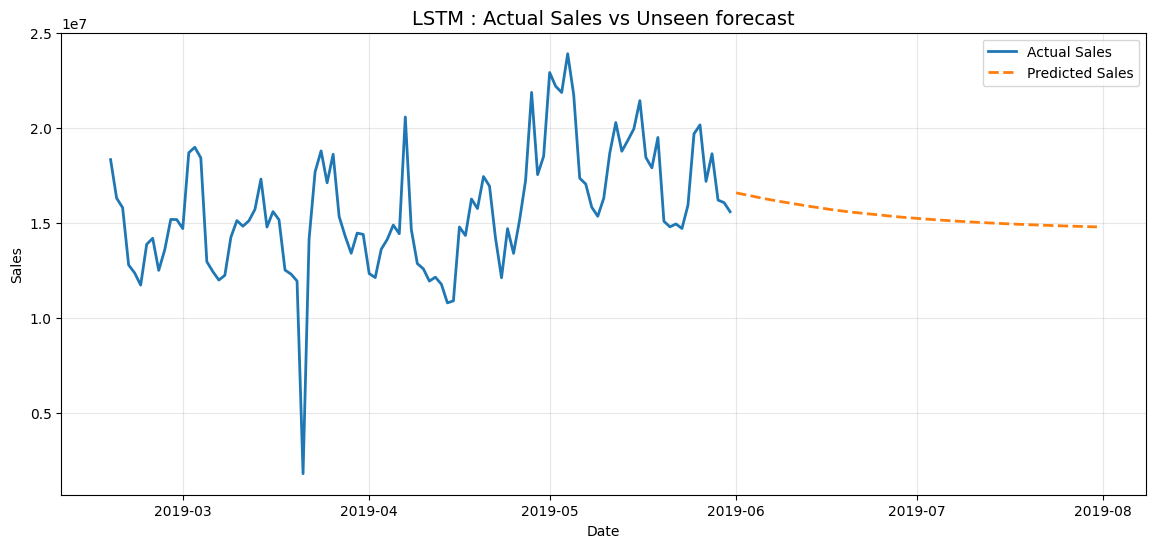

In [184]:
#Forecasting future values
last_window = X_te[-1]

future_preds = forecast_future(model, last_window, n_steps=length, scaler=sc)

results_df1 = pd.DataFrame({
    "Date": test_dates,
    "Actual": y_true
})

results_df2 = pd.DataFrame({
    "Date": us_df.index,
    "Predicted": future_preds
})


# Plot
plt.figure(figsize=(14,6))
plt.plot(results_df1["Date"], results_df1["Actual"], label="Actual Sales", linewidth=2)
plt.plot(results_df2["Date"], results_df2["Predicted"], label="Predicted Sales", linewidth=2, linestyle="--")

plt.title("LSTM : Actual Sales vs Unseen forecast", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The chart compares actual sales with an LSTM-based 30-day forecast. While the model captures the overall sales trend, the future predictions (orange line) are smoothed and conservative, staying near the historical average rather than reflecting sharp spikes or dips caused by factors such as discounts or holidays. This means the current model is suitable for establishing a baseline view of sales levels, but not yet accurate for forecasting short-term volatility. With additional business drivers (e.g., discounts, holidays) and model enhancements, the forecast can be made more realistic and production-ready.

<H1><font color='orange'>Recommendations</font> </H1>

We began with a baseline Linear Regression model, which provided a solid starting point for exploring advanced regression techniques such as RandomForestRegressor, GradientBoostingRegressor, XGBoost, LightGBM, stacking, LSTM (NN - model). Among these, CatBoostRegressor outperformed all others, thanks to its ability to handle categorical features efficiently, reduce overfitting through built-in regularisation, and deliver strong predictive accuracy - making it a strong candidate for API deployment.

In parallel, the SARIMAX model (compared to SARIMA model) leveraged time-series dynamics, capturing trends, seasonality, and exogenous factors like holidays and discounts, and also produced comparatively strong results. Looking ahead, predictions may improve further with advanced time-series approaches such as Facebook Prophet, or with neural network–based models (LSTM implemented) that can capture more complex patterns in the data. Additionally, techniques like stacking (base model implemented), cascading, or hyperparameter optimisation across different models may further enhance forecasting performance.

CatBoostRegressor - CatBoost outperformed other models because it is designed to reduce overfitting and bias through its ordered boosting technique, while still capturing complex sales patterns like sudden spikes or drops. Unlike other models that required heavy tuning to generalize well, CatBoost provided the most stable and accurate results straight out of training, with training and test performance nearly identical. This means CatBoost gives us the best balance of accuracy, stability, and reliability, making it the strongest choice for forecasting future sales trends.